In [1]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch
import copy
import argparse
import numpy as np
import json
import scipy
from torch_geometric.data import Data
from torch_sparse import SparseTensor
from tqdm import tqdm
from transformers import AutoModelForCausalLM, LlamaTokenizer, AdamW, get_linear_schedule_with_warmup,AutoTokenizer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, LoraModel, PeftConfig, PeftModel
import os
import pickle
from transformers.modeling_outputs import CausalLMOutputWithPast
from torch.nn import CrossEntropyLoss
import json
import random
import torch.nn as nn
import torch.nn.functional as F
from torch import einsum
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
import pickle
from proj import FP_arxiv, FP_deezer_europe, FP_roman_empire, FP_amazon_ratings, FP_questions,Edge_roman_empire
import random
import matplotlib.pyplot as plt
import re

/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('Asia/Shanghai')}
  warn(msg)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {

# 查看多少链接关系

In [ ]:
file_path = f'./amazon_ratings/amazon_ratings.npz'
data = np.load(file_path)

# 切分索引
train_indices = np.where(data['train_masks'][0])[0]
val_indices = np.where(data['val_masks'][0])[0]
test_indices = np.where(data['test_masks'][0])[0]


# data = np.load('./roman_empire/roman_empire.npz')
adj_t= SparseTensor(row=torch.tensor(data['edges']).t()[0].to(torch.long), col=torch.tensor(data['edges']).t()[1].to(torch.long),sparse_sizes=(len(data['node_labels']),len(data['node_labels']) ))
data= Data(x=torch.tensor(data['node_features']), adj_t=adj_t,y=torch.tensor(data['node_labels']))
data.adj_t = data.adj_t.to_symmetric()

In [ ]:
file_path = f'./amazon_ratings/amazon_ratings.npz'
data = np.load(file_path)

In [ ]:
# 反转每一行
reversed_edges = data['edges'][:, ::-1]

# 拼接原始数据与反转后的数据
a= np.concatenate((data['edges'], reversed_edges), axis=0)

In [ ]:
# 使用 numpy.unique 获取唯一值及计数
unique_values, counts = np.unique(data['node_labels'], return_counts=True)

# 输出结果
print("Unique values:", unique_values)
print("Counts:", counts)

In [ ]:
connection_counts = {}

# 遍历矩阵中的每一行
for row in a:
    # 更新连接数
    for node in row:
        if node in connection_counts:
            connection_counts[node] += 1
        else:
            connection_counts[node] = 1


In [ ]:
connection_counts

In [ ]:
# 将字典的值转换成数组
values = np.array(list(connection_counts.values()))

# 计算中位数
median_connections = np.median(values)

In [ ]:
average_connections = sum(connection_counts.values()) / len(connection_counts)

In [ ]:
average_connections

In [ ]:
print(median_connections)

# B.1

In [4]:
def get_total_grad_norm(parameters):
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_first_and_second_order_neighbors(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    return neighbors_dict

def random_get_first_and_second_order_neighbors_I(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 在完成邻居获取后，尝试添加扰动
        if len(first_order_neighbors) > 1:
            # 随机选择两个一阶邻居
            selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
            
            # 交换它们的二阶邻居列表
            first_order_neighbors[selected_neighbors[0]], first_order_neighbors[selected_neighbors[1]] = \
                first_order_neighbors[selected_neighbors[1]].copy(), first_order_neighbors[selected_neighbors[0]].copy()
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_II(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        iter_num=0
        while iter_num<=10:
            if len(first_order_neighbors) > 1:
                # 随机选择两个一阶邻居
                selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
                # 为这两个邻居随机选择一些二阶邻居进行交换
                swap_size = min(len(first_order_neighbors[selected_neighbors[0]]), len(first_order_neighbors[selected_neighbors[1]]))
                if swap_size > 0:
                    swap_indices = random.sample(range(swap_size), swap_size)
                    for idx in swap_indices:
                        first_order_neighbors[selected_neighbors[0]][idx], first_order_neighbors[selected_neighbors[1]][idx] = \
                            first_order_neighbors[selected_neighbors[1]][idx], first_order_neighbors[selected_neighbors[0]][idx]
            iter_num+=1
        
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_III(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    all_nodes = list(id_mapping.values())
    
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将所有的一阶和二阶节点收集到一个列表中
        all_neighbors = list(first_order_neighbors.keys()) + [neighbor for sublist in first_order_neighbors.values() for neighbor in sublist]
        
        print(first_order_neighbors)
        
        # 打乱所有节点
        np.random.shuffle(all_neighbors)
        
        # 重新分配一阶和二阶节点
        new_first_order_neighbors = all_neighbors[:len(first_order_neighbors)]
        new_second_order_neighbors = all_neighbors[len(first_order_neighbors):]
        
        # 构建新的邻居字典
        new_neighbors_dict = {node: [] for node in new_first_order_neighbors}
        
        for i, node in enumerate(new_first_order_neighbors):
            new_neighbors_dict[node] = new_second_order_neighbors[i * len(first_order_neighbors):(i + 1) * len(first_order_neighbors)]
        
        neighbors_dict[node_id.item()] = new_neighbors_dict
    
    return neighbors_dict


def get_all_neighbors(data, input_ids):
    # 获取所有输入节点的一阶和二阶邻居
    all_neighbors = {}
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        all_neighbors[node_id.item()] = first_order_neighbors
    
    return all_neighbors

def random_get_first_and_second_order_neighbors_IV(data, input_ids):
    all_neighbors = get_all_neighbors(data, input_ids)  # 获取整个 batch 的邻居信息
    neighbors_dict = {}

    for center_node_id in input_ids:
        temp_neighbors = copy.deepcopy(all_neighbors[center_node_id.item()])
        other_center_nodes = set(input_ids) - {center_node_id}
        
        # 收集其他中心节点的所有一阶和二阶邻居作为不相关节点池
        unrelated_nodes_pool = []
        for other_node_id in other_center_nodes:
            unrelated_nodes_pool.extend(list(all_neighbors[other_node_id.item()].keys()))
            for second_order_neighbors in all_neighbors[other_node_id.item()].values():
                unrelated_nodes_pool.extend(second_order_neighbors)
        
        # 确保不相关节点池中的节点不在当前中心节点的邻居列表中
        unrelated_nodes_pool = list(set(unrelated_nodes_pool) - set(temp_neighbors.keys()) - set([node for sublist in temp_neighbors.values() for node in sublist]))
        
        iter_num=0
        while iter_num<=10:
            if unrelated_nodes_pool:  # 如果存在不相关节点，则进行替换
                # 随机选择一定数量的不相关节点
                num_unrelated_to_replace = min(len(unrelated_nodes_pool), len(temp_neighbors)) // 2  # 可根据需要调整比例

                unrelated_nodes_sample = random.sample(unrelated_nodes_pool, num_unrelated_to_replace)

                # 对于每一个选中的不相关节点，随机决定是替换一阶还是二阶邻居
                for unrelated_node in unrelated_nodes_sample:
                    if random.choice([True, False]):  # 替换一阶邻居
                        replaced_node = random.choice(list(temp_neighbors.keys()))
                        temp_neighbors[unrelated_node] = temp_neighbors.pop(replaced_node)
                    else:  # 替换二阶邻居
                        if temp_neighbors:
                            first_order_node, second_order_neighbors = random.choice(list(temp_neighbors.items()))
                            if second_order_neighbors:
                                replaced_node = random.choice(second_order_neighbors)
                                second_order_neighbors.remove(replaced_node)
                                second_order_neighbors.append(unrelated_node)
            iter_num+=1
        neighbors_dict[center_node_id.item()] = temp_neighbors
    
    return neighbors_dict

In [9]:
def pre_data(args):
    if args.dataset=='ogbn-arxiv':
        dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/', transform=T.ToSparseTensor())
        data=dataset[0]
        data.adj_t = data.adj_t.to_symmetric()
        split_idx = dataset.get_idx_split()
        train_loader = NeighborLoader(data, input_nodes=split_idx["train"],
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      ,batch_size=args.batch_size, 
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["valid"],
                                      batch_size=args.batch_size,
                                         num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      , shuffle=False,num_workers=args.num_workers)
        test_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["test"],
                                     batch_size=args.batch_size,
                                    num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                     , shuffle=False,num_workers=args.num_workers)
        
    if args.dataset=='deezer-europe':
        deezer = scipy.io.loadmat(f'./deezer_europe/deezer-europe.mat')
        adj_t= SparseTensor(row=torch.tensor(deezer['A'].tocoo().row).to(torch.long), col=torch.tensor(deezer['A'].tocoo().col).to(torch.long),sparse_sizes=(len(deezer['label'][0]), len(deezer['label'][0])))
        data= Data(x=torch.tensor(deezer['features'].toarray()).to(torch.float32), adj_t=adj_t,y=torch.tensor(deezer['label']).squeeze())
        data.adj_t = data.adj_t.to_symmetric()
        # 获取节点总数
        num_nodes = len(data.y)
        # 定义数据集划分比例
        train_ratio = 0.5
        val_ratio = 0.25
        test_ratio = 0.25
        # 计算每种数据集包含的节点数
        num_train = int(num_nodes * train_ratio)
        num_val = int(num_nodes * val_ratio)
        num_test = num_nodes - num_train - num_val
        # 随机排列节点索引
        node_indices = torch.randperm(num_nodes)
        # 切分索引
        train_indices = node_indices[:num_train]
        val_indices = node_indices[num_train:num_train + num_val]
        test_indices = node_indices[num_train + num_val:]

        train_loader = NeighborLoader(data, input_nodes=train_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=True,num_workers=args.num_workers)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)    
    if args.dataset in ['roman_empire','amazon_ratings','questions']:
        file_path = f'./{args.dataset}/{args.dataset}_right.npz'
        data = np.load(file_path)
        
        # 切分索引
        train_indices = np.where(data['train_masks'][0])[0]
        val_indices = np.where(data['val_masks'][0])[0]
        test_indices = np.where(data['test_masks'][0])[0]
        
        
        # data = np.load('./roman_empire/roman_empire.npz')
        adj_t= SparseTensor(row=torch.tensor(data['edges']).t()[0].to(torch.long), col=torch.tensor(data['edges']).t()[1].to(torch.long),sparse_sizes=(len(data['node_labels']),len(data['node_labels']) ))
        data= Data(x=torch.tensor(data['node_features']), adj_t=adj_t,y=torch.tensor(data['node_labels']))
        data.adj_t = data.adj_t.to_symmetric()


        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
    if args.dataset in ['pubmed']:
        file_path = f'./{args.dataset}/data.pt'
        data = torch.load(file_path)
        
        data.adj_t = data.adj_t.to_symmetric()
        
        data.y=torch.tensor(data.y)
        
        node_id = np.arange(data.num_nodes)
        np.random.shuffle(node_id)

        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
            
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
    if args.dataset in ['wikics']:
        file_path = f'./{args.dataset}/data_token_right_10.pt'
        
        data = torch.load(file_path)
        
        node_id = np.arange(data.num_nodes)
        
        
        random.shuffle(node_id)
        
        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
        
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)

    
    return train_loader,valid_loader,test_loader,data

In [43]:
def get_args():
    parser = argparse.ArgumentParser(description="PyTorch PYG implementation")
    parser.add_argument('--seed', type=int, default=42, help='random seed')

    # CPU/GPU
    parser.add_argument("--num_workers", default=6, type=int)
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument('--device', default='cuda:0')
    
    """LLM Config"""
    parser.add_argument('--backbone', type=str, default='./llama2-7b-hf')
    parser.add_argument('--tokenizer', type=str, default='AutoTokenizer')
    parser.add_argument('--max_text_length', type=int, default=4096)
    parser.add_argument('--lora_r', type=int, default=64)
    parser.add_argument('--lora_alpha', type=int, default=128)
    parser.add_argument('--lora_dropout', type=int, default=0.05)

    
    """LLM Training"""
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--warmup_ratio', type=float, default=0.05)
    parser.add_argument('--weight_decay', type=float, default=0.005)
    parser.add_argument('--clip_grad_norm', type=float, default=1.0)
    parser.add_argument('--gradient_accumulation_steps', type=int, default=8)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--adam_eps', type=float, default=1e-8)
    parser.add_argument('--adam_beta1', type=float, default=0.9)
    parser.add_argument('--adam_beta2', type=float, default=0.999)
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--dropout', type=float, default=0.5)
    parser.add_argument(
        "--num_neighbors",
        type=str,
        default="8,8",
        help="Number of samples for each layer in SAGE. Length = num_layers",
    )
    parser.add_argument(
        "--perturbation",
        type=int,
        default=0,
        help="perturbation type",
    )
    """Dataset"""
    parser.add_argument('--do_lower_case', action='store_true')
    parser.add_argument("--dataset", type=str, default="amazon_ratings", help="Dataset")
    parser.add_argument("--data_path", type=str, default="./data", help="Path to data")
    parser.add_argument("--num_nodes", type=int, default="24492", help="the number of nodes")

    """Global """
    parser.add_argument("--train", type=bool, default="True", help="training ")
    parser.add_argument("--test", type=bool, default="False", help="testing ")
    args = parser.parse_args(args=[])

    
    return args

In [44]:
class Trainer():
    def __init__(self,args):
        self.args=args
        if args.dataset=='wikics':
            template={}
            template['train']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        if args.dataset=='roman_empire':
            template={}
            template['train']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>: {}"
            template['test']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>:"
        if args.dataset=='amazon_ratings':
            template={}
            template['train']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>: {}"
            template['test']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>:"
        if args.dataset=='pubmed':
            template={}
            template['train']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        
        self.template=template
        
        self.tokenizer = self.get_tokenizer()
        self.train_loader, self.valid_loader, self.test_loader,self.data=pre_data(self.args)
        
#         self.model= self.get_model()
        
#         self.optimizer, self.lr_scheduler=self.get_optimizer()
        
    def get_tokenizer(self):
        tokenizer = LlamaTokenizer.from_pretrained(self.args.backbone, max_length=self.args.max_text_length,do_lower_case=self.args.do_lower_case)
        tokenizer.padding_side = "left"
        tokenizer.pad_token = tokenizer.unk_token
        
        new_tokens=[ 'node_'+str(i) for i in range(self.args.num_nodes)]
        
        tokenizer.add_tokens(new_tokens)
        
        return tokenizer
    def get_optimizer(self):
        
        batch_per_epoch = len(self.train_loader)
        t_total = batch_per_epoch // self.args.gradient_accumulation_steps * self.args.epoch
        warmup_ratio = self.args.warmup_ratio
        warmup_iters = int(t_total * warmup_ratio)
        
        print("Batch per epoch: %d" % batch_per_epoch)
        print("Total Iters: %d" % t_total)
        print('Warmup ratio:', warmup_ratio)
        print("Warm up Iters: %d" % warmup_iters)
        
        
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": self.args.weight_decay,
                    'lr': self.args.lr,
                },
                # 这个组包含了bias和LayerNorm的所有参数，不应用权重衰减
                {
                    "params":[p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": 0.0,
                    'lr': self.args.lr,
                }

        ]
        optim = AdamW(optimizer_grouped_parameters,
                          lr=self.args.lr, eps=self.args.adam_eps)
        lr_scheduler = get_linear_schedule_with_warmup(optim, warmup_iters, t_total)
        
        return optim, lr_scheduler
    
    def get_model(self):
        model = AutoModelForCausalLM.from_pretrained(
                                    self.args.backbone,
                                    load_in_8bit=True,
                                    torch_dtype=torch.float16,
                                    use_safetensors=False,
                                    device_map='cuda:0'
                                )
        
        # model_embed=model.model.embed_tokens.weight.data
        
        model.resize_token_embeddings(32000+self.args.num_nodes)
        
        model.model.embed_tokens.weight.data[-self.args.num_nodes:]=self.data.x
        
        model = prepare_model_for_kbit_training(model)
        
        lora_config = LoraConfig(
            r=self.args.lora_r,
            lora_alpha=self.args.lora_alpha,
            lora_dropout=self.args.lora_dropout,
            bias="none",
            task_type="CAUSAL_LM",
            # target_modules=['q_proj','k_proj']
            target_modules=['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj']
            
        )
        
        model= get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        
        return model
    
    def get_prompt(self,batch,is_training=True):
        #将label又数字id形式转化为文字
        if self.args.dataset=='ogbn-arxiv':
            dict_labelid2categeory=load_pickle('dict_labelid2arxivcategeory.pkl')
        if self.args.dataset=='deezer-europe':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='female'
            dict_labelid2categeory[1]='male'
        if self.args.dataset=='roman_empire':
            dict_labelid2categeory={}
            
            dict_labelid2categeory = {1: 'prepositional object',2: 'preposition',3: 'determiner',4: 'adjectival',5: 
                                    'conjunct',6: 'nominal subject',7: 'coordinating conjunction',0: 'root',
                                    8: 'direct object',9: 'adverbial',10: 'compound',11: 'auxiliary',
                                    12: 'appositional',13: 'passive auxiliary',14: 'passive nominal subject',15:
                                    'possession',16: 'relative clause',17: 'other'}
            
        if self.args.dataset=='amazon_ratings':
            
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='Very Positive'
            dict_labelid2categeory[1]='Positive'
            dict_labelid2categeory[2]='Neutral'
            dict_labelid2categeory[3]='Negative'
            dict_labelid2categeory[4]='Very Negative'
            
        if self.args.dataset=='questions':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='activate'
            dict_labelid2categeory[1]='no'
        
        if self.args.dataset=='wikics':
            dict_labelid2categeory={
            0: 'Computational linguistics',
            1: 'Databases',
            2: 'Operating systems',
            3: 'Computer architecture',
            4: 'Computer security',
            5: 'Internet protocols',
            6: 'Computer file systems',
            7: 'Distributed computing architecture',
            8: 'Web technology',
            9: 'Programming language topics'}
        if self.args.dataset=='pubmed':
            dict_labelid2categeory={
            0: 'Diabetes Mellitus, Experimental',
            1: 'Diabetes Mellitus Type 1',
            2: 'Diabetes Mellitus Type 2'}
        if self.args.perturbation==0:
            neighbors_dict=get_first_and_second_order_neighbors(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==1:
            neighbors_dict=random_get_first_and_second_order_neighbors_I(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==2:
            neighbors_dict=random_get_first_and_second_order_neighbors_II(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==3:
            neighbors_dict=random_get_first_and_second_order_neighbors_III(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==4:
            neighbors_dict=random_get_first_and_second_order_neighbors_IV(batch,batch.n_id[:batch.batch_size])
            
        batch_text=[]
        labels=[]

        for i,label in zip(neighbors_dict.keys(),batch.y[:batch.batch_size]):
            label=dict_labelid2categeory[label.item()]
            connect_text='['
            text=''
            connect_text_list=[]
            for j in range(8):
                keys=list(neighbors_dict[i].keys())
                if  j < len(keys):
                    j = keys[j]
                    shuffled_indices = list(range(8))
                    random.shuffle(shuffled_indices)

                    nodes = ['node_' + str(neighbors_dict[i][j][idx]) if idx < len(neighbors_dict[i][j]) else '<unk>' for idx in shuffled_indices]

                    connect_text_list.append(f'node_{j} is connected [{",".join(nodes)} ] ,')
                else:
                    connect_text_list.append('<unk>' + ' is connected [' + ','.join('<unk>' for item in range(8)) + ' ] ,')
            random.shuffle(connect_text_list)
            connect_text += ''.join(connect_text_list)

            connect_text=connect_text[:-1]+']'
            if is_training :
                text = self.template['train'].format('node_'+str(i),connect_text,'node_'+str(i),label)+'</s>'
            else:
                text = self.template['test'].format('node_'+str(i),connect_text,'node_'+str(i))
            batch_text.append(text)
            labels.append(label+'</s>')
        
        input_ids=self.tokenizer(batch_text,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        attention_mask=self.tokenizer(batch_text,padding='longest',
                                      max_length=self.args.max_text_length,return_tensors="pt")['attention_mask']
        
        #去掉开头的字符
        label_ids=self.tokenizer(labels,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        
        attention_mask[input_ids.eq(0)]=0   
        
        if is_training:
            
            label_ids[label_ids.eq(self.tokenizer.pad_token_id)]=-100
            label_ids[:,-1]=2
            label_ids[label_ids.eq(1)]=-100
            label_ids=torch.cat((torch.full((label_ids.size(0), input_ids.size(-1)-label_ids.size(-1)), -100),
                              label_ids),dim=-1)
        else:
            # 测试阶段可能不需要生成标签
            label_ids = labels
        
        return input_ids, attention_mask, label_ids,neighbors_dict
        
    def load_checkpoint(self, ckpt_path,proj_path):
        results = self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
        results = self.proj_model.load_state_dict(torch.load(proj_path), strict=True)
        if self.verbose:
            print('Model loaded from ', ckpt_path)
            print('Model loaded from ', proj_path)
            print(results)
    def train(self):
        
        self.model.train()
        
        pbar = tqdm(total=len(self.train_loader), ncols=275)
        for epoch in range(self.args.epoch):
            
            for step_i, batch in enumerate(self.train_loader):
                
                input_ids, attention_mask, labels, neighbors_dict=self.get_prompt(batch,True)
                
                attention_mask=attention_mask.to(self.args.device)
                
                labels=labels.to(self.args.device)
                
                input_ids=input_ids.to(self.args.device)
                
                output= self.model(
                    input_ids=input_ids,
                    labels=labels,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True)
                
                loss = output['loss']/ self.args.gradient_accumulation_steps
                
                
                loss.backward()
                
                
                if step_i % self.args.gradient_accumulation_steps == 0:
                    # 在训练循环中调用
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.clip_grad_norm)
                    
                    self.optimizer.step()  # Update
                    self.lr_scheduler.step()
                    for param in self.model.parameters():
                        param.grad = None
                if step_i % 1 == 0:
                    lr = self.lr_scheduler.get_lr()[0]
                    desc_str = f'Epoch {epoch} | LR {lr:.6f} |'
                    desc_str += f' Loss:{loss:.3f}'
                    pbar.set_description(desc_str)
                    pbar.update(1)
        pbar.close()
            
        torch.save(self.model.state_dict(),"llmcom_{}_end_{}_pad.pth".format(self.args.epoch,self.args.dataset))
                                         
    def test(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}_pad.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            acc_list=[]
            for time in range(4):
                with torch.no_grad():
                    print('len of val_loader is {}'.format(len(self.test_loader)))
                    acc=0
                    for step_i, batch in tqdm(enumerate(self.test_loader)):

                        input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                        attention_mask=attention_mask.to(self.args.device)

                        input_ids=input_ids.to(self.args.device)

                        embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                        output= self.model.generate(inputs_embeds=embeds,
                                                    attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                        output=self.tokenizer.batch_decode(output)
                        # print(output)
                        print(labels)
                        for i in range(len(output)):
                            if labels[i] in output[i]:
                               acc+=1
                        print(acc)
                    acc_list.append(acc)
            print(acc_list)
    def test_perturbation(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}_pad.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            
            acc_list_perbation=[]
            for perturbation in range(1,5):
                print('test_perturbation is {}'.format(perturbation))
                self.args.perturbation=perturbation
                acc_list=[]
                for time in range(4):
                    with torch.no_grad():
                        print('len of val_loader is {}'.format(len(self.test_loader)))
                        acc=0
                        for step_i, batch in tqdm(enumerate(self.test_loader)):

                            input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                            attention_mask=attention_mask.to(self.args.device)

                            input_ids=input_ids.to(self.args.device)

                            embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                            output= self.model.generate(inputs_embeds=embeds,
                                                        attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                            output=self.tokenizer.batch_decode(output)
                            # print(output)
                            print(labels)
                            for i in range(len(output)):
                                if labels[i] in output[i]:
                                   acc+=1
                            print(acc)
                        acc_list.append(acc)
                print(acc_list)
                acc_list_perbation.append(acc_list)
            print(acc_list_perbation)    

In [45]:
def set_random_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 设置一个固定的随机种子值
seed_value = 42
set_random_seed(seed_value)

In [46]:
args=get_args()

In [47]:
trainer=Trainer(args)

In [9]:
trainer.model.load_state_dict(torch.load("llmcom_1_end_{}_pad.pth".format(trainer.args.dataset)), strict=True)  

AttributeError: 'Trainer' object has no attribute 'model'

In [34]:
trainer.args.dataset

'amazon_ratings'

In [48]:
ite=iter(trainer.test_loader)
batch=next(ite)
input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
attention_mask = attention_mask.to(trainer.args.device)
input_ids = input_ids.to(trainer.args.device)
node_index=torch.where((input_ids>=32000)|(input_ids==0))[1][:-1].cpu()
text_index=torch.where(~((input_ids>=32000)|(input_ids==0)))[1].cpu()

In [49]:
# node_index_dict={}
# text_index_dict={}

In [50]:
# node_index_dict[trainer.args.dataset]=node_index
# text_index_dict[trainer.args.dataset]=text_index

In [38]:
# node_index_dict

In [12]:
dataset=trainer.args.dataset

In [13]:
batch=next(iter(trainer.train_loader))

In [ ]:
import os
import torch
from tqdm import tqdm

# 确保atten_roman文件夹存在
if not os.path.exists(f'atten_pad_{dataset}'):
    os.makedirs(f'atten_pad_{dataset}')

def generate_avg_attn(trainer):
    with torch.no_grad():
        for step_i, batch in enumerate(tqdm(trainer.test_loader, desc="Processing batches")):
            input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
            attention_mask = attention_mask.to(trainer.args.device)
            input_ids = input_ids.to(trainer.args.device)
            output = trainer.model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            
            # 计算平均注意力权重
            all_attn = torch.stack([output.attentions[i].mean(dim=1) for i in range(32)]).transpose(0, 1).to(torch.float16)
            
            for i in range(all_attn.shape[0]):
                all_attn[i,:,(input_ids==0)[i]]=0
                
            yield all_attn.cpu()

# 初始化一个空列表来存储注意力权重
atten = []

# 遍历生成器并每处理100个batch保存一次atten
batch_counter = 0
for avg_attn in generate_avg_attn(trainer):
    atten.append(avg_attn)
    batch_counter += 1
    
    # 每100个batch保存一次atten
    if batch_counter % 100 == 0:
        # 将atten列表转换为张量并保存到atten_roman文件夹
        save_path = os.path.join(f'atten_pad_{dataset}', f'atten_{batch_counter // 100}.pth')
        torch.save(torch.stack(atten), save_path)
        # 清空atten列表以备下一轮使用
        atten.clear()

# 如果剩余不足100个batch的数据，则在最后也保存一下
if len(atten) > 0:
    save_path = os.path.join(f'atten_pad_{dataset}', 'atten_final.pth')
    torch.save(torch.cat(atten), save_path)

In [37]:
# 定义一个函数来读取所有存储的注意力权重文件
def load_attention_weights(directory):
    # 获取目录中的所有.pth文件
    files = [f for f in os.listdir(directory) if f.endswith('.pth')]
    
    # 加载所有.pth文件中的注意力权重
    attention_weights = []
    for file_name in files:
        file_path = os.path.join(directory, file_name)
        loaded_data = torch.load(file_path)
        attention_weights.append(loaded_data)
    
    return attention_weights


In [38]:
def calculate_column_averages(tensor):
    # 获取张量的形状
    n, m = tensor.shape
    
    # tensor=tensor[tensor.mean(axis=0)!=0,:]
    
    # 初始化一个列表来存储每列的平均值
    column_averages = []
    
    # 按列迭代
    for col_idx in range(m):
        # 提取当前列
        current_column = tensor[:, col_idx]
        
        # 过滤非零值
        non_zero_values = current_column[current_column != 0]
        
        # 计算非零值的平均值
        if len(non_zero_values) > 0:
            avg_value = torch.mean(non_zero_values)
        else:
            avg_value = torch.tensor(0.0)  # 如果没有非零值，则返回0作为平均值
        
        # 添加到结果列表
        column_averages.append(avg_value.item())
    
    return torch.tensor(column_averages)

In [16]:
# all_attn = torch.load(f'atten_pad_{dataset}').squeeze()
all_attn=load_attention_weights(f'atten_pad_{dataset}')
all_attn=torch.stack(all_attn)
all_attn=all_attn.squeeze().view(-1,all_attn.shape[-3],all_attn.shape[-2],all_attn.shape[-1]).cpu()

In [17]:
dataset

'amazon_ratings'

In [19]:
all_attn.shape

torch.Size([300, 32, 241, 241])

In [20]:
ite=iter(trainer.test_loader)
batch=next(ite)
input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
attention_mask = attention_mask.to(trainer.args.device)
input_ids = input_ids.to(trainer.args.device)
output = trainer.model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
node_index=torch.where((input_ids>=32000)|(input_ids==0))[1][:-1].cpu()
text_index=torch.where(~((input_ids>=32000)|(input_ids==0)))[1].cpu()

In [117]:
# node_attn=all_attn[:,:,:,node_index]

# node_attn_mean_column=[]

# for batch_id in range(node_attn.shape[0]):
#     for head_id in range(node_attn.shape[1]):
#         node_attn_column=calculate_column_averages(node_attn[batch_id,head_id])
#         node_attn_mean_column.append(node_attn_column)
        
# node_attn_mean_column=torch.stack(node_attn_mean_column)
# node_attn_mean_column=calculate_column_averages(node_attn_mean_column)

In [39]:
def plot_attention_scores(node_attn_mean_column, title, positions=None, save_path=None):
    """绘制注意力分数折线图"""
    if positions is None:
        positions = np.arange(1, len(node_attn_mean_column) + 1)

    plt.figure(figsize=(10, 6))
    line = plt.plot(positions, node_attn_mean_column, marker='o', label='2-hop node')[0]

    # 单独标记中心节点和一阶邻居
    center_node = positions[0]
    first_order_neighbors = positions[1::9]  # 每隔9个位置选取一个一阶邻居
    center_node_value = node_attn_mean_column[0]
    first_order_values = node_attn_mean_column[1::9]

    plt.plot(center_node, center_node_value, marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(first_order_neighbors):
        plt.plot(pos, first_order_values[i], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")

    # 设置轴标签和标题
    plt.xlabel('Node at Position')
    plt.ylabel('Attention Scores')
    plt.title(title)
    
    # 添加网格和图例
    plt.grid(True)
    plt.legend()

    # 如果提供了保存路径，则保存图像
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    # 显示图形
    plt.show()

def prepare_attention_data(all_attn, index, dim3_index):
    """准备注意力数据"""
    node_attn = all_attn[:, :, index, :]
    if dim3_index is not None:
        node_attn = node_attn[:, :, :, dim3_index]
    
    node_attn_mean_column = []
    for batch in range(node_attn.shape[0]):
        for layer in range(node_attn.shape[1]):
            node_attn_column = calculate_column_averages(node_attn[batch, layer])
            node_attn_mean_column.append(node_attn_column)
    
    node_attn_mean_column = torch.stack(node_attn_mean_column)
    node_attn_mean_column = calculate_column_averages(node_attn_mean_column)
    
    return node_attn_mean_column

In [22]:
node2node_attn_mean_column_node_to_node = prepare_attention_data(all_attn, node_index,node_index)
# plot_attention_scores(node2node_attn_mean_column_node_to_node, 'Node token to nodes attention')

In [23]:
text2node_attn_mean_column_text_to_node = prepare_attention_data(all_attn, text_index, dim3_index=node_index)
# plot_attention_scores(text2node_attn_mean_column_text_to_node, 'ALL token to nodes attention')

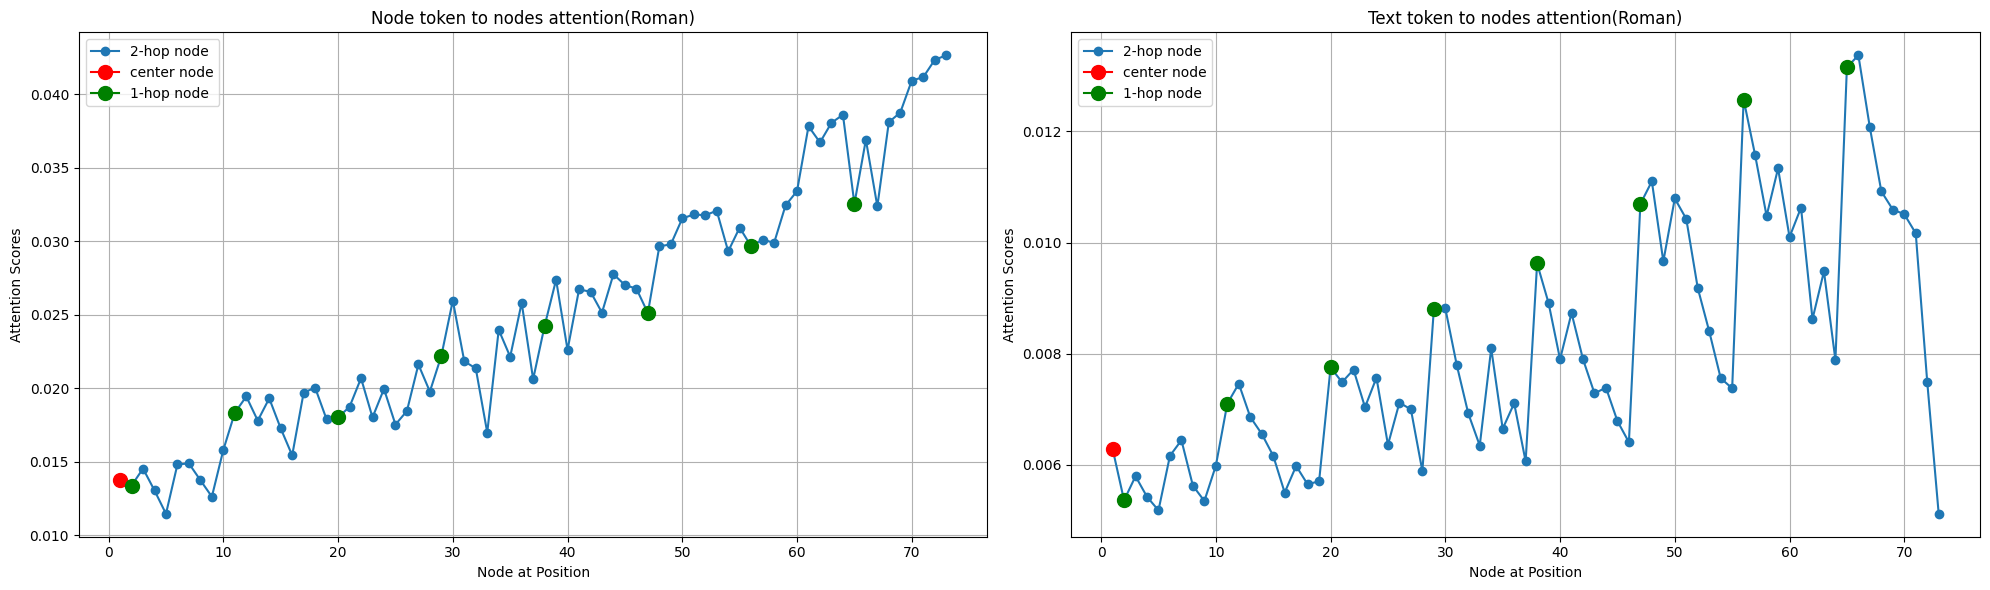

In [23]:
# 如果想将两个图表横向排列显示，可以使用以下代码：
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# 绘制第一个图表
positions = np.arange(1, len(node2node_attn_mean_column_node_to_node) + 1)
line1 = ax1.plot(positions, node2node_attn_mean_column_node_to_node, marker='o', label='2-hop node')[0]
ax1.plot(positions[0], node2node_attn_mean_column_node_to_node[0], marker='o', color='red', markersize=10, label='center node')
for i, pos in enumerate(positions[1::9]):
    ax1.plot(pos, node2node_attn_mean_column_node_to_node[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
ax1.set_xlabel('Node at Position')
ax1.set_ylabel('Attention Scores')
ax1.set_title('Node token to nodes attention(Roman)')
ax1.grid(True)
ax1.legend()

# 绘制第二个图表
positions = np.arange(1, len(text2node_attn_mean_column_text_to_node) + 1)
line2 = ax2.plot(positions, text2node_attn_mean_column_text_to_node, marker='o', label='2-hop node')[0]
ax2.plot(positions[0], text2node_attn_mean_column_text_to_node[0], marker='o', color='red', markersize=10, label='center node')
for i, pos in enumerate(positions[1::9]):
    ax2.plot(pos, text2node_attn_mean_column_text_to_node[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
ax2.set_xlabel('Node at Position')
ax2.set_ylabel('Attention Scores')
ax2.set_title('Text token to nodes attention(Roman)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()

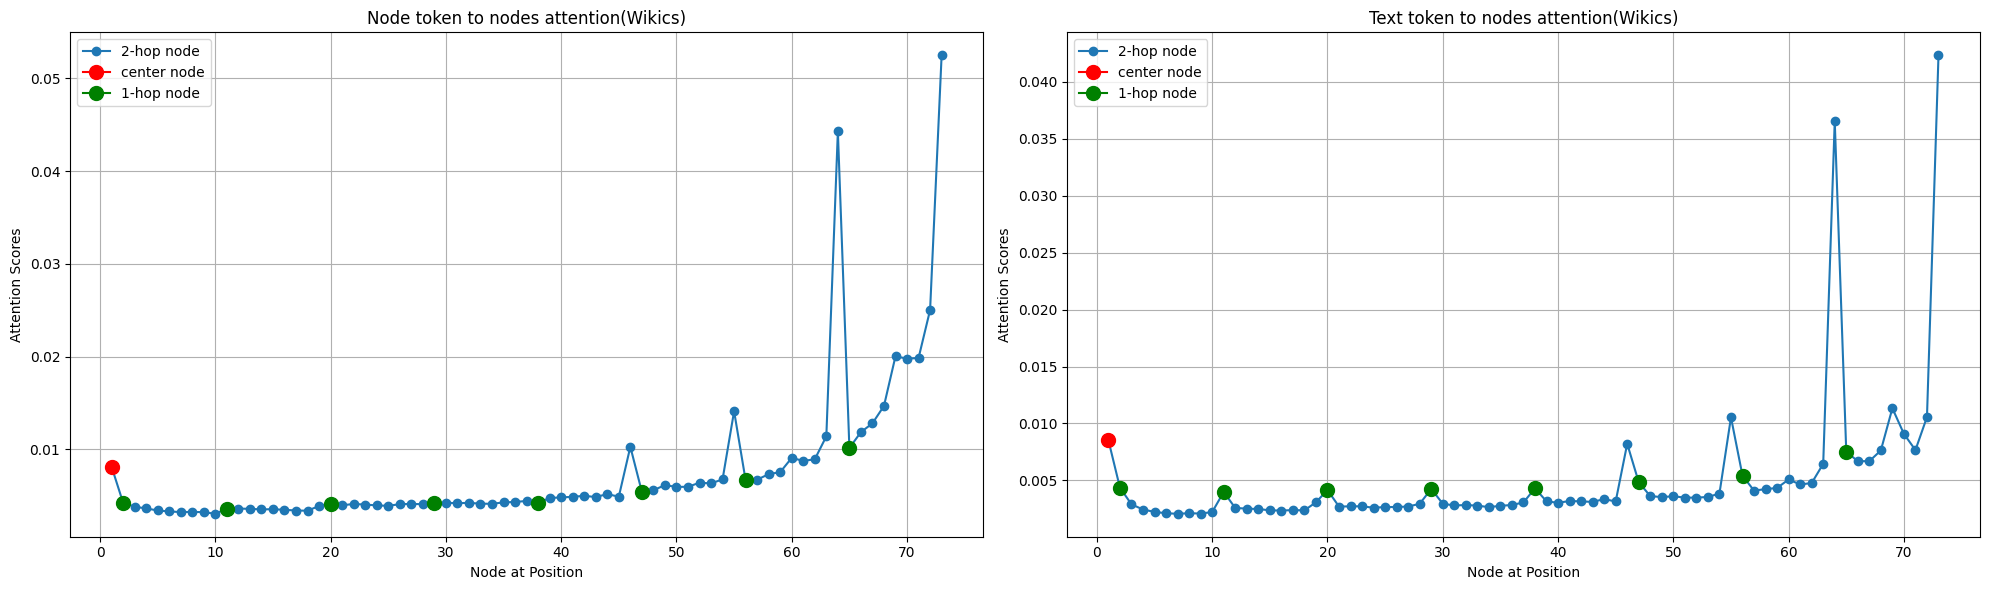

In [22]:
# 如果想将两个图表横向排列显示，可以使用以下代码：
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# 绘制第一个图表
positions = np.arange(1, len(node2node_attn_mean_column_node_to_node) + 1)
line1 = ax1.plot(positions, node2node_attn_mean_column_node_to_node, marker='o', label='2-hop node')[0]
ax1.plot(positions[0], node2node_attn_mean_column_node_to_node[0], marker='o', color='red', markersize=10, label='center node')
for i, pos in enumerate(positions[1::9]):
    ax1.plot(pos, node2node_attn_mean_column_node_to_node[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
ax1.set_xlabel('Node at Position')
ax1.set_ylabel('Attention Scores')
ax1.set_title('Node token to nodes attention(Wikics)')
ax1.grid(True)
ax1.legend()

# 绘制第二个图表
positions = np.arange(1, len(text2node_attn_mean_column_text_to_node) + 1)
line2 = ax2.plot(positions, text2node_attn_mean_column_text_to_node, marker='o', label='2-hop node')[0]
ax2.plot(positions[0], text2node_attn_mean_column_text_to_node[0], marker='o', color='red', markersize=10, label='center node')
for i, pos in enumerate(positions[1::9]):
    ax2.plot(pos, text2node_attn_mean_column_text_to_node[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
ax2.set_xlabel('Node at Position')
ax2.set_ylabel('Attention Scores')
ax2.set_title('Text token to nodes attention(Wikics)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()

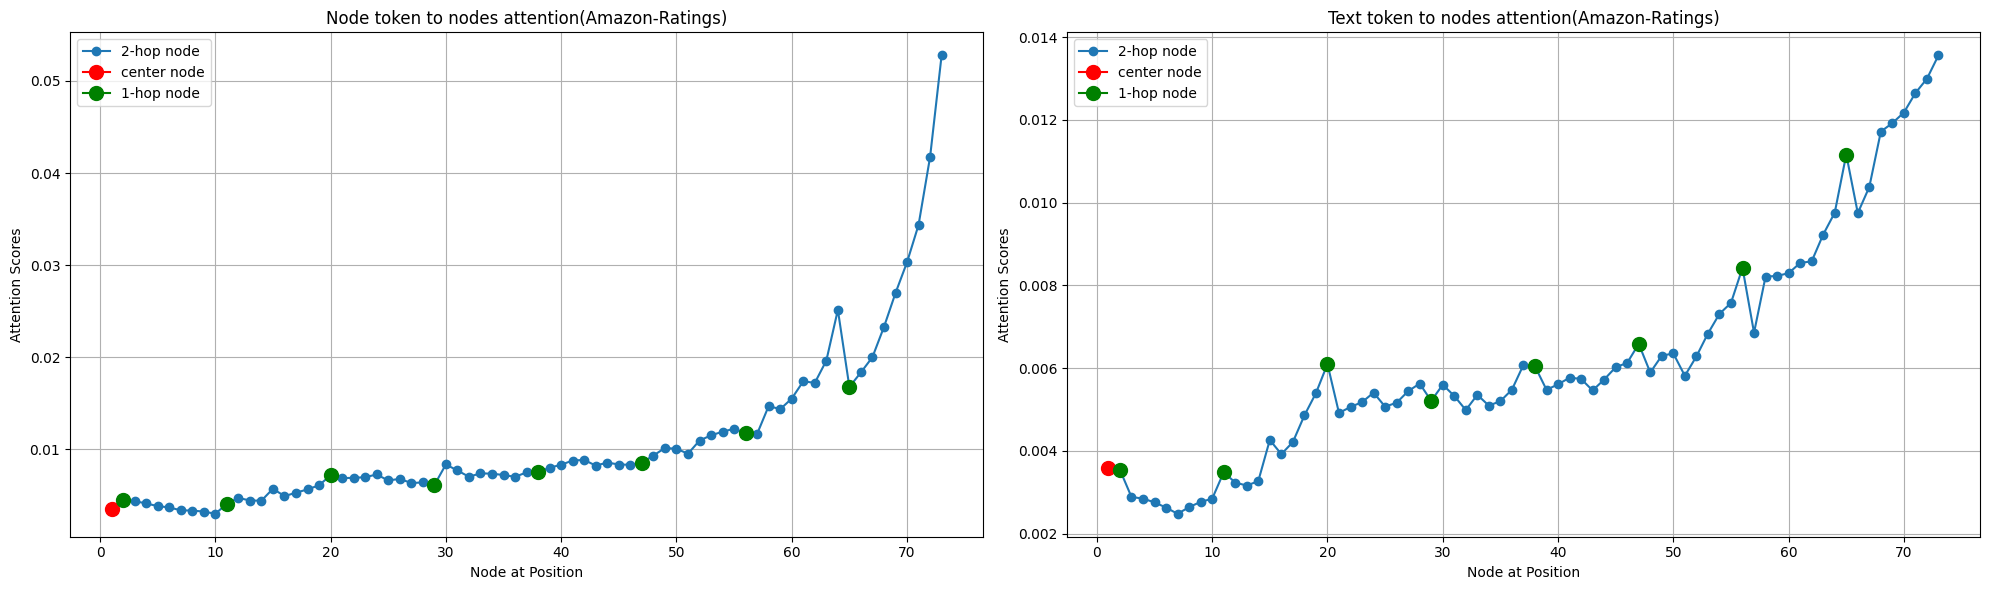

In [24]:
# 如果想将两个图表横向排列显示，可以使用以下代码：
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# 绘制第一个图表
positions = np.arange(1, len(node2node_attn_mean_column_node_to_node) + 1)
line1 = ax1.plot(positions, node2node_attn_mean_column_node_to_node, marker='o', label='2-hop node')[0]
ax1.plot(positions[0], node2node_attn_mean_column_node_to_node[0], marker='o', color='red', markersize=10, label='center node')
for i, pos in enumerate(positions[1::9]):
    ax1.plot(pos, node2node_attn_mean_column_node_to_node[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
ax1.set_xlabel('Node at Position')
ax1.set_ylabel('Attention Scores')
ax1.set_title('Node token to nodes attention(Amazon-Ratings)')
ax1.grid(True)
ax1.legend()

# 绘制第二个图表
positions = np.arange(1, len(text2node_attn_mean_column_text_to_node) + 1)
line2 = ax2.plot(positions, text2node_attn_mean_column_text_to_node, marker='o', label='2-hop node')[0]
ax2.plot(positions[0], text2node_attn_mean_column_text_to_node[0], marker='o', color='red', markersize=10, label='center node')
for i, pos in enumerate(positions[1::9]):
    ax2.plot(pos, text2node_attn_mean_column_text_to_node[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
ax2.set_xlabel('Node at Position')
ax2.set_ylabel('Attention Scores')
ax2.set_title('Text token to nodes attention(Amazon-Ratings)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()

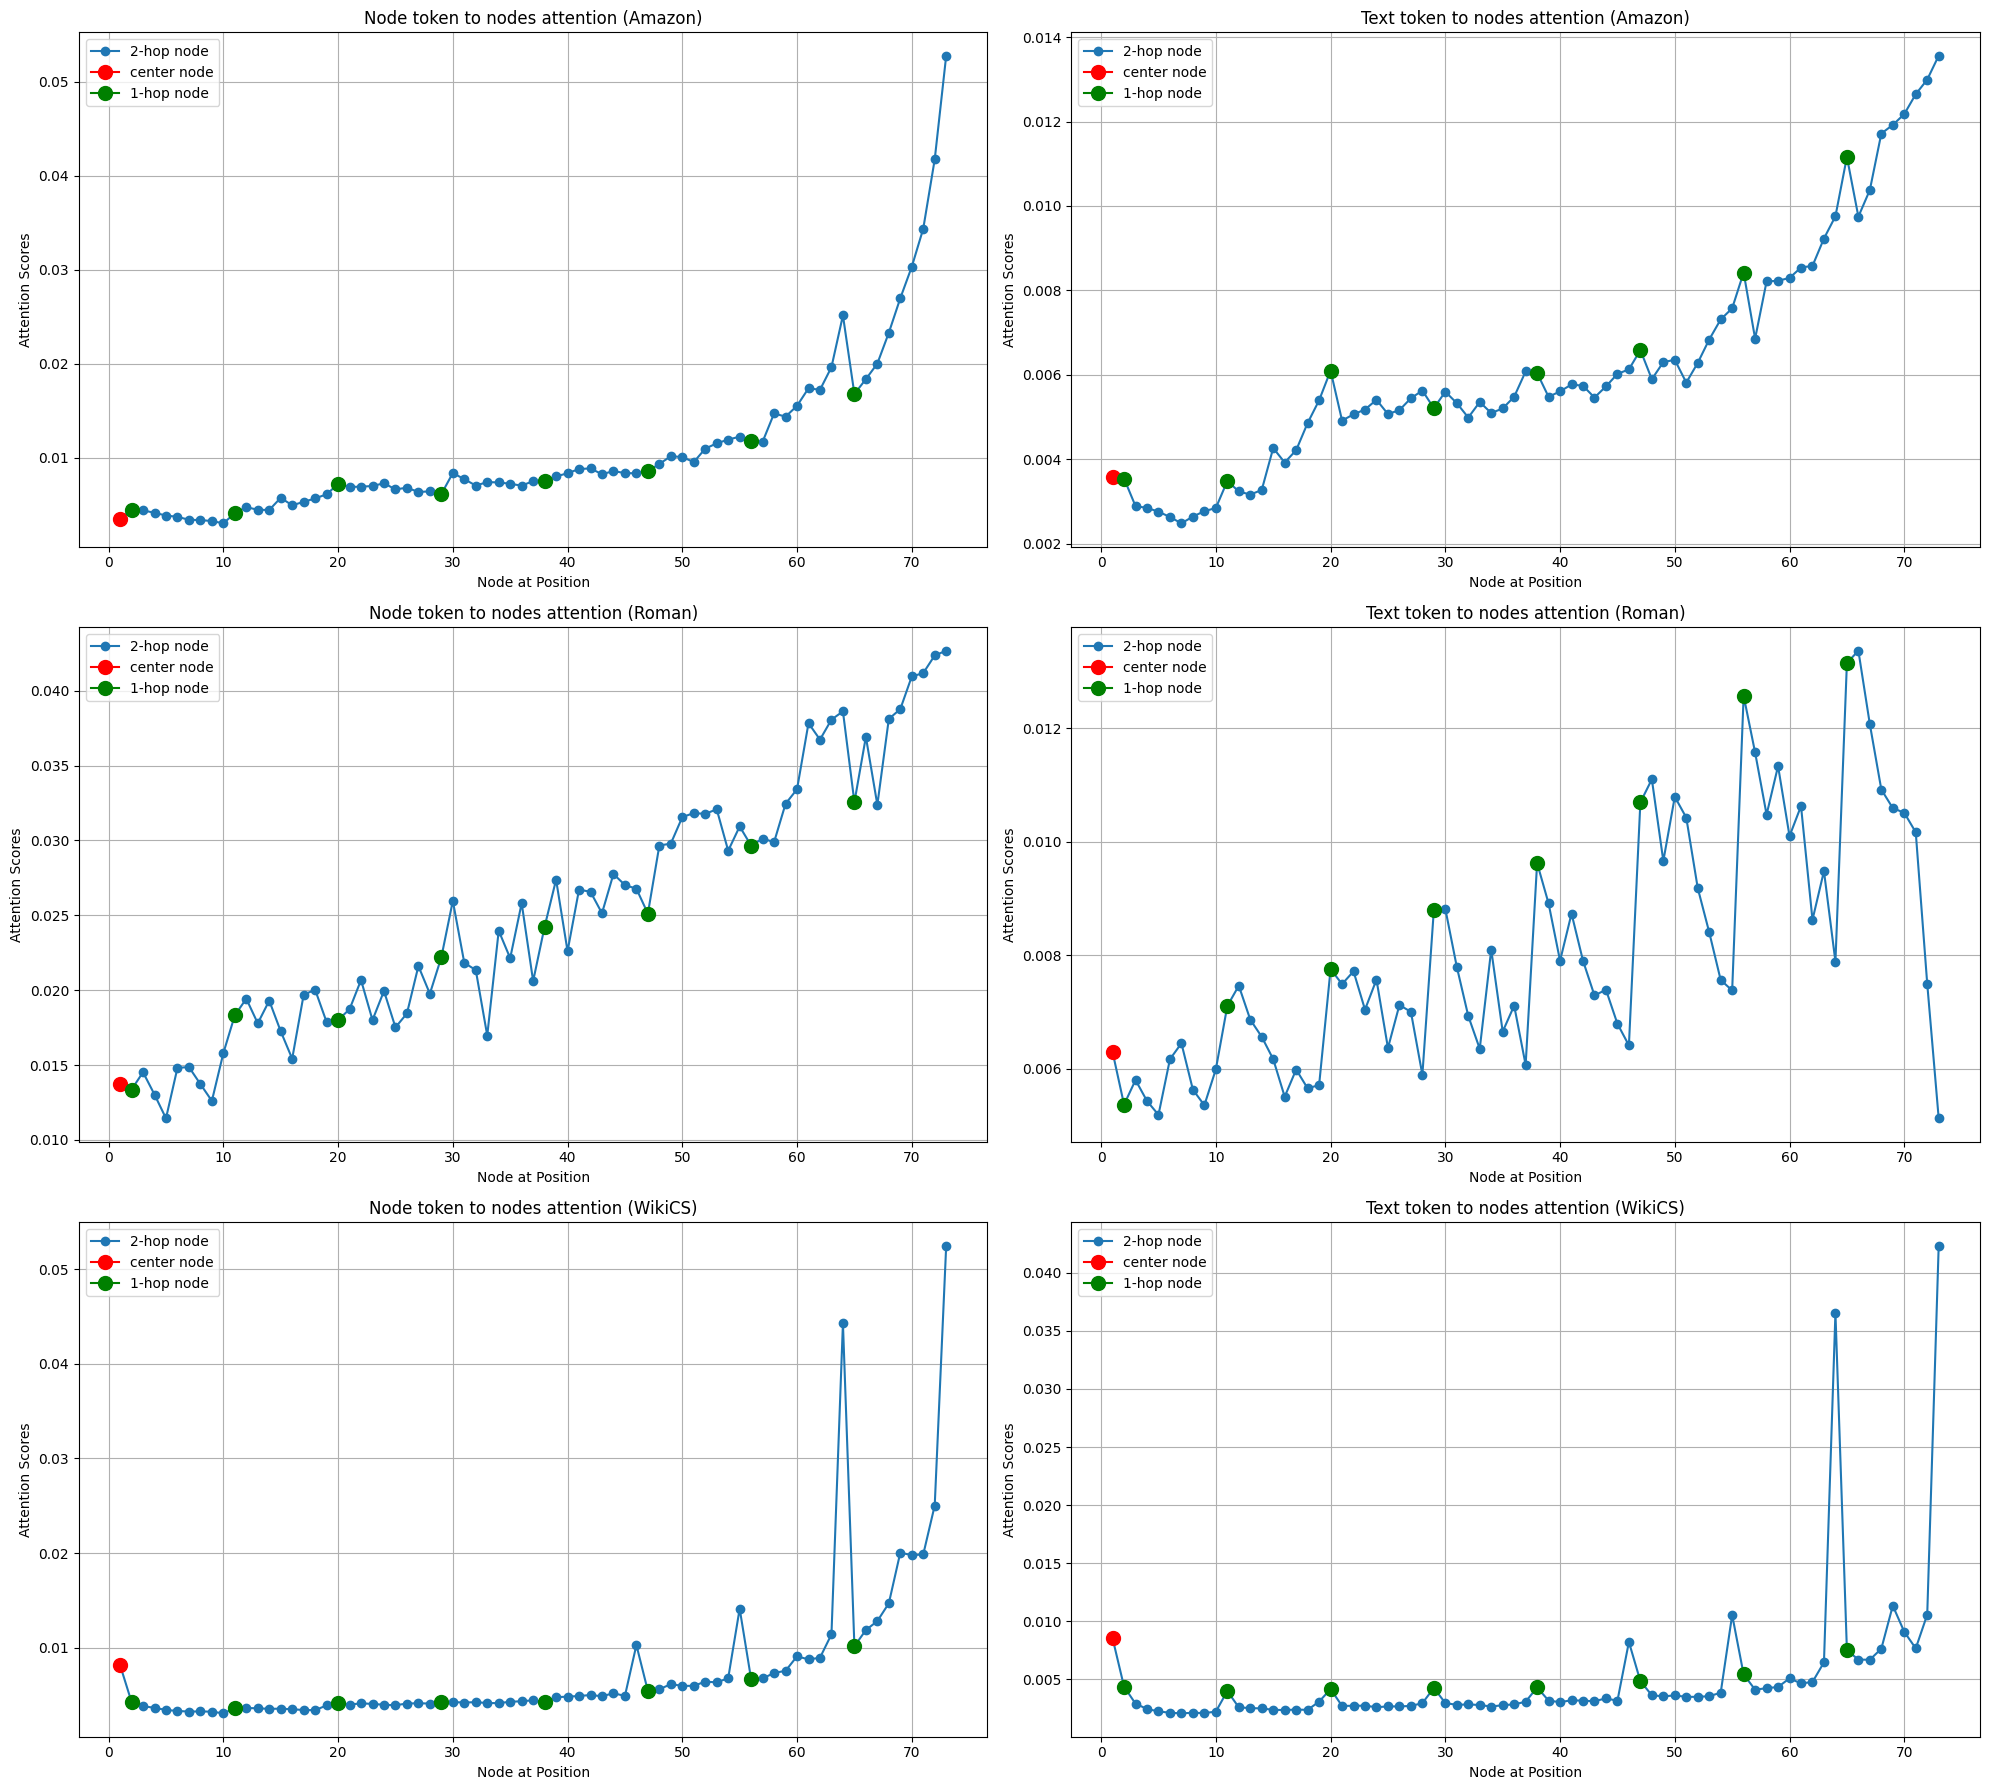

In [46]:

datasets = ['amazon_ratings', 'roman_empire', 'wikics']
titles_node_to_node = ['Node token to nodes attention (Amazon)', 'Node token to nodes attention (Roman)', 'Node token to nodes attention (WikiCS)']
titles_text_to_node = ['Text token to nodes attention (Amazon)', 'Text token to nodes attention (Roman)', 'Text token to nodes attention (WikiCS)']

fig, axes = plt.subplots(3, 2, figsize=(20, 18))

for idx, dataset in enumerate(datasets):
    # 假设你有一个方法来加载对应数据集的 all_attn 数据
    # 示例：all_attn = load_all_attn_data(dataset)
    all_attn=load_attention_weights(f'atten_pad_{dataset}')
    all_attn=torch.stack(all_attn)
    all_attn=all_attn.squeeze().view(-1,all_attn.shape[-3],all_attn.shape[-2],all_attn.shape[-1]).cpu()
    
    
    
    
    # 节点到节点的注意力
    node2node_attn_mean_column = prepare_attention_data(all_attn, node_index_dict[dataset],node_index_dict[dataset])
    
    # 文本到节点的注意力
    text2node_attn_mean_column = prepare_attention_data(all_attn, text_index_dict[dataset],node_index_dict[dataset])

    positions = np.arange(1, len(node2node_attn_mean_column) + 1)
    
    # 绘制第一个图表（节点到节点）
    ax1 = axes[idx, 0]
    line1 = ax1.plot(positions, node2node_attn_mean_column, marker='o', label='2-hop node')[0]
    ax1.plot(positions[0], node2node_attn_mean_column[0], marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax1.plot(pos, node2node_attn_mean_column[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
    ax1.set_xlabel('Node at Position')
    ax1.set_ylabel('Attention Scores')
    ax1.set_title(titles_node_to_node[idx])
    ax1.grid(True)
    ax1.legend()

    # 绘制第二个图表（文本到节点）
    ax2 = axes[idx, 1]
    line2 = ax2.plot(positions, text2node_attn_mean_column, marker='o', label='2-hop node')[0]
    ax2.plot(positions[0], text2node_attn_mean_column[0], marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax2.plot(pos, text2node_attn_mean_column[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
    ax2.set_xlabel('Node at Position')
    ax2.set_ylabel('Attention Scores')
    ax2.set_title(titles_text_to_node[idx])
    ax2.grid(True)
    ax2.legend()

plt.tight_layout()
plt.show()

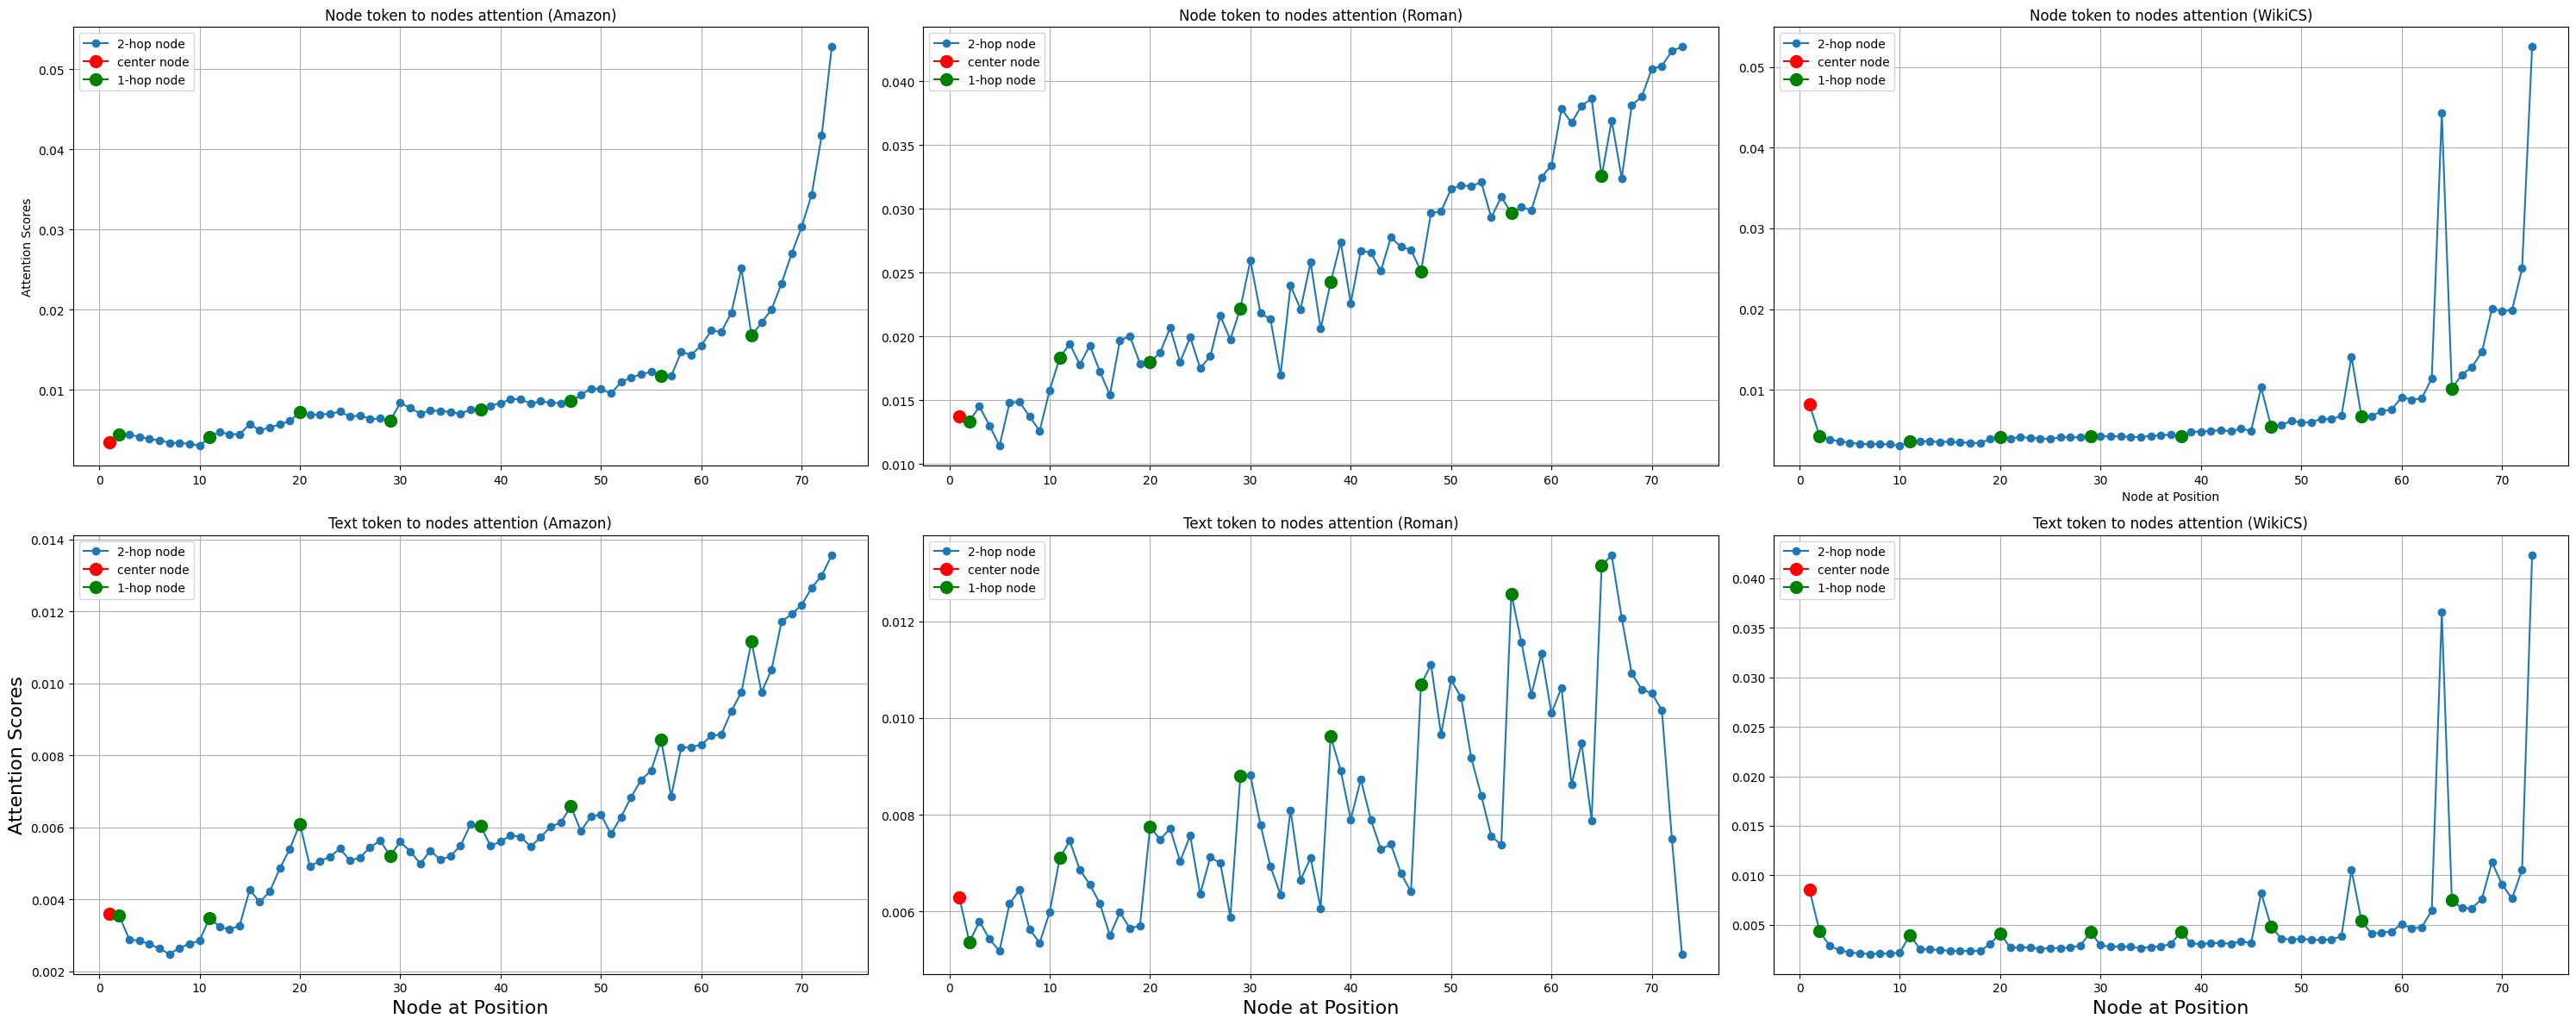

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 假设 load_attention_weights 和 prepare_attention_data 函数已经定义好
# 以及 node_index_dict 和 text_index_dict 已经根据数据集准备好了

datasets = ['amazon_ratings', 'roman_empire', 'wikics']
titles_node_to_node = ['Node token to nodes attention (Amazon)', 'Node token to nodes attention (Roman)', 'Node token to nodes attention (WikiCS)']
titles_text_to_node = ['Text token to nodes attention (Amazon)', 'Text token to nodes attention (Roman)', 'Text token to nodes attention (WikiCS)']

fig, axes = plt.subplots(2, 3, figsize=(30, 12))  # 修改了这里，使布局变为2x3

for idx, dataset in enumerate(datasets):
    all_attn = load_attention_weights(f'atten_pad_{dataset}')
    all_attn = torch.stack(all_attn)
    all_attn = all_attn.squeeze().view(-1, all_attn.shape[-3], all_attn.shape[-2], all_attn.shape[-1]).cpu()

    # 节点到节点的注意力
    node2node_attn_mean_column = prepare_attention_data(all_attn, node_index_dict[dataset], node_index_dict[dataset])

    # 文本到节点的注意力
    text2node_attn_mean_column = prepare_attention_data(all_attn, text_index_dict[dataset], node_index_dict[dataset])

    positions = np.arange(1, len(node2node_attn_mean_column) + 1)

    # 绘制第一个图表（节点到节点）
    ax1 = axes[0, idx]  # 修改了这里，使图表位于第一行
    line1 = ax1.plot(positions, node2node_attn_mean_column, marker='o', label='2-hop node')[0]
    ax1.plot(positions[0], node2node_attn_mean_column[0], marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax1.plot(pos, node2node_attn_mean_column[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
    
    # 设置标题
    ax1.set_title(titles_node_to_node[idx])
    ax1.grid(True)
    ax1.legend()
    
    # 只有最下面一行的子图设置X轴标签
    if idx == len(datasets) - 1:
        ax1.set_xlabel('Node at Position')
    
    # 只有最左边一列的子图设置Y轴标签
    if idx == 0:
        ax1.set_ylabel('Attention Scores')

    # 绘制第二个图表（文本到节点）
    ax2 = axes[1, idx]  # 修改了这里，使图表位于第二行
    line2 = ax2.plot(positions, text2node_attn_mean_column, marker='o', label='2-hop node')[0]
    ax2.plot(positions[0], text2node_attn_mean_column[0], marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax2.plot(pos, text2node_attn_mean_column[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
    
    # 设置标题
    ax2.set_title(titles_text_to_node[idx])
    ax2.grid(True)
    ax2.legend()
    
    # 只有最下面一行的子图设置X轴标签
    ax2.set_xlabel('Node at Position',fontsize=16)  # 这里是第二行，所以总是设置X轴标签
    
    # 只有最左边一列的子图设置Y轴标签
    if idx == 0:
        ax2.set_ylabel('Attention Scores',fontsize=16)

plt.tight_layout()
plt.show()

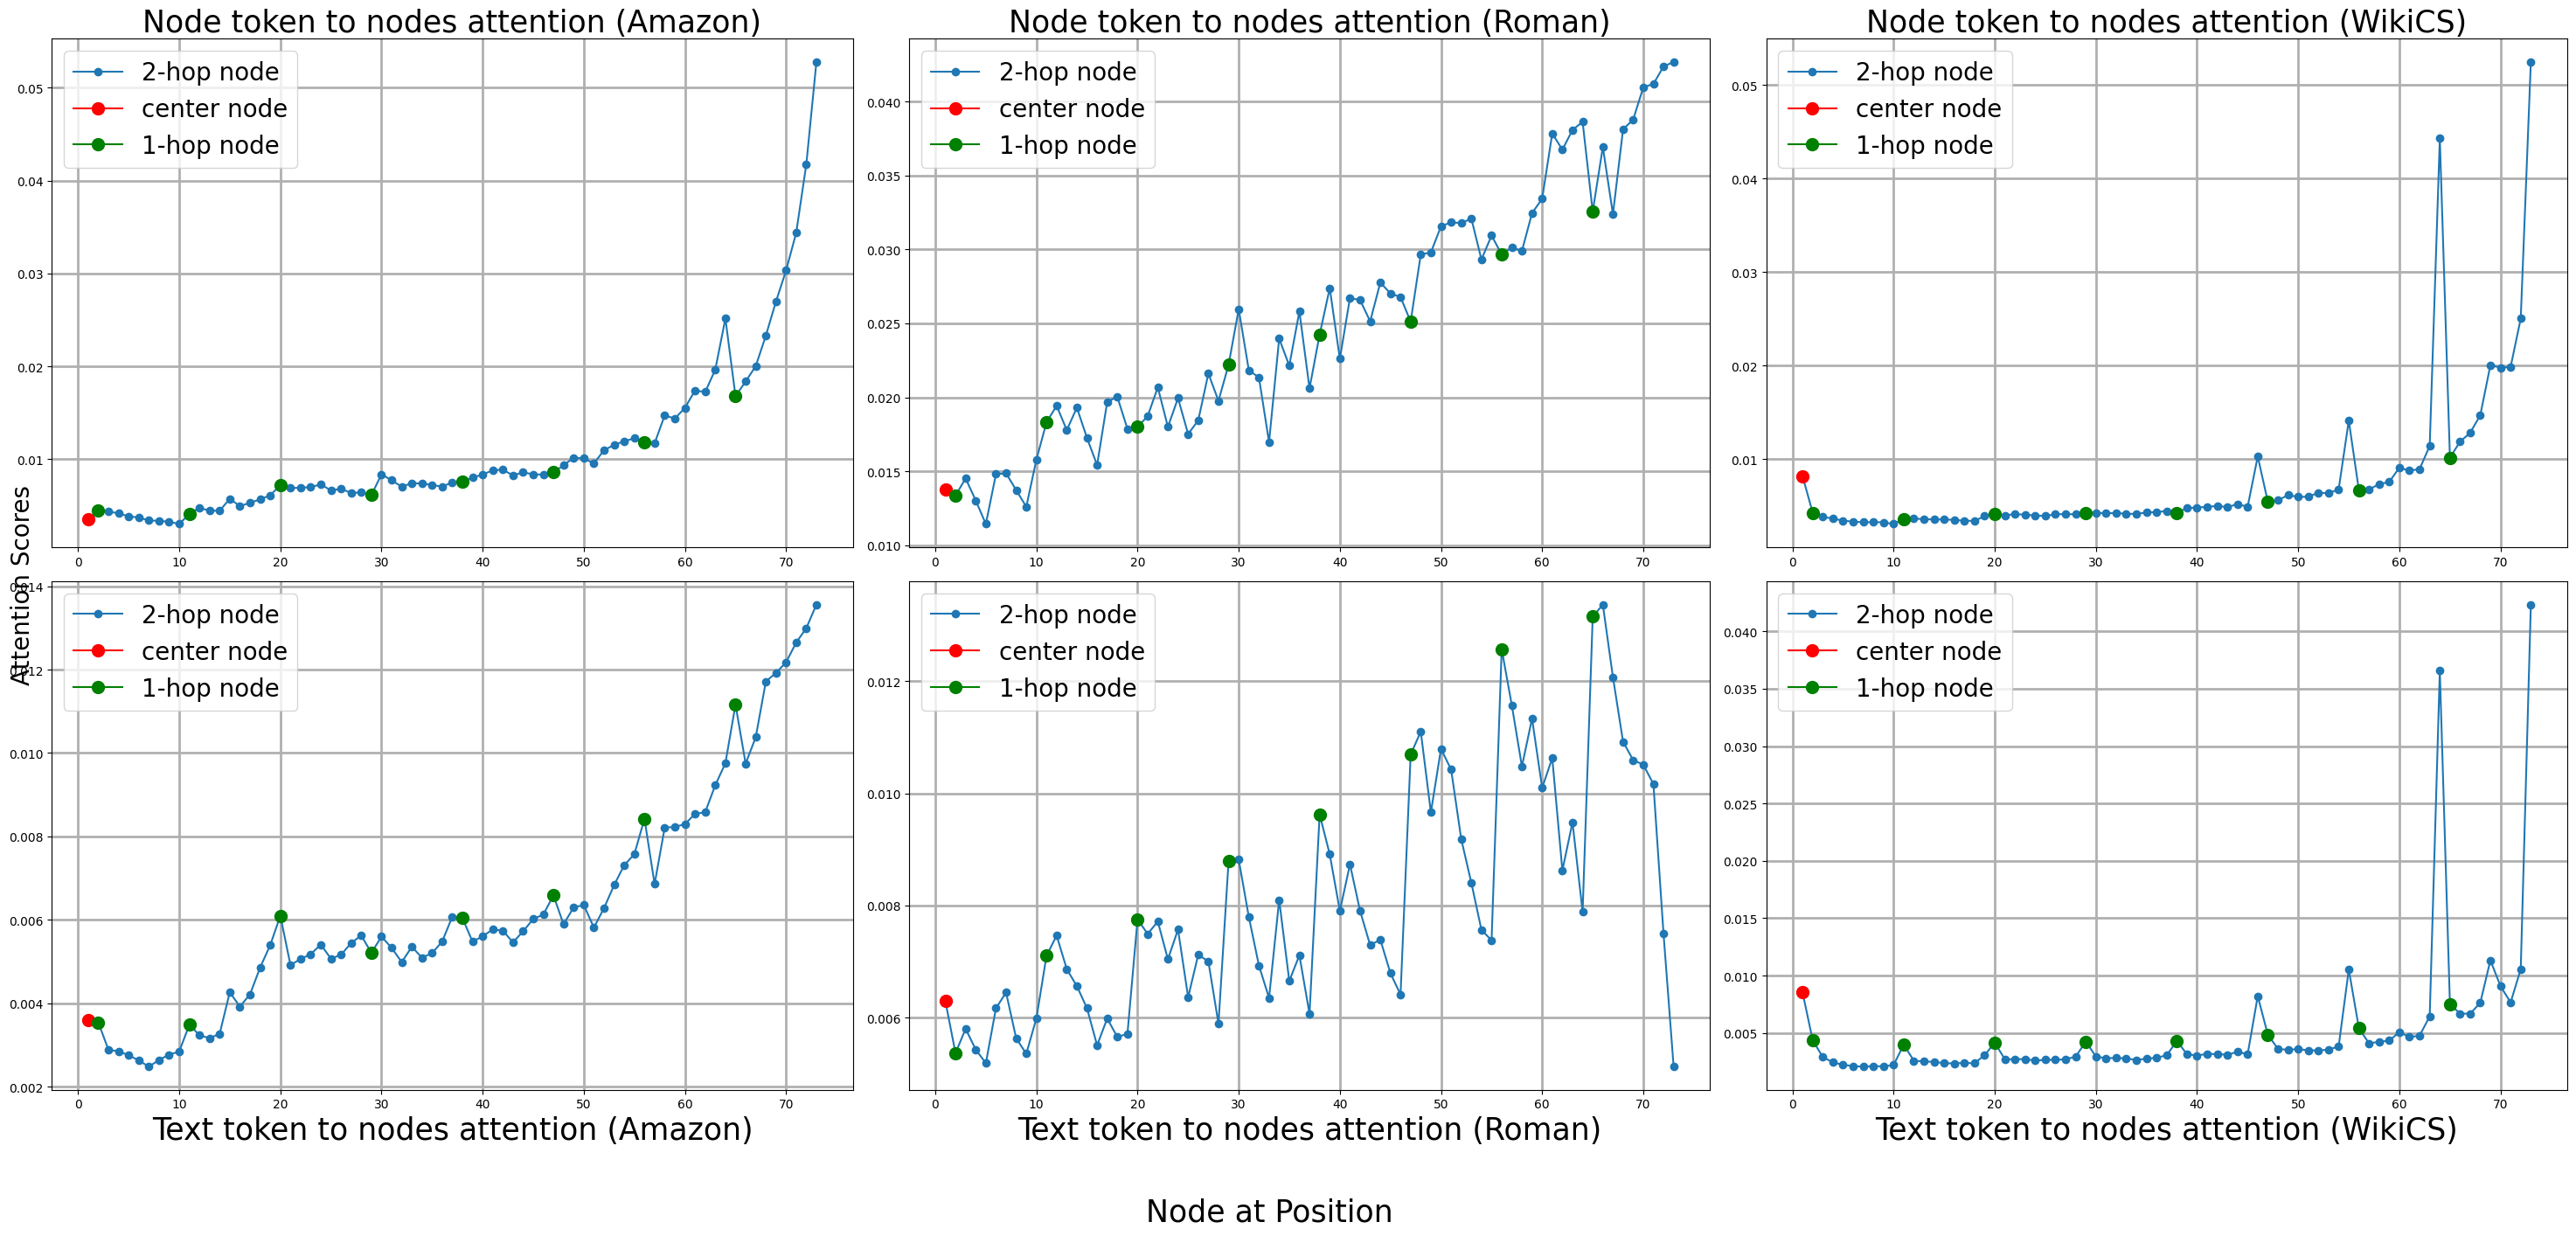

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 假设 load_attention_weights 和 prepare_attention_data 函数已经定义好
# 以及 node_index_dict 和 text_index_dict 已经根据数据集准备好了

datasets = ['amazon_ratings', 'roman_empire', 'wikics']
titles_node_to_node = ['Node token to nodes attention (Amazon)', 'Node token to nodes attention (Roman)', 'Node token to nodes attention (WikiCS)']
titles_text_to_node = ['Text token to nodes attention (Amazon)', 'Text token to nodes attention (Roman)', 'Text token to nodes attention (WikiCS)']

fig, axes = plt.subplots(2, 3, figsize=(30, 15))  # 修改了这里，使布局变为2x3

for idx, dataset in enumerate(datasets):
    all_attn = load_attention_weights(f'atten_pad_{dataset}')
    all_attn = torch.stack(all_attn)
    all_attn = all_attn.squeeze().view(-1, all_attn.shape[-3], all_attn.shape[-2], all_attn.shape[-1]).cpu()

    # 节点到节点的注意力
    node2node_attn_mean_column = prepare_attention_data(all_attn, node_index_dict[dataset], node_index_dict[dataset])

    # 文本到节点的注意力
    text2node_attn_mean_column = prepare_attention_data(all_attn, text_index_dict[dataset], node_index_dict[dataset])

    positions = np.arange(1, len(node2node_attn_mean_column) + 1)

    # 绘制第一个图表（节点到节点）
    ax1 = axes[0, idx]  # 修改了这里，使图表位于第一行
    line1 = ax1.plot(positions, node2node_attn_mean_column, marker='o', label='2-hop node')[0]
    ax1.plot(positions[0], node2node_attn_mean_column[0], marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax1.plot(pos, node2node_attn_mean_column[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
    
    # 设置标题
    ax1.set_title(titles_node_to_node[idx],fontsize=25)
    ax1.grid(True, which='both', linestyle='-', linewidth=2, alpha=1)
    ax1.legend(frameon=True, fontsize=20)
    
    # # 只有最左边一列的子图设置Y轴标签
    # if idx == 0:
    #     ax1.set_ylabel('Attention Scores')

    # 绘制第二个图表（文本到节点）
    ax2 = axes[1, idx]  # 修改了这里，使图表位于第二行
    line2 = ax2.plot(positions, text2node_attn_mean_column, marker='o', label='2-hop node')[0]
    ax2.plot(positions[0], text2node_attn_mean_column[0], marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax2.plot(pos, text2node_attn_mean_column[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
    
    # 设置标题
    ax2.set_xlabel(titles_text_to_node[idx],fontsize=25)
    ax2.grid(True, which='both', linestyle='-', linewidth=2, alpha=1)
    ax2.legend(fontsize=20)
    
    # # 只有最左边一列的子图设置Y轴标签
    # if idx == 0:
    #     ax2.set_ylabel('Attention Scores')

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node at Position', fontsize=25)
fig.supylabel('Attention Scores', fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局以适应共享标签


plt.show()

In [41]:
node_index_dict

{'roman_empire': tensor([ 51,  55,  59,  61,  63,  65,  67,  69,  71,  73,  76,  80,  82,  84,
          86,  88,  90,  92,  94,  97, 101, 103, 105, 107, 109, 111, 113, 115,
         118, 122, 124, 126, 128, 130, 132, 134, 136, 139, 143, 145, 147, 149,
         151, 153, 155, 157, 160, 164, 166, 168, 170, 172, 174, 176, 178, 181,
         185, 187, 189, 191, 193, 195, 197, 199, 202, 206, 208, 210, 212, 214,
         216, 218, 220]),
 'wikics': tensor([ 43,  47,  51,  53,  55,  57,  59,  61,  63,  65,  68,  72,  74,  76,
          78,  80,  82,  84,  86,  89,  93,  95,  97,  99, 101, 103, 105, 107,
         110, 114, 116, 118, 120, 122, 124, 126, 128, 131, 135, 137, 139, 141,
         143, 145, 147, 149, 152, 156, 158, 160, 162, 164, 166, 168, 170, 173,
         177, 179, 181, 183, 185, 187, 189, 191, 194, 198, 200, 202, 204, 206,
         208, 210, 212]),
 'amazon_ratings': tensor([ 57,  61,  66,  68,  70,  73,  76,  78,  80,  82,  85,  89,  91,  93,
          95,  97,  99, 101, 103, 1

In [42]:
text_index_dict

{'roman_empire': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  52,  53,  54,  56,  57,
          58,  60,  62,  64,  66,  68,  70,  72,  74,  75,  77,  78,  79,  81,
          83,  85,  87,  89,  91,  93,  95,  96,  98,  99, 100, 102, 104, 106,
         108, 110, 112, 114, 116, 117, 119, 120, 121, 123, 125, 127, 129, 131,
         133, 135, 137, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156,
         158, 159, 161, 162, 163, 165, 167, 169, 171, 173, 175, 177, 179, 180,
         182, 183, 184, 186, 188, 190, 192, 194, 196, 198, 200, 201, 203, 204,
         205, 207, 209, 211, 213, 215, 217, 219, 221, 222, 223, 224, 225, 226,
         227, 229, 230, 231, 232, 233, 234, 235, 236, 237]),
 'wikics': tensor([  0,   1,   2,   3,   4,   5,   6, 

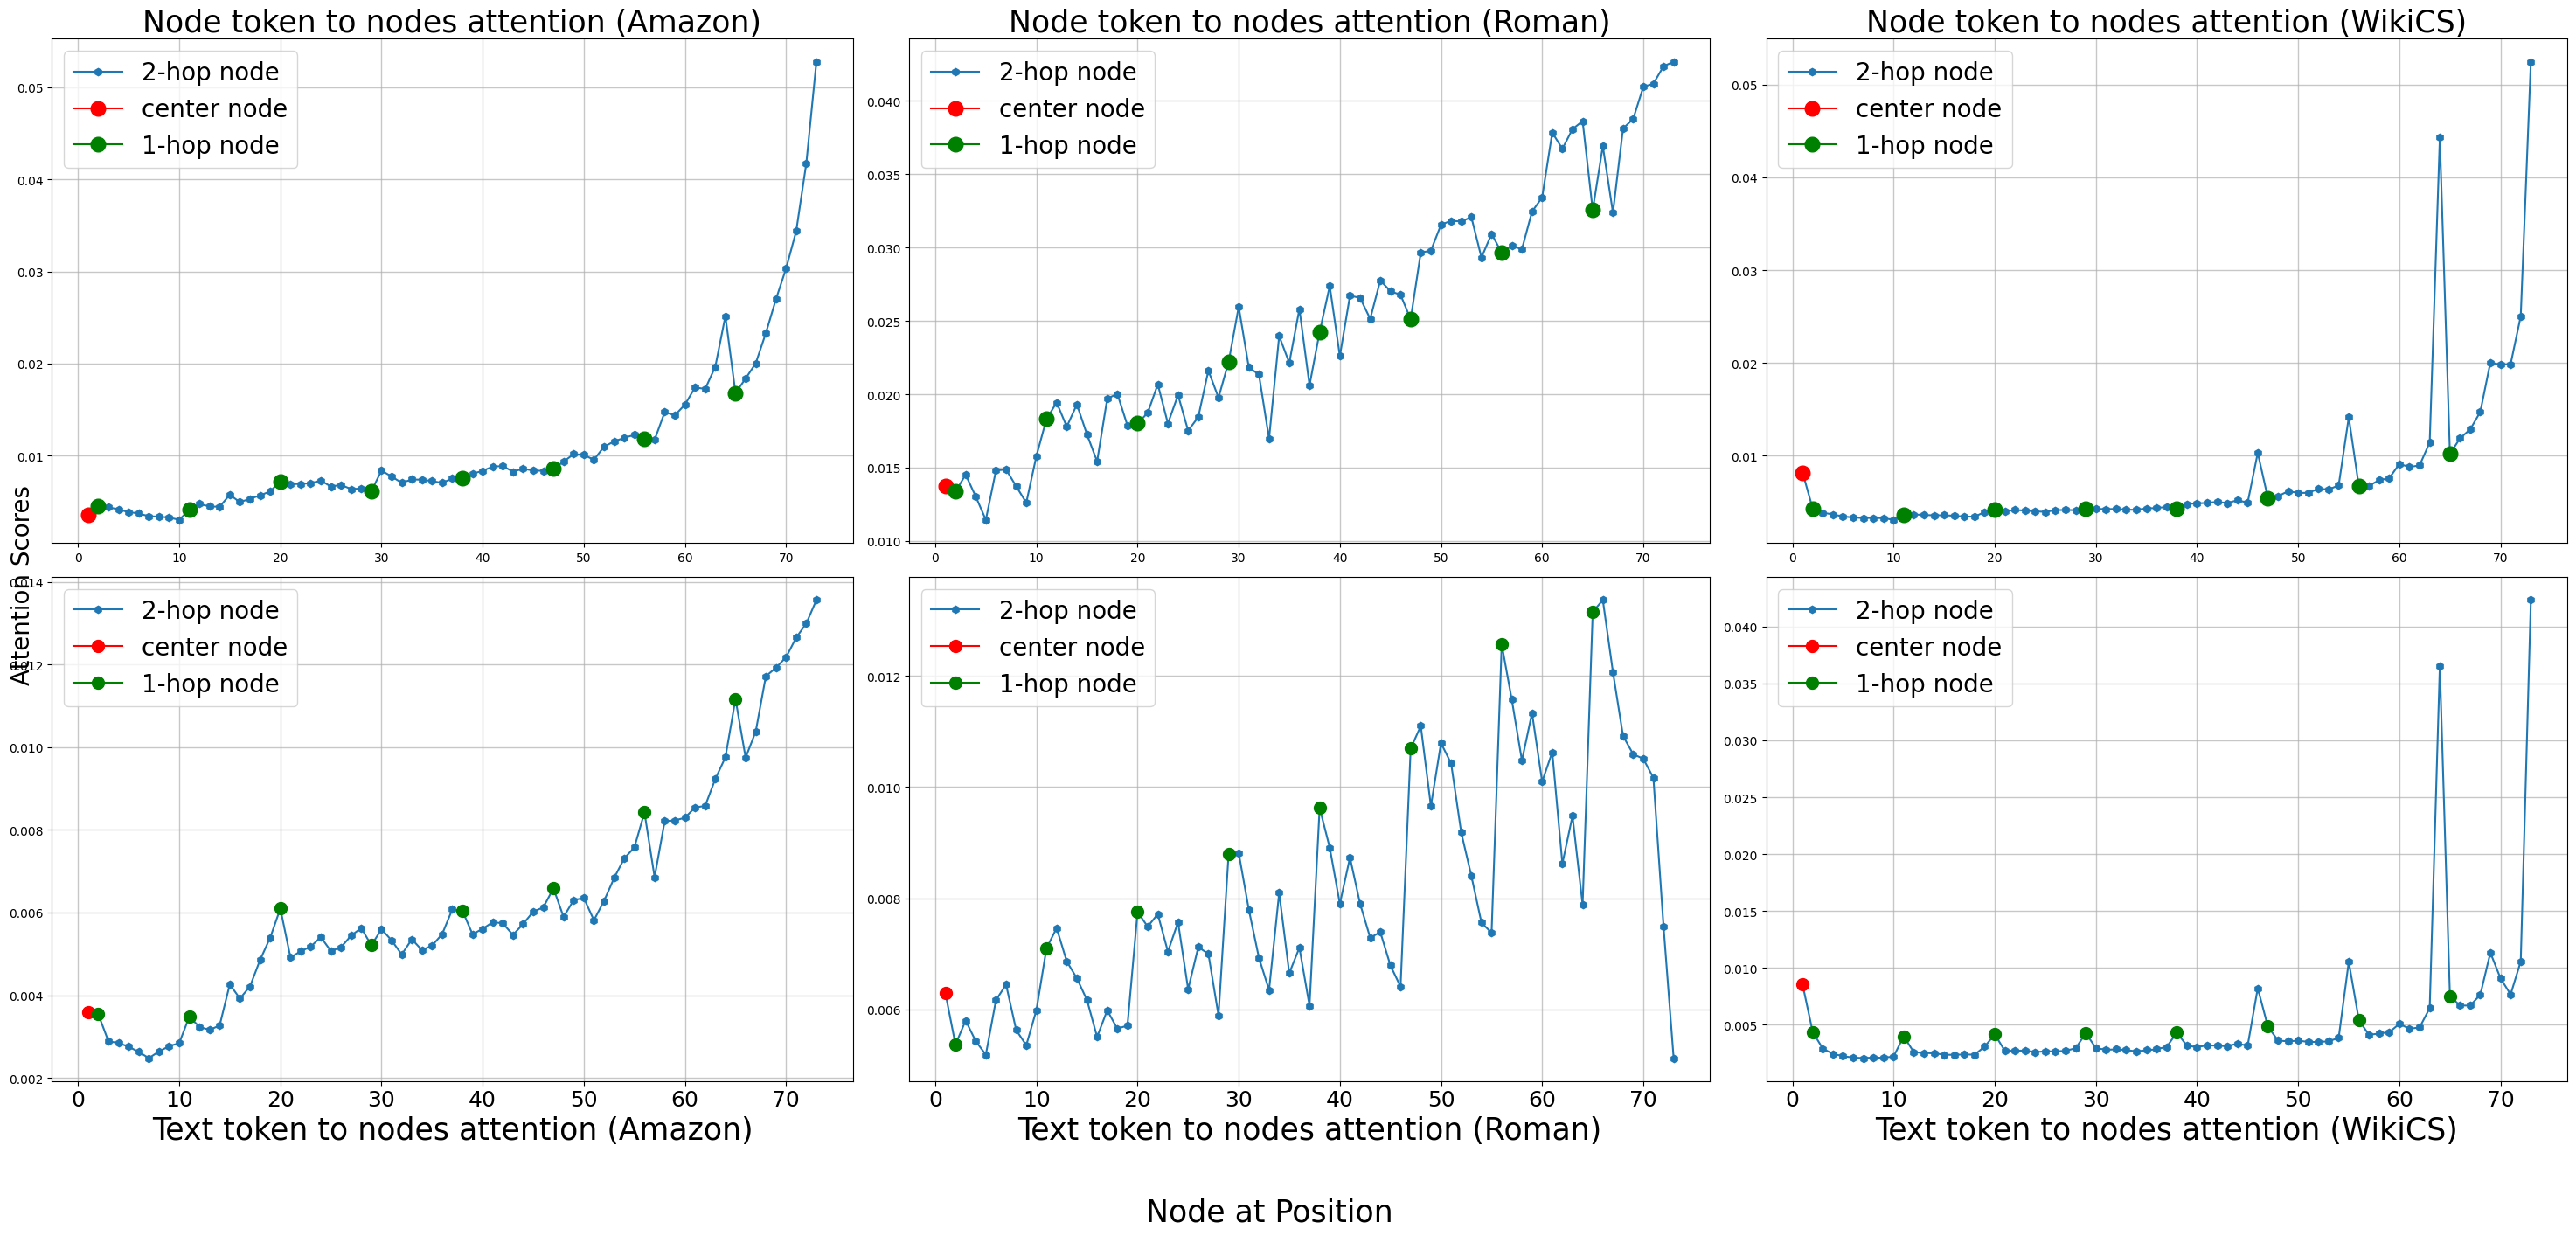

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 假设 load_attention_weights 和 prepare_attention_data 函数已经定义好
# 以及 node_index_dict 和 text_index_dict 已经根据数据集准备好了

datasets = ['amazon_ratings', 'roman_empire', 'wikics']
titles_node_to_node = ['Node token to nodes attention (Amazon)', 'Node token to nodes attention (Roman)', 'Node token to nodes attention (WikiCS)']
titles_text_to_node = ['Text token to nodes attention (Amazon)', 'Text token to nodes attention (Roman)', 'Text token to nodes attention (WikiCS)']

fig, axes = plt.subplots(2, 3, figsize=(30, 15))  # 修改了这里，使布局变为2x3

for idx, dataset in enumerate(datasets):
    all_attn = load_attention_weights(f'atten_pad_{dataset}')
    all_attn = torch.stack(all_attn)
    all_attn = all_attn.squeeze().view(-1, all_attn.shape[-3], all_attn.shape[-2], all_attn.shape[-1]).cpu()

    # 节点到节点的注意力
    node2node_attn_mean_column = prepare_attention_data(all_attn, node_index_dict[dataset], node_index_dict[dataset])

    # 文本到节点的注意力
    text2node_attn_mean_column = prepare_attention_data(all_attn, text_index_dict[dataset], node_index_dict[dataset])

    positions = np.arange(1, len(node2node_attn_mean_column) + 1)

    # 绘制第一个图表（节点到节点）
    ax1 = axes[0, idx]  # 修改了这里，使图表位于第一行
    line1 = ax1.plot(positions, node2node_attn_mean_column, marker='h', label='2-hop node')[0]
    ax1.plot(positions[0], node2node_attn_mean_column[0], marker='o', color='red', markersize=12, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax1.plot(pos, node2node_attn_mean_column[pos-1], marker='o', color='green', markersize=12, label='1-hop node' if i == 0 else "")
    
    # 设置标题
    ax1.set_title(titles_node_to_node[idx], fontsize=25)
    ax1.grid(True, which='both', linestyle='-', linewidth=1, alpha=0.7)
    ax1.legend(frameon=True, fontsize=20)
    
    # # 只有最左边一列的子图设置Y轴标签
    # if idx == 0:
    #     ax1.set_ylabel('Attention Scores', fontsize=20)
    #     ax1.tick_params(axis='y', labelsize=18)  # 增加Y轴刻度标签大小
    
    # # 只有最下面一行的子图设置X轴标签
    # if idx == len(datasets) - 1:
    #     ax1.set_xlabel('Node at Position', fontsize=20)
    #     ax1.tick_params(axis='x', labelsize=18)  # 增加X轴刻度标签大小

    # 绘制第二个图表（文本到节点）
    ax2 = axes[1, idx]  # 修改了这里，使图表位于第二行
    line2 = ax2.plot(positions, text2node_attn_mean_column, marker='h', label='2-hop node')[0]
    ax2.plot(positions[0], text2node_attn_mean_column[0], marker='o', color='red', markersize=10, label='center node')
    for i, pos in enumerate(positions[1::9]):
        ax2.plot(pos, text2node_attn_mean_column[pos-1], marker='o', color='green', markersize=10, label='1-hop node' if i == 0 else "")
    
    # 设置标题
    ax2.set_xlabel(titles_text_to_node[idx], fontsize=25)
    ax2.grid(True, which='both', linestyle='-', linewidth=1, alpha=0.7)
    ax2.legend(fontsize=20)
    
    # 设置X轴标签
    # ax2.set_xlabel('Node at Position', fontsize=20)
    ax2.tick_params(axis='x', labelsize=18)  # 增加X轴刻度标签大小
    
    # # 只有最左边一列的子图设置Y轴标签
    # if idx == 0:
    #     ax2.set_ylabel('Attention Scores', fontsize=20)
    #     ax2.tick_params(axis='y', labelsize=18)  # 增加Y轴刻度标签大小

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node at Position', fontsize=25)
fig.supylabel('Attention Scores', fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局以适应共享标签

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = "attention_score2nodes.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

plt.show()

# B.2

In [5]:
def get_total_grad_norm(parameters):
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_first_and_second_order_neighbors(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    return neighbors_dict

def random_get_first_and_second_order_neighbors_I(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 在完成邻居获取后，尝试添加扰动
        if len(first_order_neighbors) > 1:
            # 随机选择两个一阶邻居
            selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
            
            # 交换它们的二阶邻居列表
            first_order_neighbors[selected_neighbors[0]], first_order_neighbors[selected_neighbors[1]] = \
                first_order_neighbors[selected_neighbors[1]].copy(), first_order_neighbors[selected_neighbors[0]].copy()
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_II(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        iter_num=0
        while iter_num<=10:
            if len(first_order_neighbors) > 1:
                # 随机选择两个一阶邻居
                selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
                # 为这两个邻居随机选择一些二阶邻居进行交换
                swap_size = min(len(first_order_neighbors[selected_neighbors[0]]), len(first_order_neighbors[selected_neighbors[1]]))
                if swap_size > 0:
                    swap_indices = random.sample(range(swap_size), swap_size)
                    for idx in swap_indices:
                        first_order_neighbors[selected_neighbors[0]][idx], first_order_neighbors[selected_neighbors[1]][idx] = \
                            first_order_neighbors[selected_neighbors[1]][idx], first_order_neighbors[selected_neighbors[0]][idx]
            iter_num+=1
        
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_III(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    all_nodes = list(id_mapping.values())
    
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将所有的一阶和二阶节点收集到一个列表中
        all_neighbors = list(first_order_neighbors.keys()) + [neighbor for sublist in first_order_neighbors.values() for neighbor in sublist]
        
        print(first_order_neighbors)
        
        # 打乱所有节点
        np.random.shuffle(all_neighbors)
        
        # 重新分配一阶和二阶节点
        new_first_order_neighbors = all_neighbors[:len(first_order_neighbors)]
        new_second_order_neighbors = all_neighbors[len(first_order_neighbors):]
        
        # 构建新的邻居字典
        new_neighbors_dict = {node: [] for node in new_first_order_neighbors}
        
        for i, node in enumerate(new_first_order_neighbors):
            new_neighbors_dict[node] = new_second_order_neighbors[i * len(first_order_neighbors):(i + 1) * len(first_order_neighbors)]
        
        neighbors_dict[node_id.item()] = new_neighbors_dict
    
    return neighbors_dict


def get_all_neighbors(data, input_ids):
    # 获取所有输入节点的一阶和二阶邻居
    all_neighbors = {}
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        all_neighbors[node_id.item()] = first_order_neighbors
    
    return all_neighbors

def random_get_first_and_second_order_neighbors_IV(data, input_ids):
    all_neighbors = get_all_neighbors(data, input_ids)  # 获取整个 batch 的邻居信息
    neighbors_dict = {}

    for center_node_id in input_ids:
        temp_neighbors = copy.deepcopy(all_neighbors[center_node_id.item()])
        other_center_nodes = set(input_ids) - {center_node_id}
        
        # 收集其他中心节点的所有一阶和二阶邻居作为不相关节点池
        unrelated_nodes_pool = []
        for other_node_id in other_center_nodes:
            unrelated_nodes_pool.extend(list(all_neighbors[other_node_id.item()].keys()))
            for second_order_neighbors in all_neighbors[other_node_id.item()].values():
                unrelated_nodes_pool.extend(second_order_neighbors)
        
        # 确保不相关节点池中的节点不在当前中心节点的邻居列表中
        unrelated_nodes_pool = list(set(unrelated_nodes_pool) - set(temp_neighbors.keys()) - set([node for sublist in temp_neighbors.values() for node in sublist]))
        
        iter_num=0
        while iter_num<=10:
            if unrelated_nodes_pool:  # 如果存在不相关节点，则进行替换
                # 随机选择一定数量的不相关节点
                num_unrelated_to_replace = min(len(unrelated_nodes_pool), len(temp_neighbors)) // 2  # 可根据需要调整比例

                unrelated_nodes_sample = random.sample(unrelated_nodes_pool, num_unrelated_to_replace)

                # 对于每一个选中的不相关节点，随机决定是替换一阶还是二阶邻居
                for unrelated_node in unrelated_nodes_sample:
                    if random.choice([True, False]):  # 替换一阶邻居
                        replaced_node = random.choice(list(temp_neighbors.keys()))
                        temp_neighbors[unrelated_node] = temp_neighbors.pop(replaced_node)
                    else:  # 替换二阶邻居
                        if temp_neighbors:
                            first_order_node, second_order_neighbors = random.choice(list(temp_neighbors.items()))
                            if second_order_neighbors:
                                replaced_node = random.choice(second_order_neighbors)
                                second_order_neighbors.remove(replaced_node)
                                second_order_neighbors.append(unrelated_node)
            iter_num+=1
        neighbors_dict[center_node_id.item()] = temp_neighbors
    
    return neighbors_dict

In [6]:
def pre_data(args):
    if args.dataset=='ogbn-arxiv':
        dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/', transform=T.ToSparseTensor())
        data=dataset[0]
        data.adj_t = data.adj_t.to_symmetric()
        split_idx = dataset.get_idx_split()
        train_loader = NeighborLoader(data, input_nodes=split_idx["train"],
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      ,batch_size=args.batch_size, 
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["valid"],
                                      batch_size=args.batch_size,
                                         num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      , shuffle=False,num_workers=args.num_workers)
        test_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["test"],
                                     batch_size=args.batch_size,
                                    num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                     , shuffle=False,num_workers=args.num_workers)
        
    if args.dataset=='deezer-europe':
        deezer = scipy.io.loadmat(f'./deezer_europe/deezer-europe.mat')
        adj_t= SparseTensor(row=torch.tensor(deezer['A'].tocoo().row).to(torch.long), col=torch.tensor(deezer['A'].tocoo().col).to(torch.long),sparse_sizes=(len(deezer['label'][0]), len(deezer['label'][0])))
        data= Data(x=torch.tensor(deezer['features'].toarray()).to(torch.float32), adj_t=adj_t,y=torch.tensor(deezer['label']).squeeze())
        data.adj_t = data.adj_t.to_symmetric()
        # 获取节点总数
        num_nodes = len(data.y)
        # 定义数据集划分比例
        train_ratio = 0.5
        val_ratio = 0.25
        test_ratio = 0.25
        # 计算每种数据集包含的节点数
        num_train = int(num_nodes * train_ratio)
        num_val = int(num_nodes * val_ratio)
        num_test = num_nodes - num_train - num_val
        # 随机排列节点索引
        node_indices = torch.randperm(num_nodes)
        # 切分索引
        train_indices = node_indices[:num_train]
        val_indices = node_indices[num_train:num_train + num_val]
        test_indices = node_indices[num_train + num_val:]

        train_loader = NeighborLoader(data, input_nodes=train_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=True,num_workers=args.num_workers)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)    
    if args.dataset in ['roman_empire','amazon_ratings','questions']:
        file_path = f'./{args.dataset}/{args.dataset}_right.npz'
        data = np.load(file_path)
        
        # 切分索引
        train_indices = np.where(data['train_masks'][0])[0]
        val_indices = np.where(data['val_masks'][0])[0]
        test_indices = np.where(data['test_masks'][0])[0]
        
        
        # data = np.load('./roman_empire/roman_empire.npz')
        adj_t= SparseTensor(row=torch.tensor(data['edges']).t()[0].to(torch.long), col=torch.tensor(data['edges']).t()[1].to(torch.long),sparse_sizes=(len(data['node_labels']),len(data['node_labels']) ))
        data= Data(x=torch.tensor(data['node_features']), adj_t=adj_t,y=torch.tensor(data['node_labels']))
        data.adj_t = data.adj_t.to_symmetric()


        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
    if args.dataset in ['pubmed']:
        file_path = f'./{args.dataset}/data.pt'
        data = torch.load(file_path)
        
        data.adj_t = data.adj_t.to_symmetric()
        
        data.y=torch.tensor(data.y)
        
        node_id = np.arange(data.num_nodes)
        np.random.shuffle(node_id)

        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
            
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
    if args.dataset in ['wikics']:
        file_path = f'./{args.dataset}/data_token_right_10.pt'
        
        data = torch.load(file_path)
        
        node_id = np.arange(data.num_nodes)
        
        
        random.shuffle(node_id)
        
        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
        
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)

    
    return train_loader,valid_loader,test_loader,data

In [16]:
def get_args():
    parser = argparse.ArgumentParser(description="PyTorch PYG implementation")
    parser.add_argument('--seed', type=int, default=42, help='random seed')

    # CPU/GPU
    parser.add_argument("--num_workers", default=6, type=int)
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument('--device', default='cuda:0')
    
    """LLM Config"""
    parser.add_argument('--backbone', type=str, default='./llama2-7b-hf')
    parser.add_argument('--tokenizer', type=str, default='AutoTokenizer')
    parser.add_argument('--max_text_length', type=int, default=4096)
    parser.add_argument('--lora_r', type=int, default=64)
    parser.add_argument('--lora_alpha', type=int, default=128)
    parser.add_argument('--lora_dropout', type=int, default=0.05)

    
    """LLM Training"""
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--warmup_ratio', type=float, default=0.05)
    parser.add_argument('--weight_decay', type=float, default=0.005)
    parser.add_argument('--clip_grad_norm', type=float, default=1.0)
    parser.add_argument('--gradient_accumulation_steps', type=int, default=8)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--adam_eps', type=float, default=1e-8)
    parser.add_argument('--adam_beta1', type=float, default=0.9)
    parser.add_argument('--adam_beta2', type=float, default=0.999)
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--dropout', type=float, default=0.5)
    parser.add_argument(
        "--num_neighbors",
        type=str,
        default="8,8",
        help="Number of samples for each layer in SAGE. Length = num_layers",
    )
    parser.add_argument(
        "--perturbation",
        type=int,
        default=0,
        help="perturbation type",
    )
    """Dataset"""
    parser.add_argument('--do_lower_case', action='store_true')
    parser.add_argument("--dataset", type=str, default="wikics", help="Dataset")
    parser.add_argument("--data_path", type=str, default="./data", help="Path to data")
    parser.add_argument("--num_nodes", type=int, default="11701", help="the number of nodes")

    """Global """
    parser.add_argument("--train", type=bool, default="True", help="training ")
    parser.add_argument("--test", type=bool, default="False", help="testing ")
    args = parser.parse_args(args=[])

    
    return args

In [17]:
class Trainer():
    def __init__(self,args):
        self.args=args
        if args.dataset=='wikics':
            template={}
            template['train']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        if args.dataset=='roman_empire':
            template={}
            template['train']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>: {}"
            template['test']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>:"
        if args.dataset=='amazon_ratings':
            template={}
            template['train']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>: {}"
            template['test']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>:"
        if args.dataset=='pubmed':
            template={}
            template['train']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        
        self.template=template
        
        self.tokenizer = self.get_tokenizer()
        self.train_loader, self.valid_loader, self.test_loader,self.data=pre_data(self.args)
        
#         self.model= self.get_model()
        
#         self.optimizer, self.lr_scheduler=self.get_optimizer()
        
    def get_tokenizer(self):
        tokenizer = LlamaTokenizer.from_pretrained(self.args.backbone, max_length=self.args.max_text_length,do_lower_case=self.args.do_lower_case)
        tokenizer.padding_side = "left"
        tokenizer.pad_token = tokenizer.unk_token
        
        new_tokens=[ 'node_'+str(i) for i in range(self.args.num_nodes)]
        
        tokenizer.add_tokens(new_tokens)
        
        return tokenizer
    def get_optimizer(self):
        
        batch_per_epoch = len(self.train_loader)
        t_total = batch_per_epoch // self.args.gradient_accumulation_steps * self.args.epoch
        warmup_ratio = self.args.warmup_ratio
        warmup_iters = int(t_total * warmup_ratio)
        
        print("Batch per epoch: %d" % batch_per_epoch)
        print("Total Iters: %d" % t_total)
        print('Warmup ratio:', warmup_ratio)
        print("Warm up Iters: %d" % warmup_iters)
        
        
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": self.args.weight_decay,
                    'lr': self.args.lr,
                },
                # 这个组包含了bias和LayerNorm的所有参数，不应用权重衰减
                {
                    "params":[p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": 0.0,
                    'lr': self.args.lr,
                }

        ]
        optim = AdamW(optimizer_grouped_parameters,
                          lr=self.args.lr, eps=self.args.adam_eps)
        lr_scheduler = get_linear_schedule_with_warmup(optim, warmup_iters, t_total)
        
        return optim, lr_scheduler
    
    def get_model(self):
        model = AutoModelForCausalLM.from_pretrained(
                                    self.args.backbone,
                                    load_in_8bit=True,
                                    torch_dtype=torch.float16,
                                    use_safetensors=False,
                                    device_map='cuda:0'
                                )
        
        # model_embed=model.model.embed_tokens.weight.data
        
        model.resize_token_embeddings(32000+self.args.num_nodes)
        
        model.model.embed_tokens.weight.data[-self.args.num_nodes:]=self.data.x
        
        model = prepare_model_for_kbit_training(model)
        
        lora_config = LoraConfig(
            r=self.args.lora_r,
            lora_alpha=self.args.lora_alpha,
            lora_dropout=self.args.lora_dropout,
            bias="none",
            task_type="CAUSAL_LM",
            # target_modules=['q_proj','k_proj']
            target_modules=['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj']
            
        )
        
        model= get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        
        return model
    
    def get_prompt(self,batch,is_training=True):
        #将label又数字id形式转化为文字
        if self.args.dataset=='ogbn-arxiv':
            dict_labelid2categeory=load_pickle('dict_labelid2arxivcategeory.pkl')
        if self.args.dataset=='deezer-europe':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='female'
            dict_labelid2categeory[1]='male'
        if self.args.dataset=='roman_empire':
            dict_labelid2categeory={}
            
            dict_labelid2categeory = {1: 'prepositional object',2: 'preposition',3: 'determiner',4: 'adjectival',5: 
                                    'conjunct',6: 'nominal subject',7: 'coordinating conjunction',0: 'root',
                                    8: 'direct object',9: 'adverbial',10: 'compound',11: 'auxiliary',
                                    12: 'appositional',13: 'passive auxiliary',14: 'passive nominal subject',15:
                                    'possession',16: 'relative clause',17: 'other'}
            
        if self.args.dataset=='amazon_ratings':
            
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='Very Positive'
            dict_labelid2categeory[1]='Positive'
            dict_labelid2categeory[2]='Neutral'
            dict_labelid2categeory[3]='Negative'
            dict_labelid2categeory[4]='Very Negative'
            
        if self.args.dataset=='questions':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='activate'
            dict_labelid2categeory[1]='no'
        
        if self.args.dataset=='wikics':
            dict_labelid2categeory={
            0: 'Computational linguistics',
            1: 'Databases',
            2: 'Operating systems',
            3: 'Computer architecture',
            4: 'Computer security',
            5: 'Internet protocols',
            6: 'Computer file systems',
            7: 'Distributed computing architecture',
            8: 'Web technology',
            9: 'Programming language topics'}
        if self.args.dataset=='pubmed':
            dict_labelid2categeory={
            0: 'Diabetes Mellitus, Experimental',
            1: 'Diabetes Mellitus Type 1',
            2: 'Diabetes Mellitus Type 2'}
        if self.args.perturbation==0:
            neighbors_dict=get_first_and_second_order_neighbors(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==1:
            neighbors_dict=random_get_first_and_second_order_neighbors_I(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==2:
            neighbors_dict=random_get_first_and_second_order_neighbors_II(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==3:
            neighbors_dict=random_get_first_and_second_order_neighbors_III(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==4:
            neighbors_dict=random_get_first_and_second_order_neighbors_IV(batch,batch.n_id[:batch.batch_size])
            
        batch_text=[]
        labels=[]

        for i,label in zip(neighbors_dict.keys(),batch.y[:batch.batch_size]):
            label=dict_labelid2categeory[label.item()]
            connect_text='['
            text=''
            connect_text_list=[]
            for j in range(8):
                keys=list(neighbors_dict[i].keys())
                if  j < len(keys):
                    j = keys[j]
                    shuffled_indices = list(range(8))
                    random.shuffle(shuffled_indices)

                    nodes = ['node_' + str(neighbors_dict[i][j][idx]) if idx < len(neighbors_dict[i][j]) else '<unk>' for idx in shuffled_indices]

                    connect_text_list.append(f'node_{j} is connected [{",".join(nodes)} ] ,')
                else:
                    connect_text_list.append('<unk>' + ' is connected [' + ','.join('<unk>' for item in range(8)) + ' ] ,')
            random.shuffle(connect_text_list)
            connect_text += ''.join(connect_text_list)

            connect_text=connect_text[:-1]+']'
            if is_training :
                text = self.template['train'].format('node_'+str(i),connect_text,'node_'+str(i),label)+'</s>'
            else:
                text = self.template['test'].format('node_'+str(i),connect_text,'node_'+str(i))
            batch_text.append(text)
            labels.append(label+'</s>')
        
        input_ids=self.tokenizer(batch_text,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        attention_mask=self.tokenizer(batch_text,padding='longest',
                                      max_length=self.args.max_text_length,return_tensors="pt")['attention_mask']
        
        #去掉开头的字符
        label_ids=self.tokenizer(labels,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        
        attention_mask[input_ids.eq(0)]=0   
        
        if is_training:
            
            label_ids[label_ids.eq(self.tokenizer.pad_token_id)]=-100
            label_ids[:,-1]=2
            label_ids[label_ids.eq(1)]=-100
            label_ids=torch.cat((torch.full((label_ids.size(0), input_ids.size(-1)-label_ids.size(-1)), -100),
                              label_ids),dim=-1)
        else:
            # 测试阶段可能不需要生成标签
            label_ids = labels
        
        return input_ids, attention_mask, label_ids,neighbors_dict
        
    def load_checkpoint(self, ckpt_path,proj_path):
        results = self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
        results = self.proj_model.load_state_dict(torch.load(proj_path), strict=True)
        if self.verbose:
            print('Model loaded from ', ckpt_path)
            print('Model loaded from ', proj_path)
            print(results)
    def train(self):
        
        self.model.train()
        
        pbar = tqdm(total=len(self.train_loader), ncols=275)
        for epoch in range(self.args.epoch):
            
            for step_i, batch in enumerate(self.train_loader):
                
                input_ids, attention_mask, labels, neighbors_dict=self.get_prompt(batch,True)
                
                attention_mask=attention_mask.to(self.args.device)
                
                labels=labels.to(self.args.device)
                
                input_ids=input_ids.to(self.args.device)
                
                output= self.model(
                    input_ids=input_ids,
                    labels=labels,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True)
                
                loss = output['loss']/ self.args.gradient_accumulation_steps
                
                
                loss.backward()
                
                
                if step_i % self.args.gradient_accumulation_steps == 0:
                    # 在训练循环中调用
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.clip_grad_norm)
                    
                    self.optimizer.step()  # Update
                    self.lr_scheduler.step()
                    for param in self.model.parameters():
                        param.grad = None
                if step_i % 1 == 0:
                    lr = self.lr_scheduler.get_lr()[0]
                    desc_str = f'Epoch {epoch} | LR {lr:.6f} |'
                    desc_str += f' Loss:{loss:.3f}'
                    pbar.set_description(desc_str)
                    pbar.update(1)
        pbar.close()
            
        torch.save(self.model.state_dict(),"llmcom_{}_end_{}_pad.pth".format(self.args.epoch,self.args.dataset))
                                         
    def test(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}_pad.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            acc_list=[]
            for time in range(4):
                with torch.no_grad():
                    print('len of val_loader is {}'.format(len(self.test_loader)))
                    acc=0
                    for step_i, batch in tqdm(enumerate(self.test_loader)):

                        input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                        attention_mask=attention_mask.to(self.args.device)

                        input_ids=input_ids.to(self.args.device)

                        embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                        output= self.model.generate(inputs_embeds=embeds,
                                                    attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                        output=self.tokenizer.batch_decode(output)
                        # print(output)
                        print(labels)
                        for i in range(len(output)):
                            if labels[i] in output[i]:
                               acc+=1
                        print(acc)
                    acc_list.append(acc)
            print(acc_list)
    def test_perturbation(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}_pad.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            
            acc_list_perbation=[]
            for perturbation in range(1,5):
                print('test_perturbation is {}'.format(perturbation))
                self.args.perturbation=perturbation
                acc_list=[]
                for time in range(4):
                    with torch.no_grad():
                        print('len of val_loader is {}'.format(len(self.test_loader)))
                        acc=0
                        for step_i, batch in tqdm(enumerate(self.test_loader)):

                            input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                            attention_mask=attention_mask.to(self.args.device)

                            input_ids=input_ids.to(self.args.device)

                            embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                            output= self.model.generate(inputs_embeds=embeds,
                                                        attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                            output=self.tokenizer.batch_decode(output)
                            # print(output)
                            print(labels)
                            for i in range(len(output)):
                                if labels[i] in output[i]:
                                   acc+=1
                            print(acc)
                        acc_list.append(acc)
                print(acc_list)
                acc_list_perbation.append(acc_list)
            print(acc_list_perbation)  

In [18]:
def set_random_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 设置一个固定的随机种子值
seed_value = 42
set_random_seed(seed_value)

In [19]:
args=get_args()

In [20]:
trainer=Trainer(args)

In [21]:
ite=iter(trainer.test_loader)
batch=next(ite)
input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
attention_mask = attention_mask.to(trainer.args.device)
input_ids = input_ids.to(trainer.args.device)
node_index=torch.where((input_ids>=32000)|(input_ids==0))[1][:-1].cpu()
text_index=torch.where(~((input_ids>=32000)|(input_ids==0)))[1].cpu()

In [22]:
# node_index_dict={}
# text_index_dict={}

In [23]:
node_index_dict[trainer.args.dataset]=node_index

In [24]:
text_index_dict[trainer.args.dataset]=text_index

In [2]:
# 定义一个函数来读取所有存储的注意力权重文件
def load_attention_weights(directory):
    # 获取目录中的所有.pth文件
    files = [f for f in os.listdir(directory) if f.endswith('.pth')]
    
    # 加载所有.pth文件中的注意力权重
    attention_weights = []
    for file_name in files:
        file_path = os.path.join(directory, file_name)
        loaded_data = torch.load(file_path)
        attention_weights.append(loaded_data)
    
    return attention_weights


In [3]:
def masked_mean(tensor, dim=0, keepdim=False):
    """
    计算张量沿指定维度的平均值，忽略值为0的元素。
    
    参数:
        tensor (torch.Tensor): 输入张量。
        dim (int 或 tuple of ints): 沿此维度计算平均值。默认是第一个维度（0）。
        keepdim (bool): 是否保持输出张量的维度与输入相同。默认是 False。
    
    返回:
        torch.Tensor: 平均后的张量。
    """
    # 创建一个布尔掩码，标记非零元素的位置
    mask = tensor != 0
    
    # 计算每个位置的非零元素数量，避免除以0的情况
    count = mask.sum(dim=dim, keepdim=keepdim).float()
    count[count == 0] = 1  # 防止除以0
    
    # 使用掩码选择非零元素并求和
    sum_masked = torch.where(mask, tensor, torch.tensor(0.0, device=tensor.device)).sum(dim=dim, keepdim=keepdim)
    
    # 计算平均值
    mean_masked = sum_masked / count
    
    return mean_masked


In [38]:
dataset=trainer.args.dataset

In [174]:
dataset='amazon_ratings'

In [175]:
# all_attn = torch.load(f'atten_pad_{dataset}').squeeze()
all_attn=load_attention_weights(f'atten_pad_{dataset}')
all_attn=torch.stack(all_attn)
all_attn=all_attn.squeeze().view(-1,all_attn.shape[-3],all_attn.shape[-2],all_attn.shape[-1]).cpu()

In [176]:
all_attn.shape

torch.Size([300, 32, 241, 241])

In [177]:

node_index=node_index_dict[dataset]
text_index=node_index_dict[dataset]

In [178]:
node_attn=all_attn[:,:,:,node_index]

node_attn=node_attn[:,:,node_index,:]


In [119]:
# 计算忽略0值的平均注意力权重
node_attn = masked_mean(node_attn, dim=0)

# node_attn=node_attn.mean(axis=0)

In [120]:
# 创建数据
positions = np.arange(73)  # 文档的位置从1到111
# # 分类数据
center_node = positions[0]  # 中心节点
first_order_neighbors = positions[1::9]  # 每隔10个位置选取一个一阶邻居
combined_nodes=[center_node]
combined_nodes.extend(first_order_neighbors)

In [121]:
node_attn=node_attn[:,combined_nodes]
node_attn=node_attn[:,:,combined_nodes]

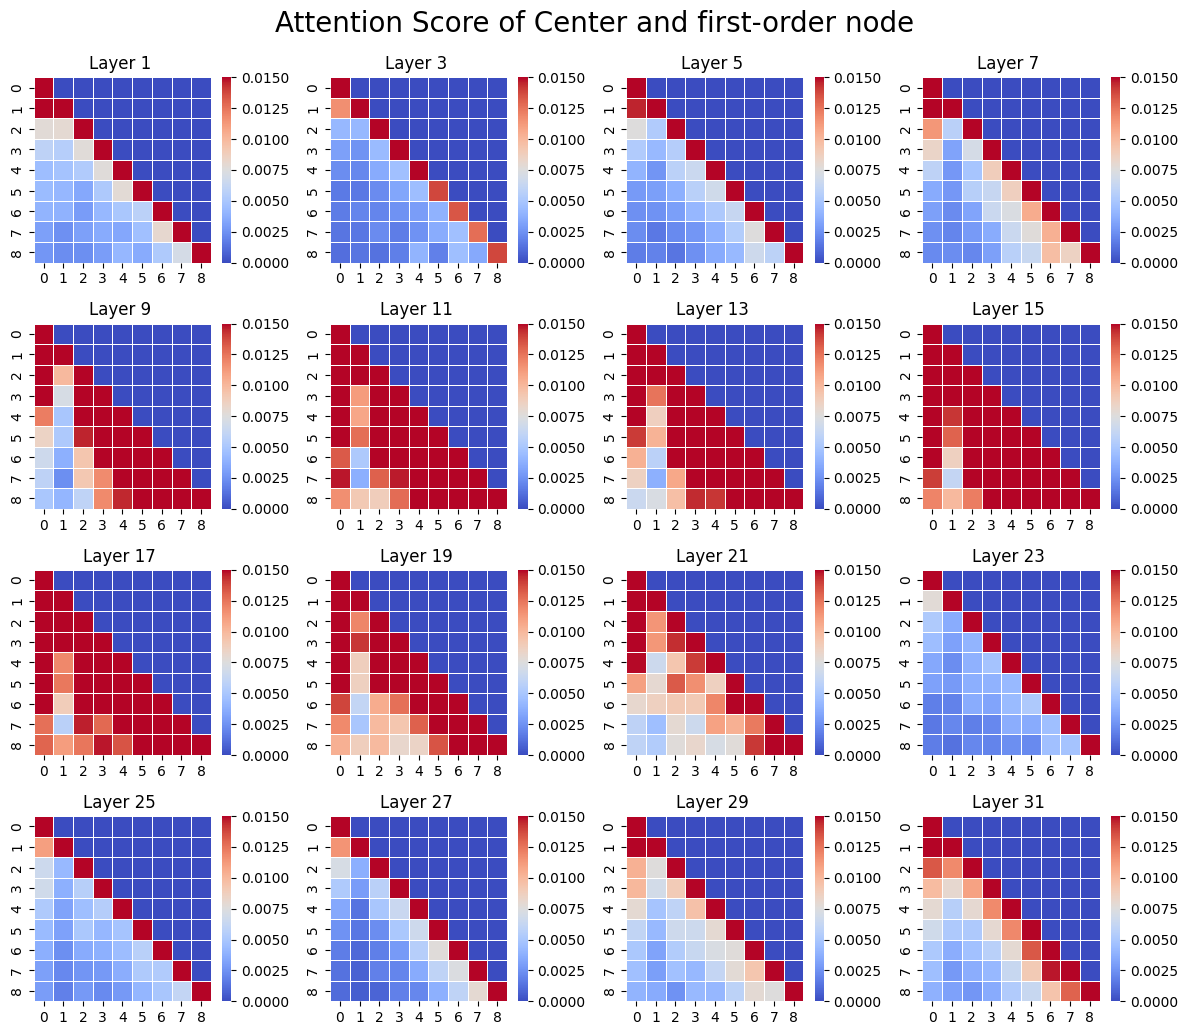

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 创建一个2x2的子图布局
f, axes = plt.subplots(4, 4, figsize=(12, 10))
axes = axes.flatten()  # 将2x2的数组展平为一维数组，方便遍历

# 循环绘制每个注意力矩阵
for i, ax in enumerate(axes):
    sns.heatmap(node_attn[2*i+1], annot=False, fmt=".3f", linewidths=.5, ax=ax, cmap='coolwarm', vmin=0, vmax=0.015)
    ax.set_title(f'Layer {2*i+1} ')
    


# 调整子图之间的间距
plt.tight_layout()
# 添加共享的X轴和Y轴标签
f.suptitle('Attention Score of Center and first-order node', fontsize=20,y=1.03)

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"different_layer_center_first_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

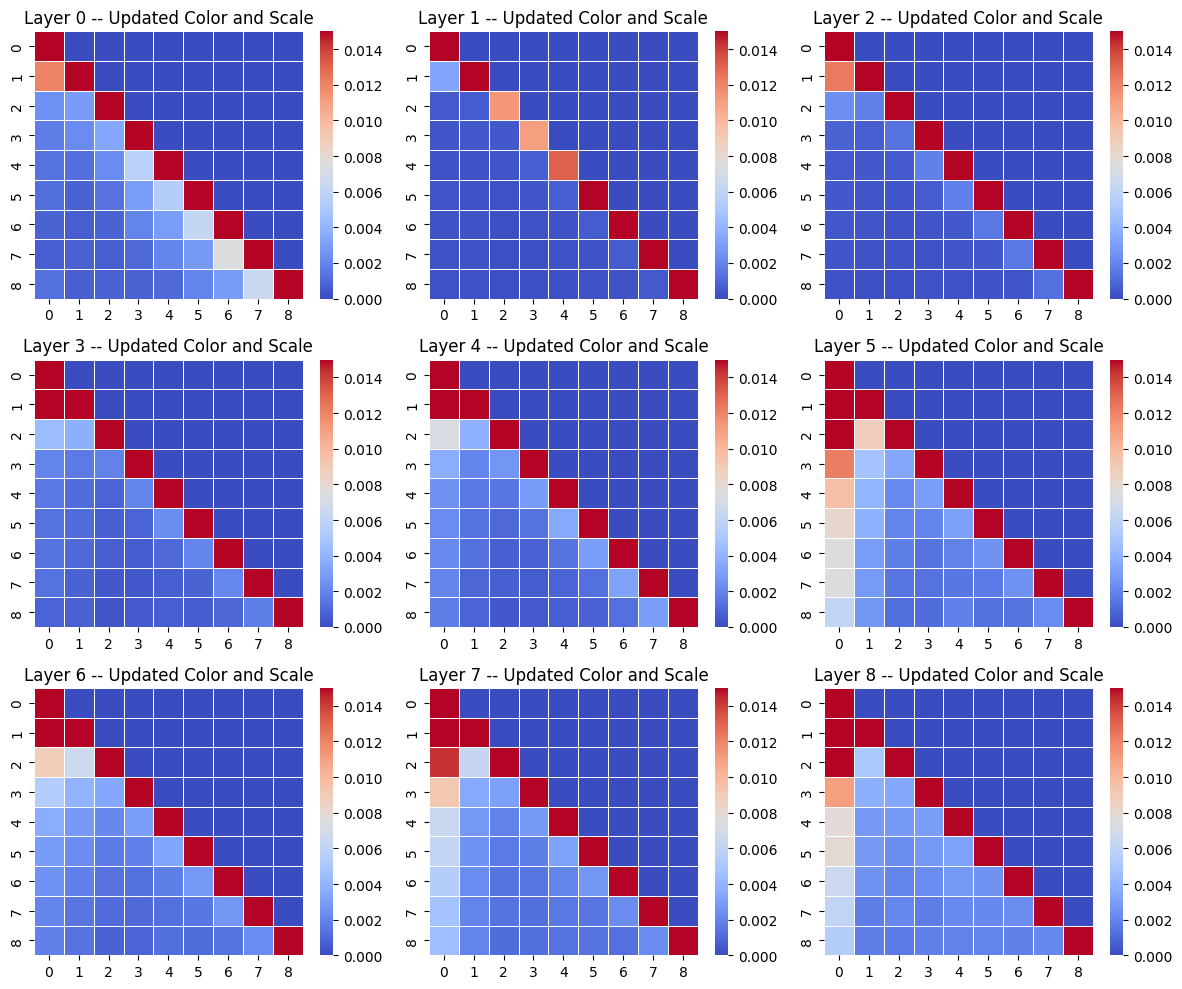

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 创建一个2x2的子图布局
f, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()  # 将2x2的数组展平为一维数组，方便遍历

# 循环绘制每个注意力矩阵
for i, ax in enumerate(axes):
    sns.heatmap(node_attn[2*i+1], annot=False, fmt=".3f", linewidths=.5, ax=ax, cmap='coolwarm', vmin=0, vmax=0.015)
    ax.set_title(f'Layer {i} -- Updated Color and Scale')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [180]:
node_attn=all_attn[:,:,:,node_index]

node_attn=node_attn[:,:,node_index,:]

# 计算忽略0值的平均注意力权重
node_attn = masked_mean(masked_mean(node_attn, dim=0), dim=0)

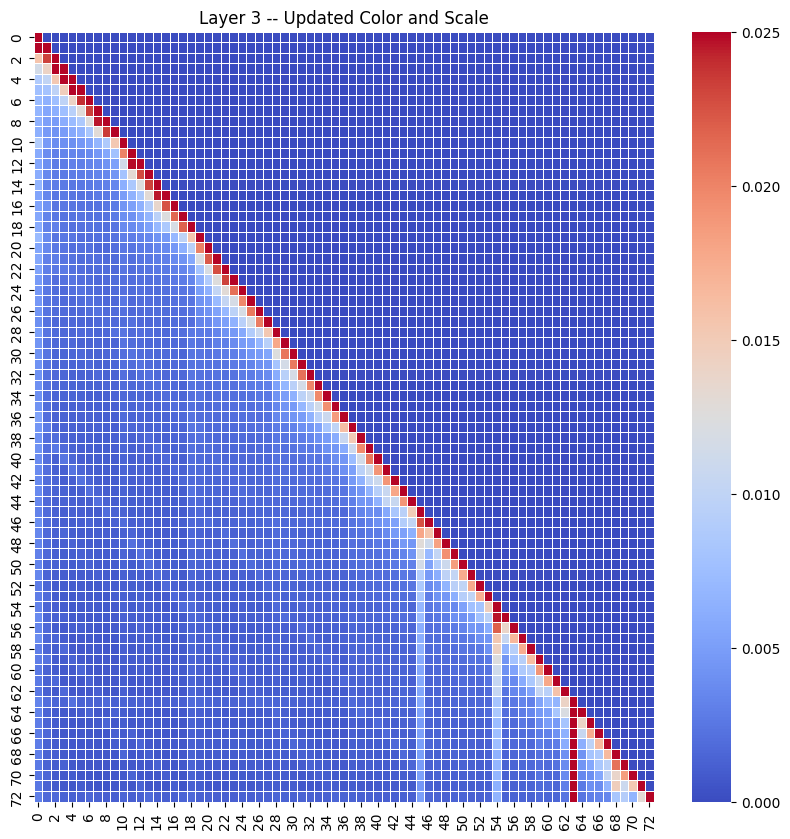

In [131]:
# 创建一个新的图形
plt.figure(figsize=(10, 10))

# 使用 seaborn 绘制热力图
sns.heatmap(node_attn, annot=False, fmt=".3f", linewidths=.5, cmap='coolwarm', vmin=0, vmax=0.025)

# 设置标题
plt.title(f'Layer {i} -- Updated Color and Scale')

# 显示图形
plt.show()

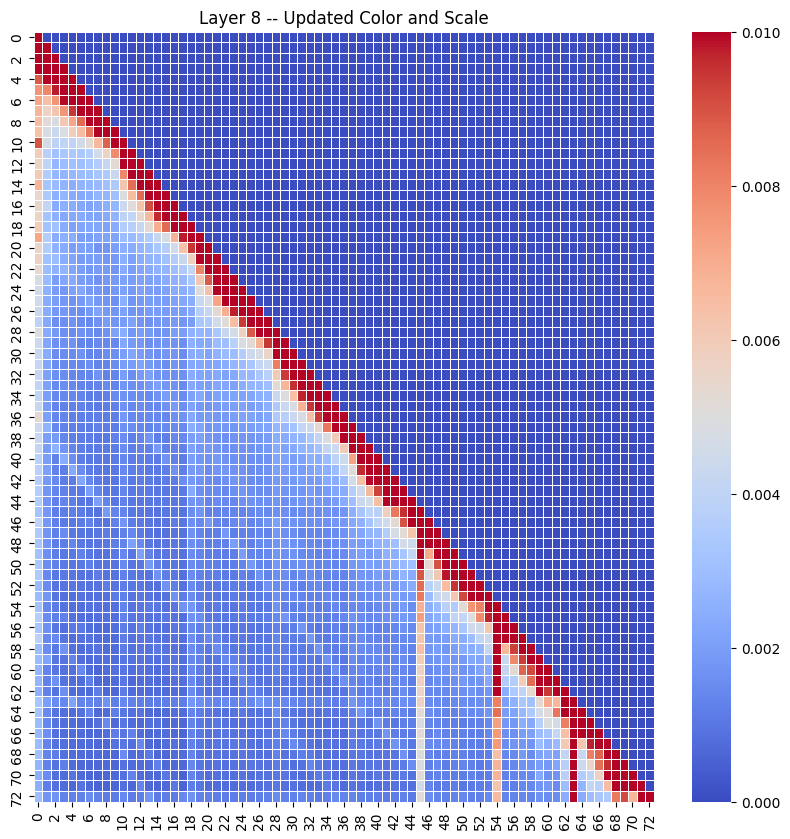

In [186]:
# 创建一个新的图形
plt.figure(figsize=(10, 10))

# 使用 seaborn 绘制热力图
sns.heatmap(node_attn, annot=False, fmt=".3f", linewidths=.5, cmap='coolwarm', vmin=0, vmax=0.01)

# 设置标题
plt.title(f'Layer {i} -- Updated Color and Scale')

# 显示图形
plt.show()

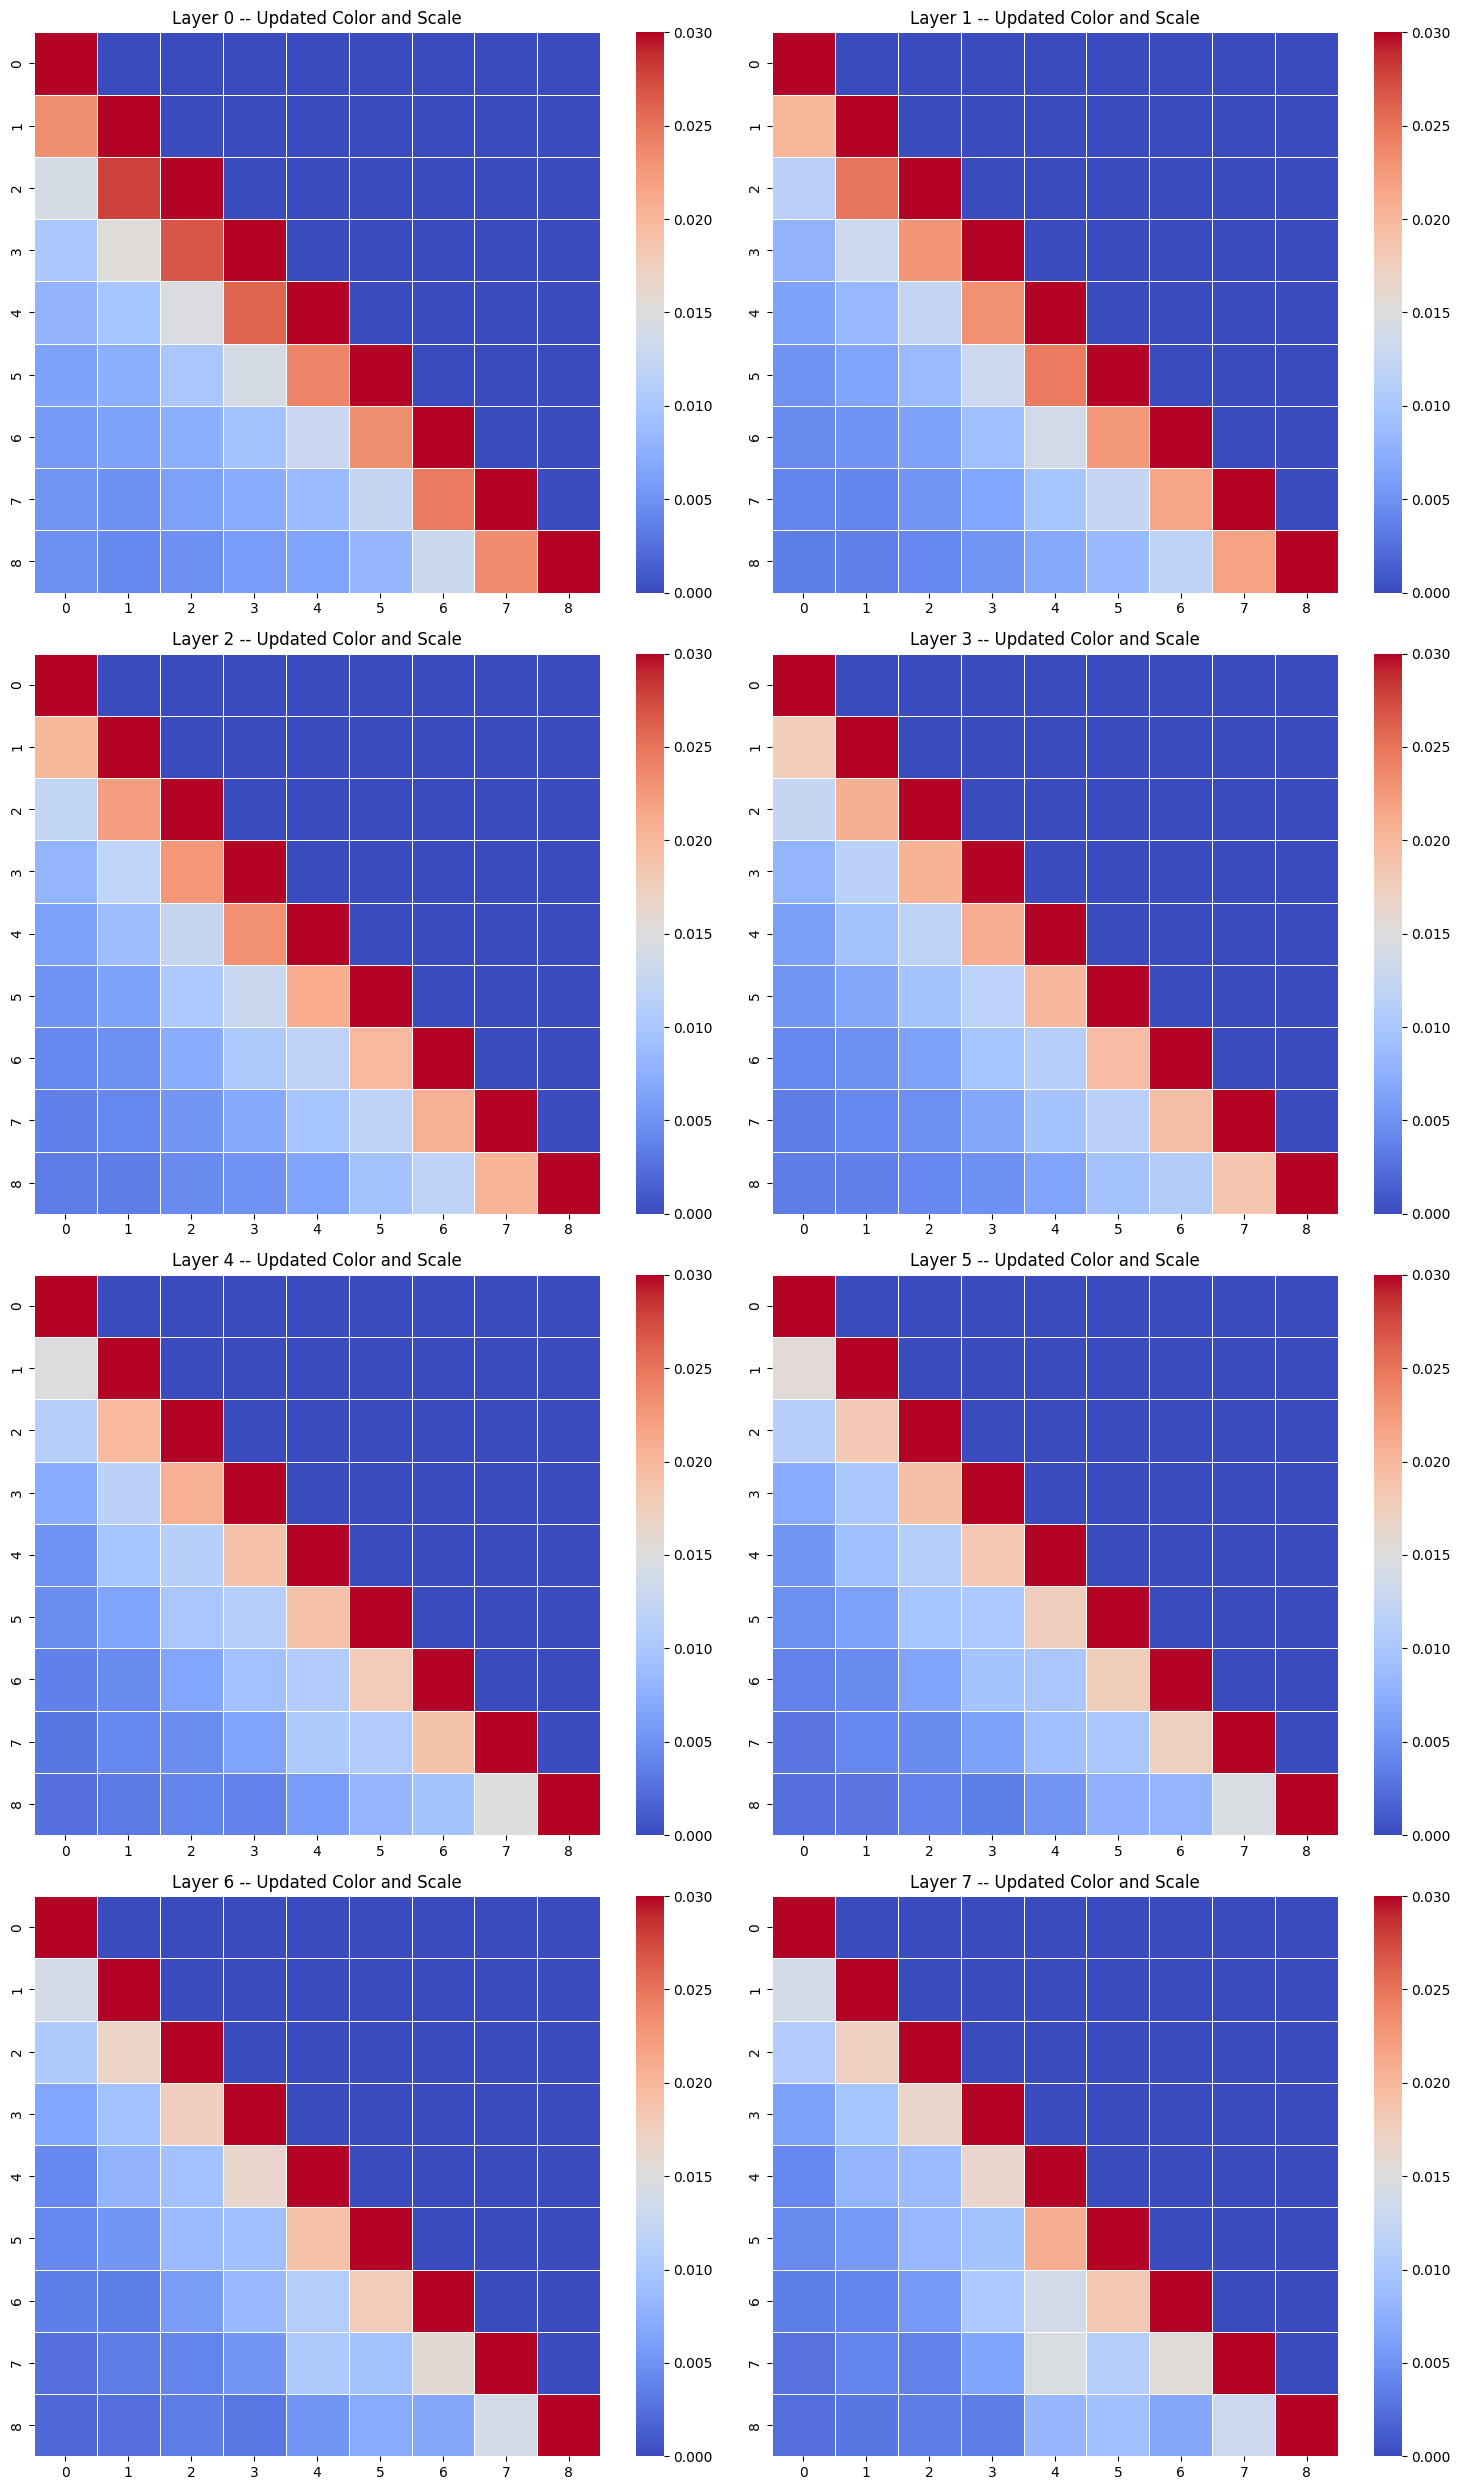

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 创建一个2x2的子图布局
f, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flatten()  # 将2x2的数组展平为一维数组，方便遍历

# 循环绘制每个注意力矩阵
for i, ax in enumerate(axes):
    sub_node_attn=node_attn[:,np.array([1,2,3,4,5,6,7,8,9])+i*9]
    
    sub_node_attn=sub_node_attn[np.array([1,2,3,4,5,6,7,8,9])+i*9,:]
    
    sns.heatmap(sub_node_attn, annot=False, fmt=".3f", linewidths=.5, ax=ax, cmap='coolwarm', vmin=0, vmax=0.03)
    
    ax.set_title(f'Layer {i} -- Updated Color and Scale')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

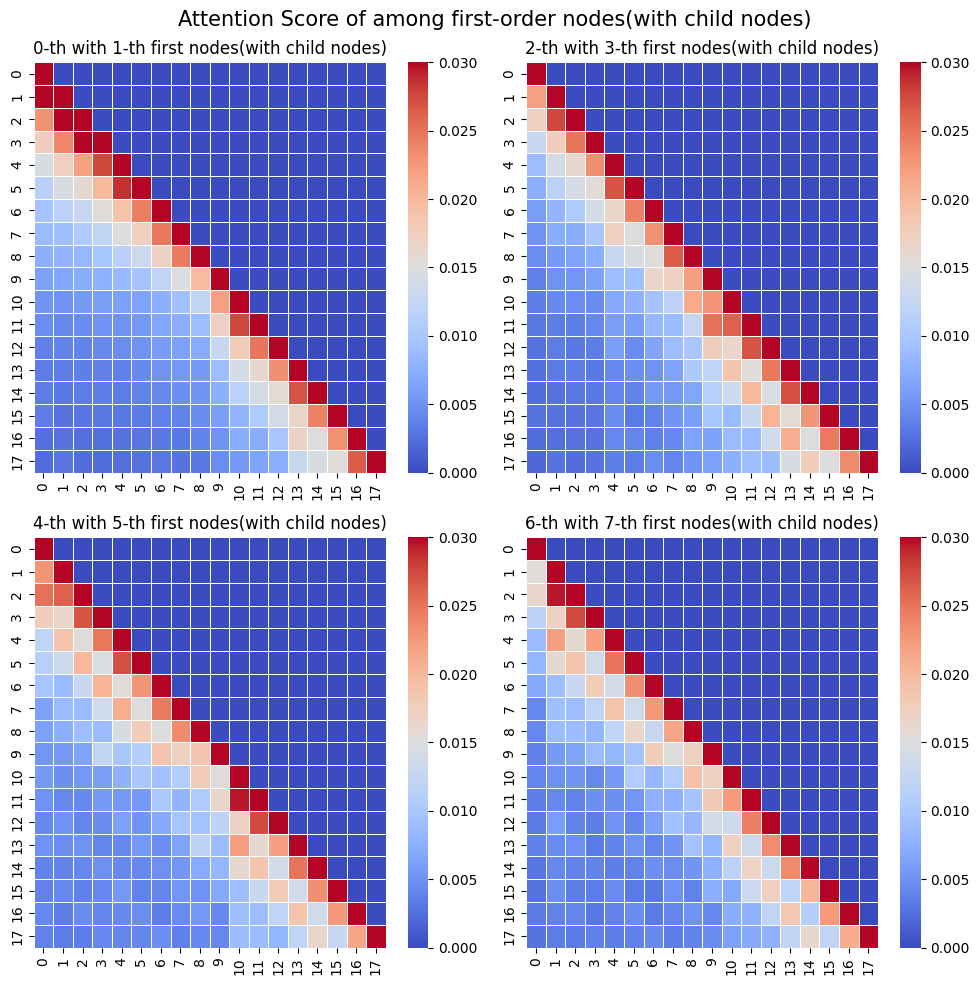

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 创建一个2x2的子图布局
f, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # 将2x2的数组展平为一维数组，方便遍历

# 循环绘制每个注意力矩阵
for i, ax in enumerate(axes):
    sub_node_attn=node_attn[:,np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])+i*9]
    
    sub_node_attn=sub_node_attn[np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])+i*9,:]
    
    sns.heatmap(sub_node_attn, annot=False, fmt=".3f", linewidths=.5, ax=ax, cmap='coolwarm', vmin=0, vmax=0.03)
    
    ax.set_title(f'{2*i}-th with {2*i+1}-th first nodes(with child nodes)')

# 添加共享的X轴和Y轴标签
f.suptitle('Attention Score of among first-order nodes(with child nodes)', fontsize=15)

# 调整子图之间的间距
plt.tight_layout()

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"first-order_node_with_first-order_node_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')


# 显示图形
plt.show()

In [260]:
text_attn=all_attn[:,:,:,text_index]

text_attn=text_attn[:,:,text_index,:]

# 计算忽略0值的平均注意力权重

text_attn = masked_mean(masked_mean(text_attn, dim=0), dim=0)

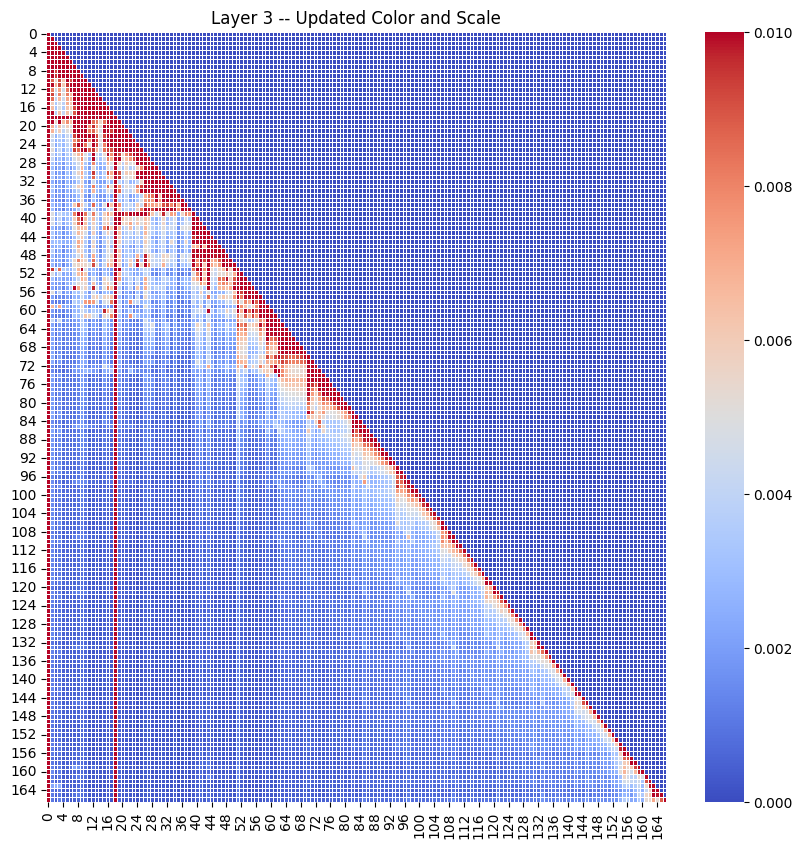

In [261]:
# 创建一个新的图形
plt.figure(figsize=(10, 10))

# 使用 seaborn 绘制热力图
sns.heatmap(text_attn, annot=False, fmt=".3f", linewidths=.5, cmap='coolwarm', vmin=0, vmax=0.01)

# 设置标题
plt.title(f'Layer {i} -- Updated Color and Scale')

# 显示图形
plt.show()

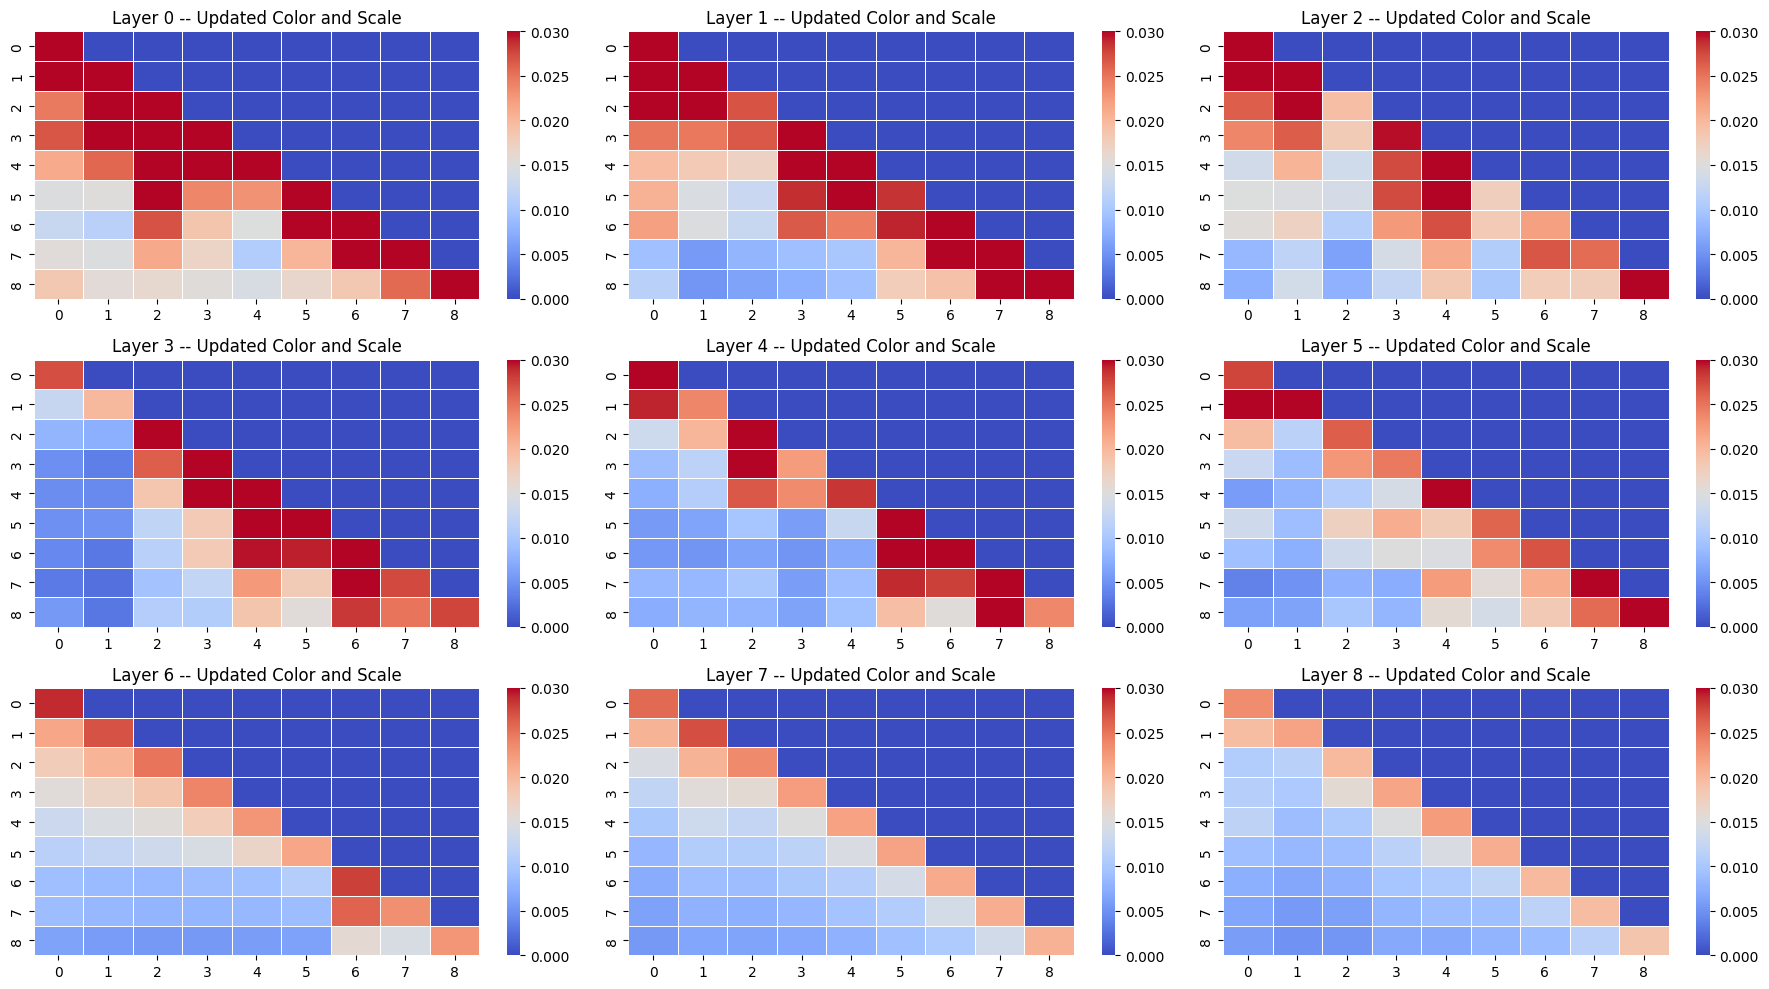

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 创建一个2x2的子图布局
f, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()  # 将2x2的数组展平为一维数组，方便遍历

# 循环绘制每个注意力矩阵
for i, ax in enumerate(axes):
    sub_text_attn=text_attn[:,np.array([1,2,3,4,5,6,7,8,9])+(i+1)*9]
    
    sub_text_attn=sub_text_attn[np.array([1,2,3,4,5,6,7,8,9])+(i+1)*9,:]
    
    sns.heatmap(sub_text_attn, annot=False, fmt=".3f", linewidths=.5, ax=ax, cmap='coolwarm', vmin=0, vmax=0.03)
    
    ax.set_title(f'Layer {i} -- Updated Color and Scale')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

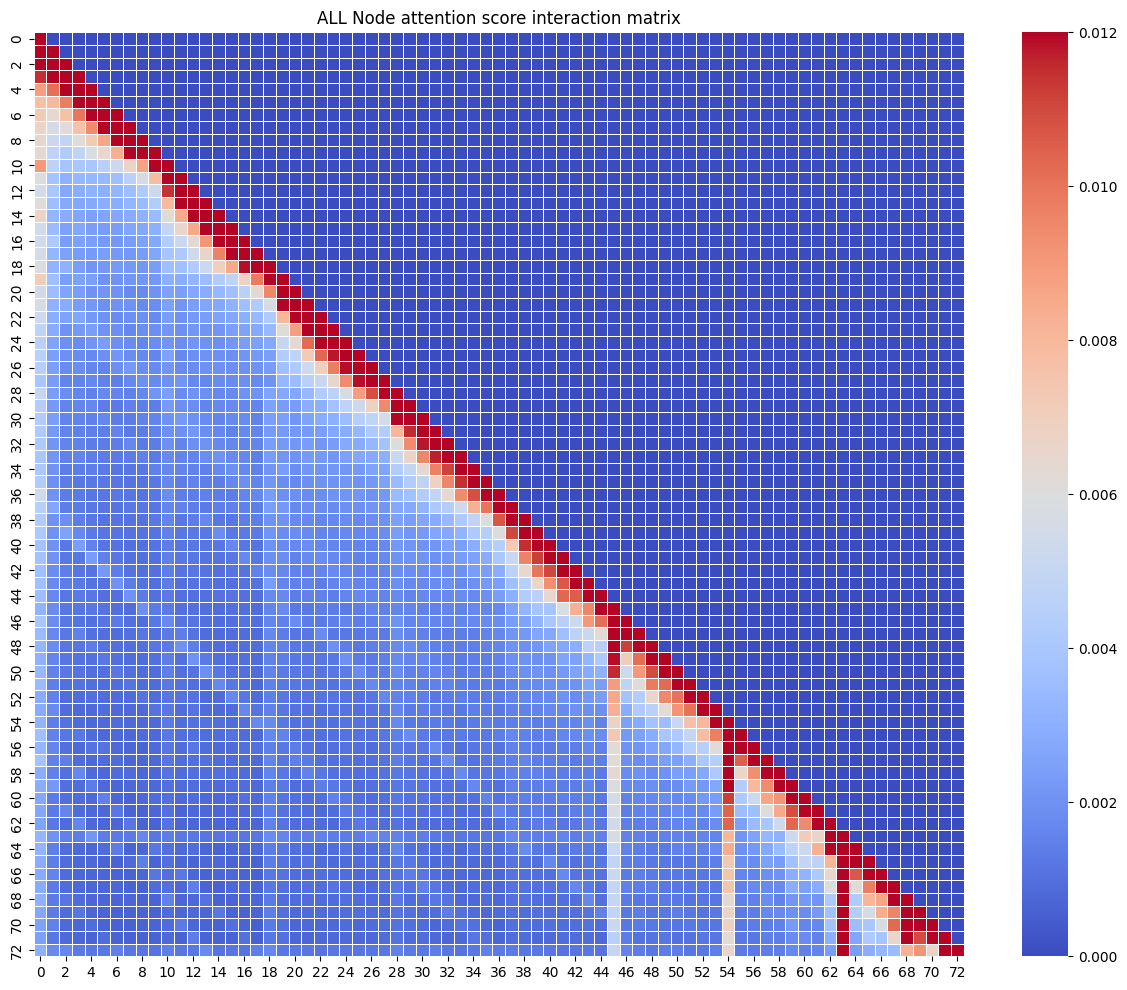

In [318]:

dataset='wikics'
# all_attn = torch.load(f'atten_pad_{dataset}').squeeze()
all_attn=load_attention_weights(f'atten_pad_{dataset}')
all_attn=torch.stack(all_attn)
all_attn=all_attn.squeeze().view(-1,all_attn.shape[-3],all_attn.shape[-2],all_attn.shape[-1]).cpu()



node_attn=all_attn[:,:,:,node_index_dict[dataset]]

node_attn=node_attn[:,:,node_index_dict[dataset],:]

# 计算忽略0值的平均注意力权重
node_attn = masked_mean(masked_mean(node_attn, dim=0), dim=0)

# 创建一个新的图形
plt.figure(figsize=(15, 12))

# 使用 seaborn 绘制热力图
sns.heatmap(node_attn, annot=False, fmt=".3f", linewidths=.5, cmap='coolwarm', vmin=0, vmax=0.012)

# 设置标题
plt.title(f'ALL Node attention score interaction matrix')

# 显示图形
plt.show()

/tmp/ipykernel_73461/2337173751.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # 留出空间给全局标题和颜色条


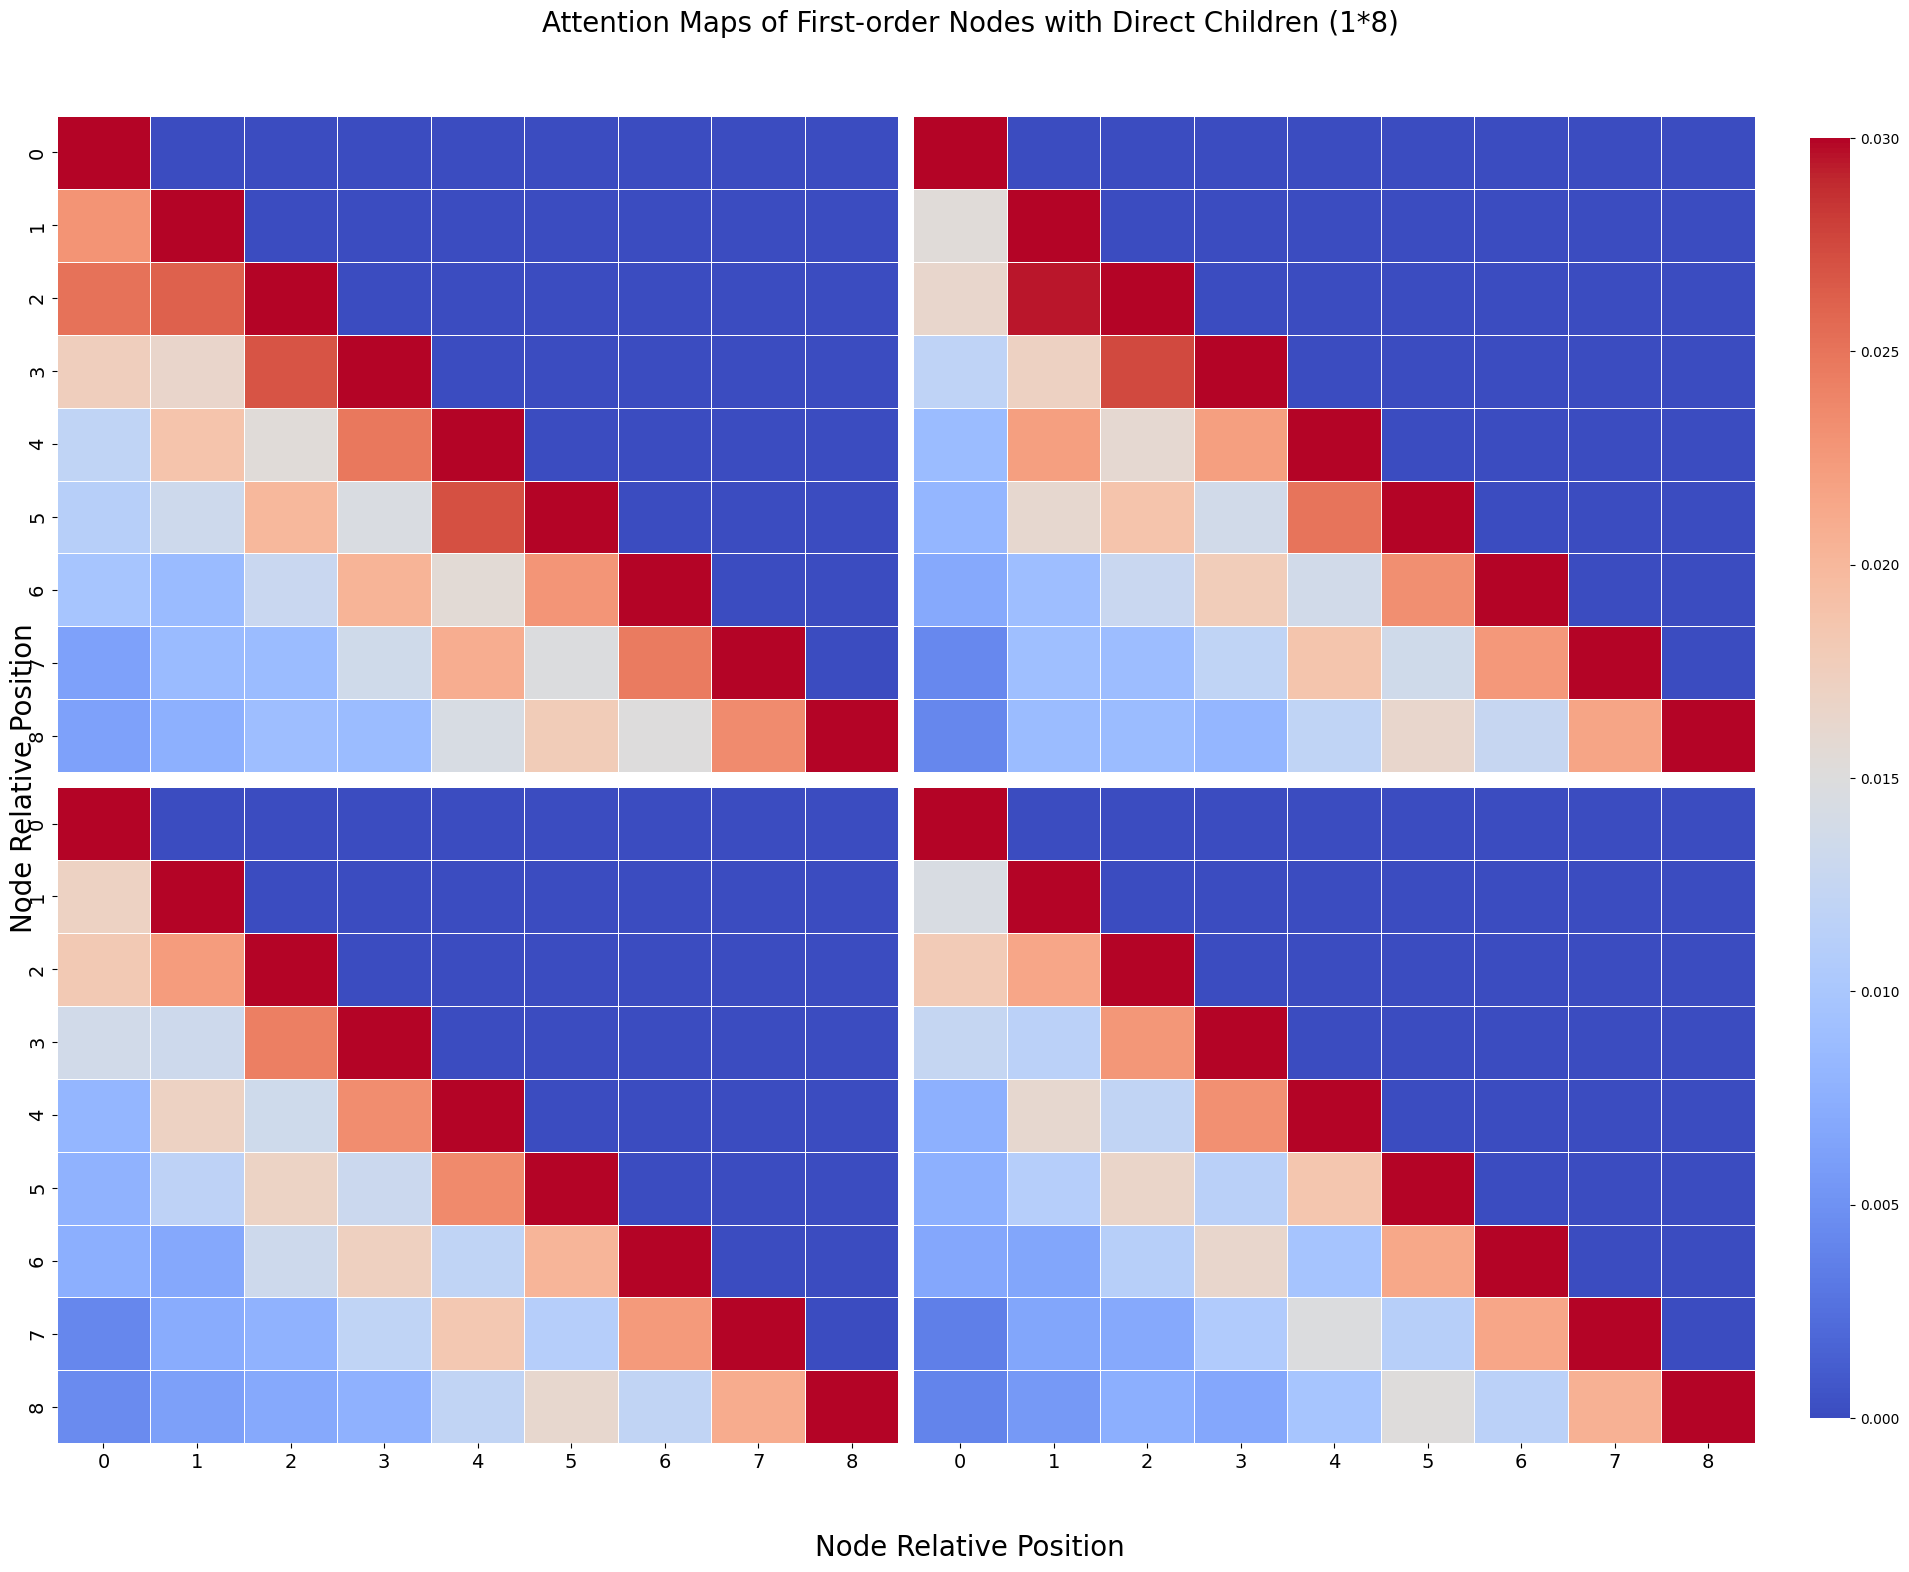

In [317]:
dataset='amazon_ratings'
# all_attn = torch.load(f'atten_pad_{dataset}').squeeze()
all_attn=load_attention_weights(f'atten_pad_{dataset}')
all_attn=torch.stack(all_attn)
all_attn=all_attn.squeeze().view(-1,all_attn.shape[-3],all_attn.shape[-2],all_attn.shape[-1]).cpu()


node_attn=all_attn[:,:,:,node_index_dict[dataset]]

node_attn=node_attn[:,:,node_index_dict[dataset],:]

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 计算忽略0值的平均注意力权重（假设 masked_mean 函数已经定义）
node_attn = masked_mean(masked_mean(node_attn, dim=0), dim=0)

# 假设 node_attn 已经被正确计算出来

# 创建一个2x2的子图布局加上一个额外的空间给颜色条
f, axes = plt.subplots(2, 2, figsize=(20, 16))
cbar_ax = f.add_axes([.92, .1, .02, .8])  # 新增一个轴用于颜色条 [left, bottom, width, height]

axes = axes.flatten()  # 将2x2的数组展平为一维数组，方便遍历

# 设置全局标题
f.suptitle('Attention Maps of First-order Nodes with Direct Children (1*8)', fontsize=20)

# 设置刻度字体大小
tick_font_size = 14  # 刻度字体大小

# 循环绘制每个注意力矩阵
for i, ax in enumerate(axes):
    sub_node_attn = node_attn[:, np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]) + (i + 2) * 9]
    sub_node_attn = sub_node_attn[np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]) + (i + 2) * 9, :]
    
    sns.heatmap(sub_node_attn, annot=False, fmt=".3f", linewidths=.5, ax=ax, cmap='coolwarm', vmin=0, vmax=0.03, cbar=i==3, cbar_ax=None if i<3 else cbar_ax)
    
    # 如果不是最下面一行，则隐藏X轴标签
    if i < 2:
        ax.set_xticks([])
    else:
        # 设置X轴刻度字体大小
        ax.tick_params(axis='x', labelsize=tick_font_size)
    
    # 如果不是最左边一列，则隐藏Y轴标签
    if i % 2 != 0:
        ax.set_yticks([])
    else:
        # 设置Y轴刻度字体大小
        ax.tick_params(axis='y', labelsize=tick_font_size)

# 添加共享的X轴和Y轴标签
f.supxlabel('Node Relative Position', fontsize=20)
f.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # 留出空间给全局标题和颜色条

# 显示图形
plt.show()

In [322]:
dataset = 'wikics'
all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')

In [65]:
# 创建掩码，用于遮挡主对角线以上的区域
mask = np.triu(np.ones_like(node_attn_wikics, dtype=bool))

/tmp/ipykernel_15630/2922852751.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 留出空间给全局标题和颜色条


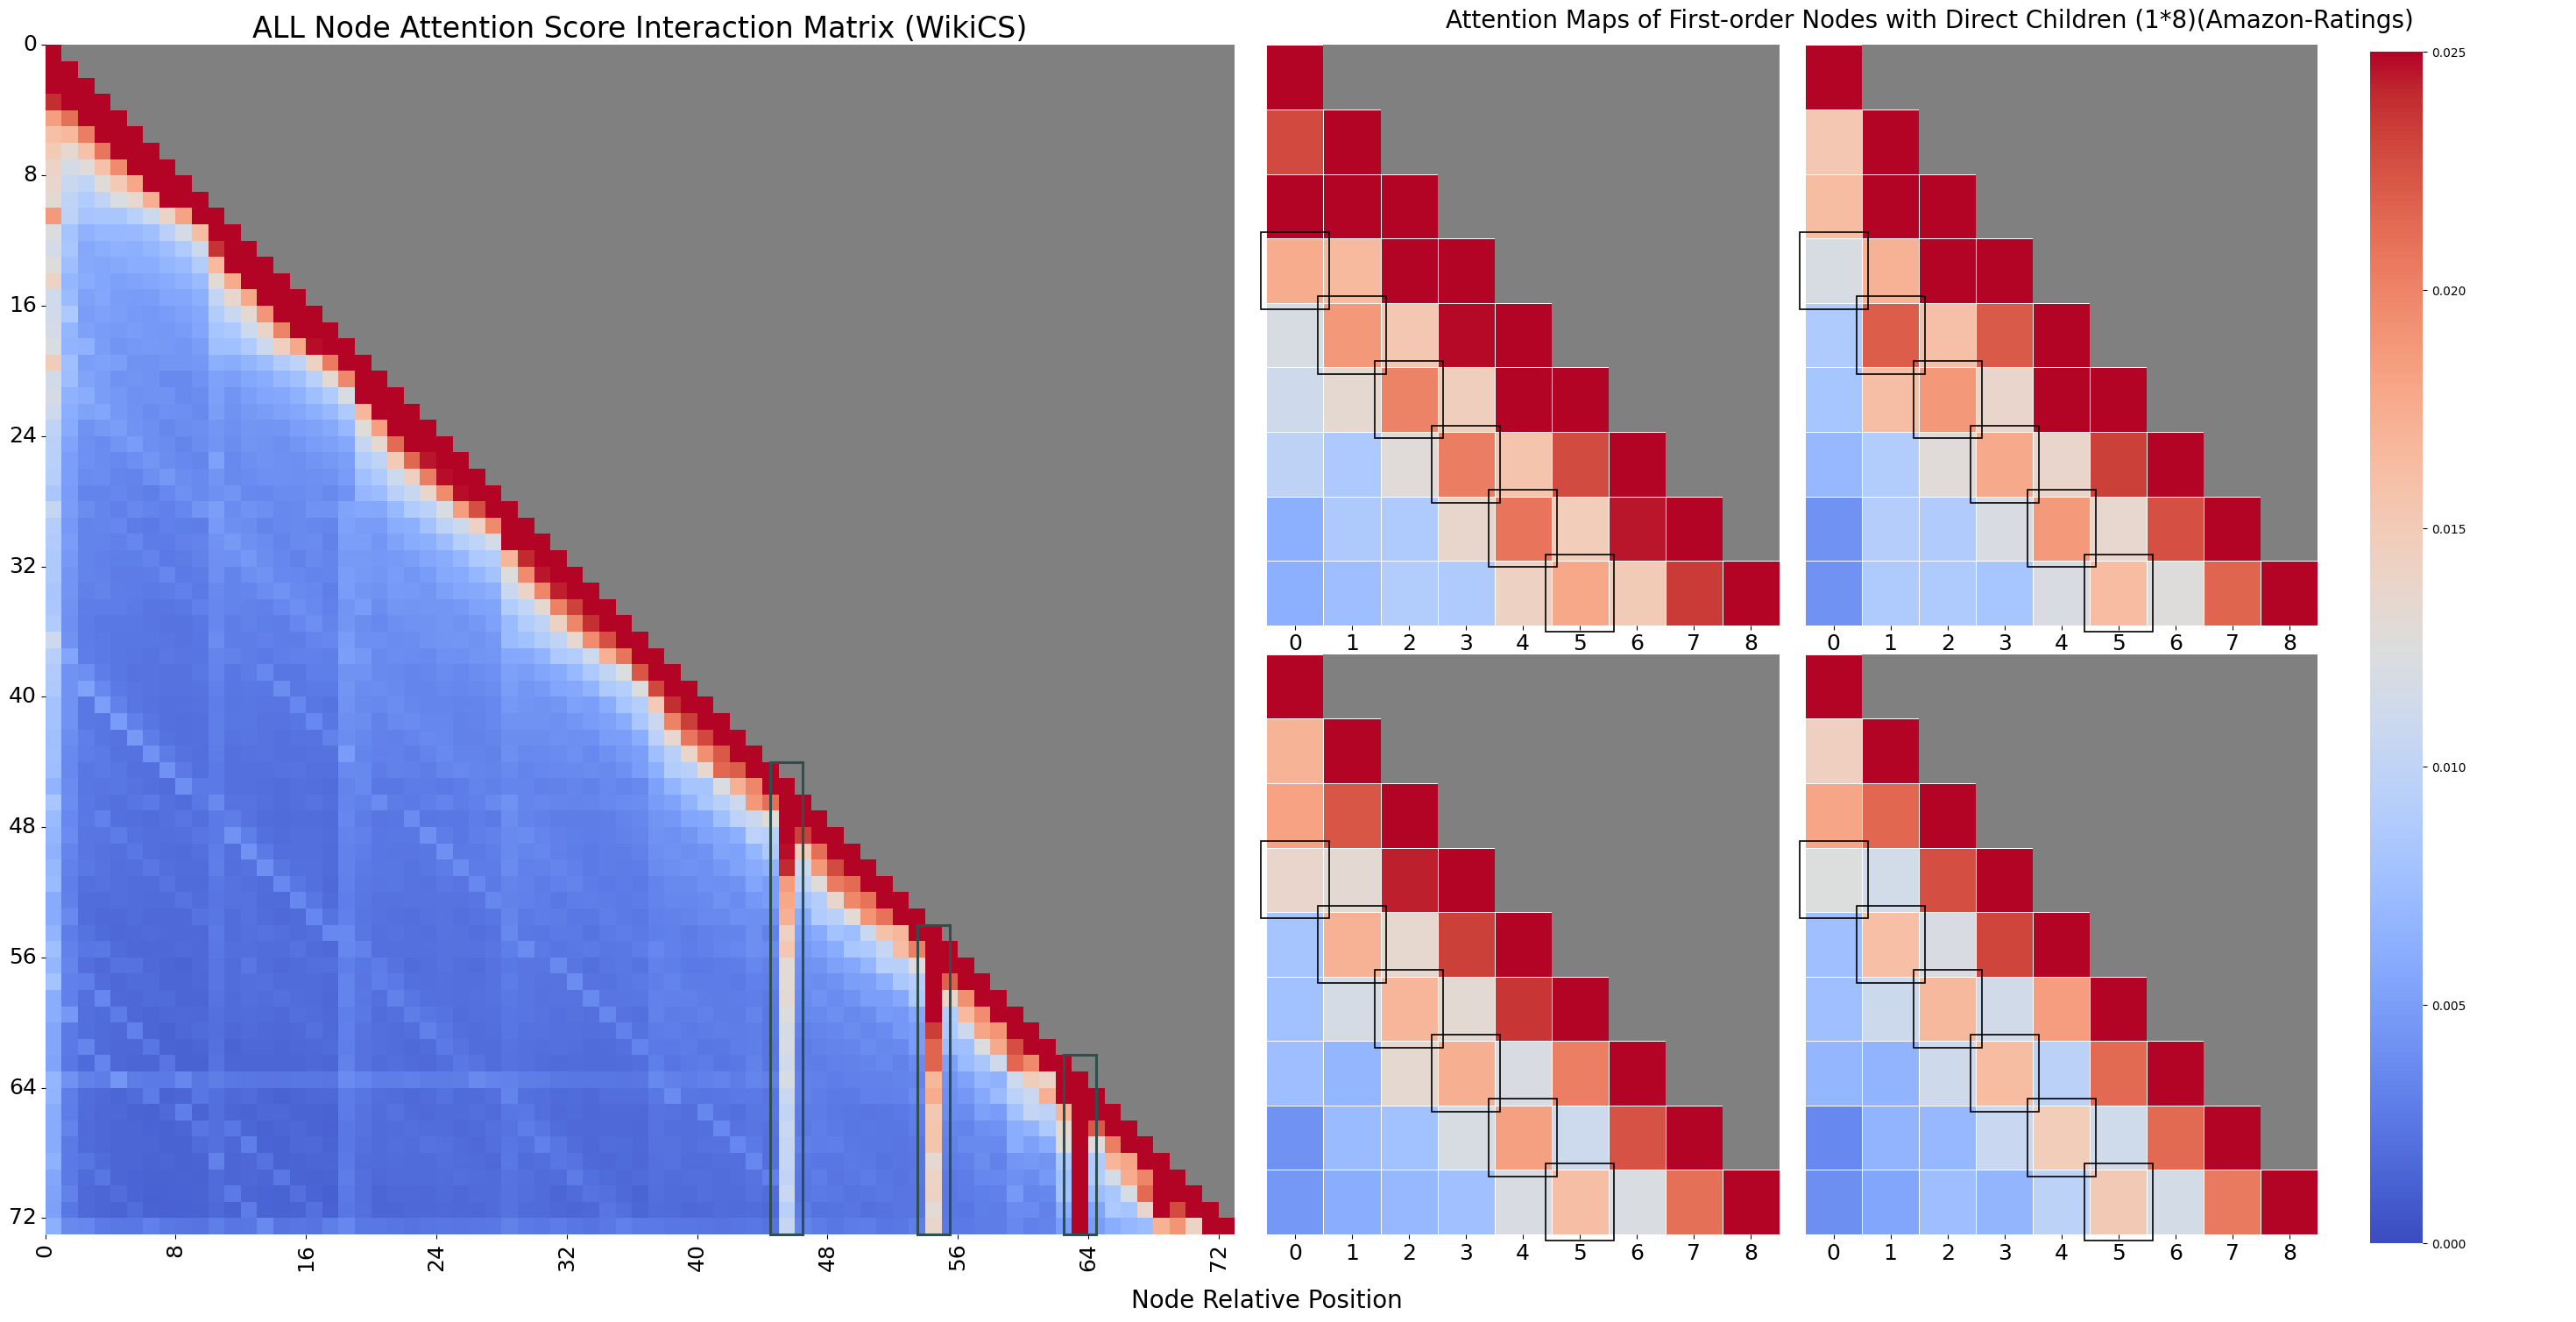

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载并处理wikics数据集的注意力权重
dataset = 'wikics'
all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')
all_attn_wikics=torch.stack(all_attn_wikics)
all_attn_wikics=all_attn_wikics.squeeze().view(-1,all_attn_wikics.shape[-3],all_attn_wikics.shape[-2],all_attn_wikics.shape[-1]).cpu()

node_attn_wikics = all_attn_wikics[:, :, :, node_index_dict[dataset]]
node_attn_wikics = node_attn_wikics[:, :, node_index_dict[dataset], :]
node_attn_wikics = masked_mean(masked_mean(node_attn_wikics, dim=0), dim=0)

# 加载并处理amazon_ratings数据集的注意力权重
dataset = 'amazon_ratings'
all_attn_amazon = load_attention_weights(f'atten_pad_{dataset}')
all_attn_amazon = torch.stack(all_attn_amazon)
all_attn_amazon=all_attn_amazon.squeeze().view(-1, all_attn_amazon.shape[-3], all_attn_amazon.shape[-2], all_attn_amazon.shape[-1]).cpu()
node_attn_amazon = all_attn_amazon[:, :, :, node_index_dict[dataset]]
node_attn_amazon = node_attn_amazon[:, :, node_index_dict[dataset], :]
node_attn_amazon = masked_mean(masked_mean(node_attn_amazon, dim=0), dim=0)




# 创建一个主图形，包含两列
fig = plt.figure(figsize=(30, 16))

# 左边：wikics数据集的单个热力图
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(node_attn_wikics, annot=False, fmt=".3f", linewidths=0, linecolor='white',  # 使用白色线条
            cmap='coolwarm', vmin=0, vmax=0.012, ax=ax1, cbar=False, square=True)
# sns.heatmap(node_attn_wikics, annot=False, fmt=".3f", linewidths=0.003, cmap='coolwarm', vmin=0, vmax=0.012, ax=ax1,cbar=False,square=True)

# 在绘制完主要热力图后，直接用灰色覆盖上三角区域
for i in range(node_attn_wikics.shape[0]):
    for j in range(i + 1, node_attn_wikics.shape[1]):
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))
        
# 添加红色边框来突出显示特定列
rect = plt.Rectangle((45 - 0.5, 44), 2, 29, 
                     fill=False, edgecolor="#2F4F4F", linewidth=2.2, clip_on=False)
ax1.add_patch(rect)

# 添加红色边框来突出显示特定列
rect = plt.Rectangle((54 - 0.5, 54), 2, 19, 
                     fill=False, edgecolor="#2F4F4F", linewidth=2.2, clip_on=False)
ax1.add_patch(rect)

# 添加红色边框来突出显示特定列
rect = plt.Rectangle((63 - 0.5, 62), 2, 11, 
                     fill=False, edgecolor="#2F4F4F", linewidth=2.2, clip_on=False)
ax1.add_patch(rect)
    
    
ax1.set_title('ALL Node Attention Score Interaction Matrix (WikiCS)', fontsize=24)
ax1.tick_params(axis='both', labelsize=18)

# 设置x轴和y轴的刻度，每8个值显示一次，并且显示对应的数值
ticks_positions = np.arange(0, node_attn_wikics.shape[0], 8)  # 获取每隔8个位置的索引
ax1.set_xticks(ticks_positions)
ax1.set_yticks(ticks_positions)

# 显示具体的数值作为标签
ax1.set_xticklabels(ticks_positions)  # 使用索引作为标签
ax1.set_yticklabels(ticks_positions)  # 使用索引作为标签

# 右边：amazon_ratings数据集的2x2子图布局加上一个额外的空间给颜色条
gs = fig.add_gridspec(2, 2, left=0.5, right=0.9, hspace=0.05, wspace=0.05)
cbar_ax = fig.add_axes([0.92, 0.06, 0.02, 0.85])  # 新增一个轴用于颜色条 [left, bottom, width, height]

axes = [fig.add_subplot(gs[i//2, i%2]) for i in range(4)]  # 将2x2的数组展平为一维数组，方便遍历
        
# 设置全局标题
# fig.suptitle('Combined Attention Maps', fontsize=24)

# 循环绘制每个注意力矩阵
for i, ax in enumerate(axes):
    sub_node_attn = node_attn_amazon[:, np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]) + (i + 2) * 9]
    sub_node_attn = sub_node_attn[np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]) + (i + 2) * 9, :]
    
    sns.heatmap(sub_node_attn, annot=False, fmt=".3f", linewidths=.5, ax=ax, cmap='coolwarm', vmin=0, vmax=0.025, cbar=i==3, cbar_ax=None if i<3 else cbar_ax)
    
    # 在绘制完主要热力图后，直接用灰色覆盖上三角区域
    for i in range(sub_node_attn.shape[0]):
        for j in range(i + 1, sub_node_attn.shape[1]):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))
    
        
    # 框住主对角线的格子
    for i in range(min(sub_node_attn.shape[0]-3, sub_node_attn.shape[1])):
        rect = plt.Rectangle((i-0.1, i + 2.9), 1.2, 1.2, fill=False, edgecolor="black", linewidth=1.2, clip_on=False)
        ax.add_patch(rect)
        
    # 如果不是最下面一行，则隐藏X轴标签
    if i < 2:
        ax.set_xticks([])
    else:
        ax.tick_params(axis='x', labelsize=18)
     
    # 如果不是最左边一列，则隐藏Y轴标签
    if i % 2 != 0:
        ax.set_yticks([])
    else:
        ax.tick_params(axis='y', labelsize=16)
# 为右边的大图设置一个标题
right_side_title = fig.add_subplot(1, 2, 2, frameon=False)
right_side_title.axis('off')  # 不显示坐标轴
right_side_title.set_title('Attention Maps of First-order Nodes with Direct Children (1*8)(Amazon-Ratings)', fontsize=20, pad=14)  # 设置标题并增加一些填充

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node Relative Position', fontsize=20)
# fig.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 留出空间给全局标题和颜色条

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = "attention_score_matrix.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

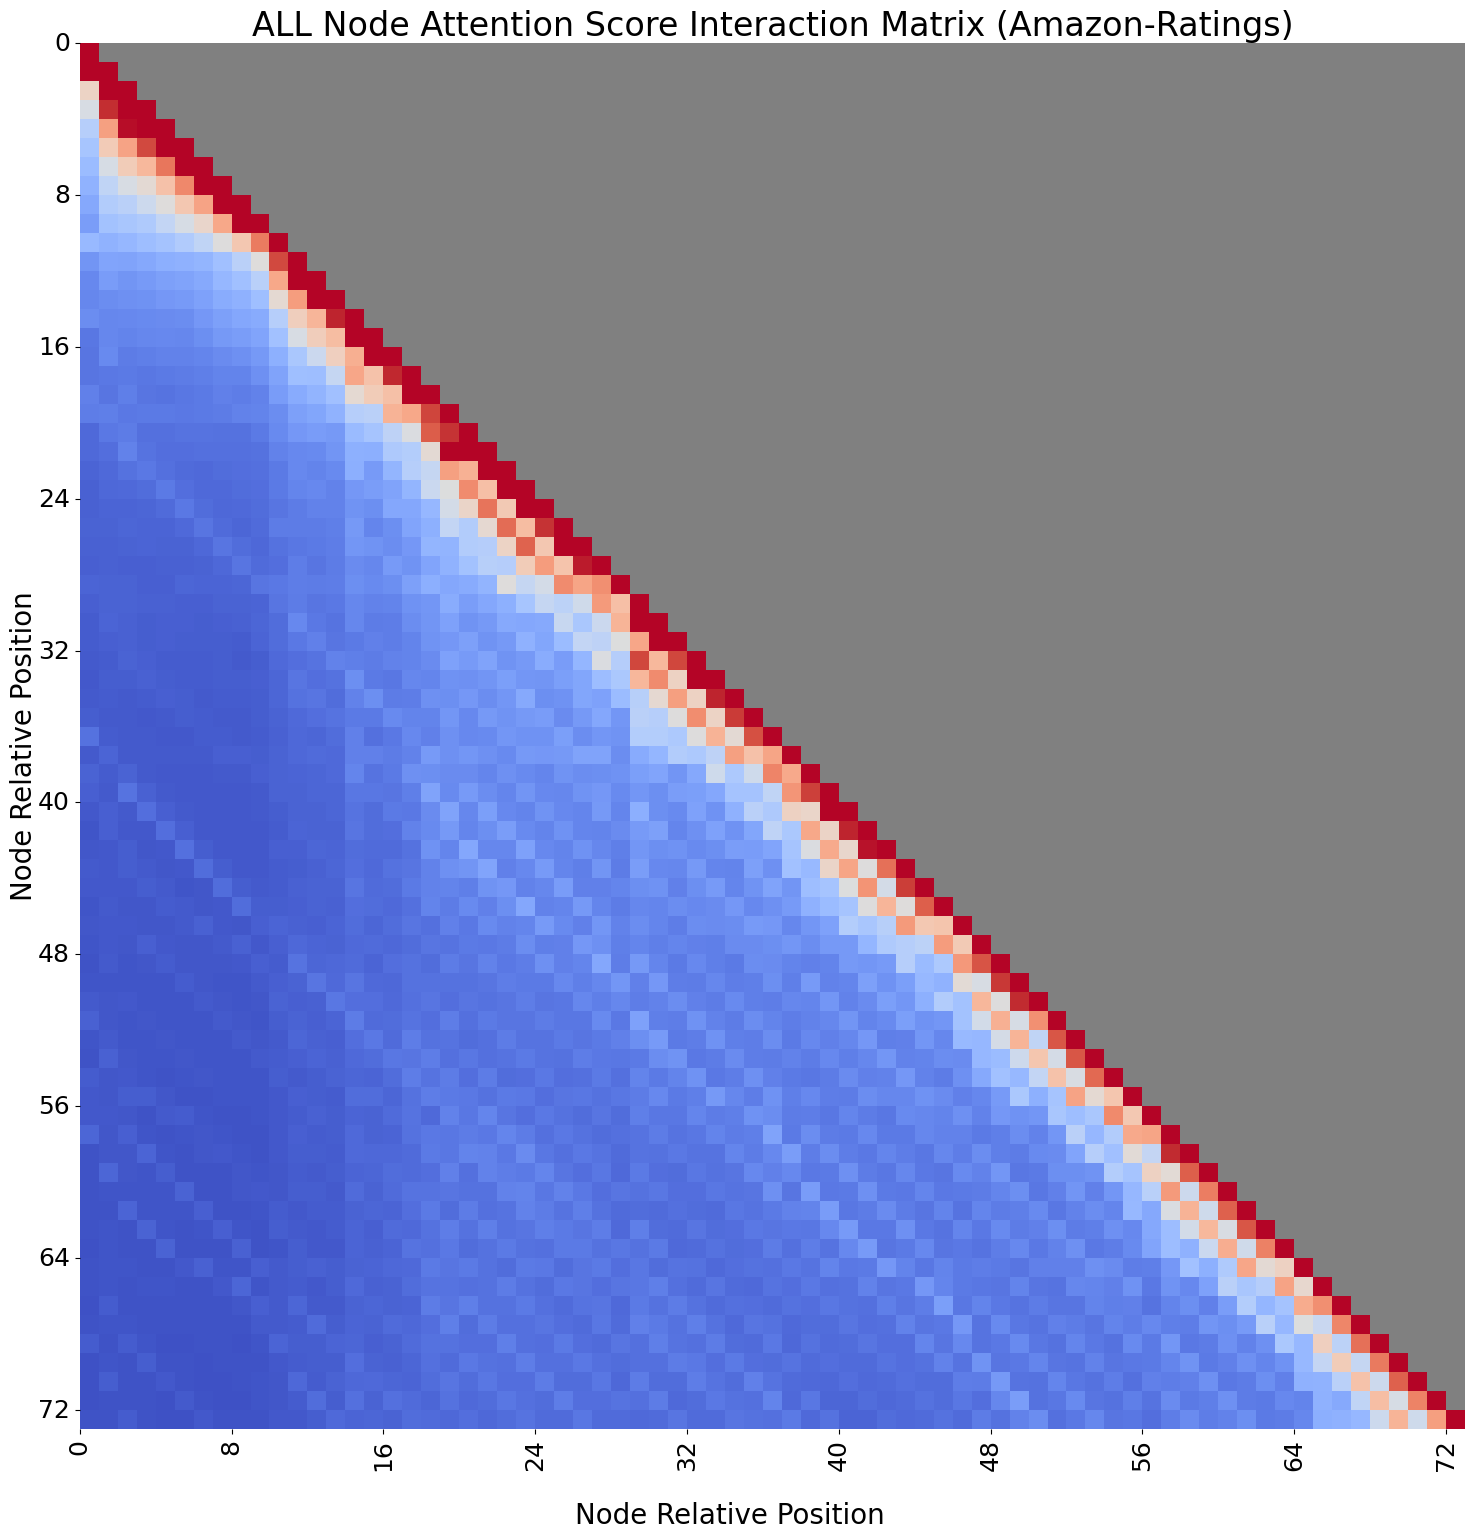

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载并处理wikics数据集的注意力权重
dataset = 'amazon_ratings'

all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')
all_attn_wikics=torch.stack(all_attn_wikics)
all_attn_wikics=all_attn_wikics.squeeze().view(-1, all_attn_wikics.shape[-3], all_attn_wikics.shape[-2], all_attn_wikics.shape[-1]).cpu()

node_attn_wikics = all_attn_wikics[:, :, :, node_index_dict[dataset]]
node_attn_wikics = node_attn_wikics[:, :, node_index_dict[dataset], :]
node_attn_wikics = masked_mean(masked_mean(node_attn_wikics, dim=0), dim=0)

# 创建一个主图形，包含一列
fig = plt.figure(figsize=(15, 16))  # 调整了宽度以适应单个热力图

# 左边：wikics数据集的单个热力图
ax1 = fig.add_subplot(1, 1, 1)  # 修改为单个subplot
sns.heatmap(node_attn_wikics, annot=False, fmt=".3f", linewidths=0, linecolor='white',
            cmap='coolwarm', vmin=0, vmax=0.024, ax=ax1, cbar=False, square=True)

# 在绘制完主要热力图后，直接用灰色覆盖上三角区域
for i in range(node_attn_wikics.shape[0]):
    for j in range(i + 1, node_attn_wikics.shape[1]):
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))

# # 添加红色边框来突出显示特定列
# rect_positions = [(45, 44, 2, 29), (54, 54, 2, 19), (63, 62, 2, 11)]
# for x, y, width, height in rect_positions:
#     rect = plt.Rectangle((x - 0.5, y), width, height,
#                          fill=False, edgecolor="orange", linewidth=2, clip_on=False)
#     ax1.add_patch(rect)

ax1.set_title('ALL Node Attention Score Interaction Matrix (Amazon-Ratings)', fontsize=24)
ax1.tick_params(axis='both', labelsize=18)

# 设置x轴和y轴的刻度，每8个值显示一次，并且显示对应的数值
ticks_positions = np.arange(0, node_attn_wikics.shape[0], 8)
ax1.set_xticks(ticks_positions)
ax1.set_yticks(ticks_positions)

# 显示具体的数值作为标签
ax1.set_xticklabels(ticks_positions)
ax1.set_yticklabels(ticks_positions)

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node Relative Position', fontsize=20)
fig.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"attention_score_matrix_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


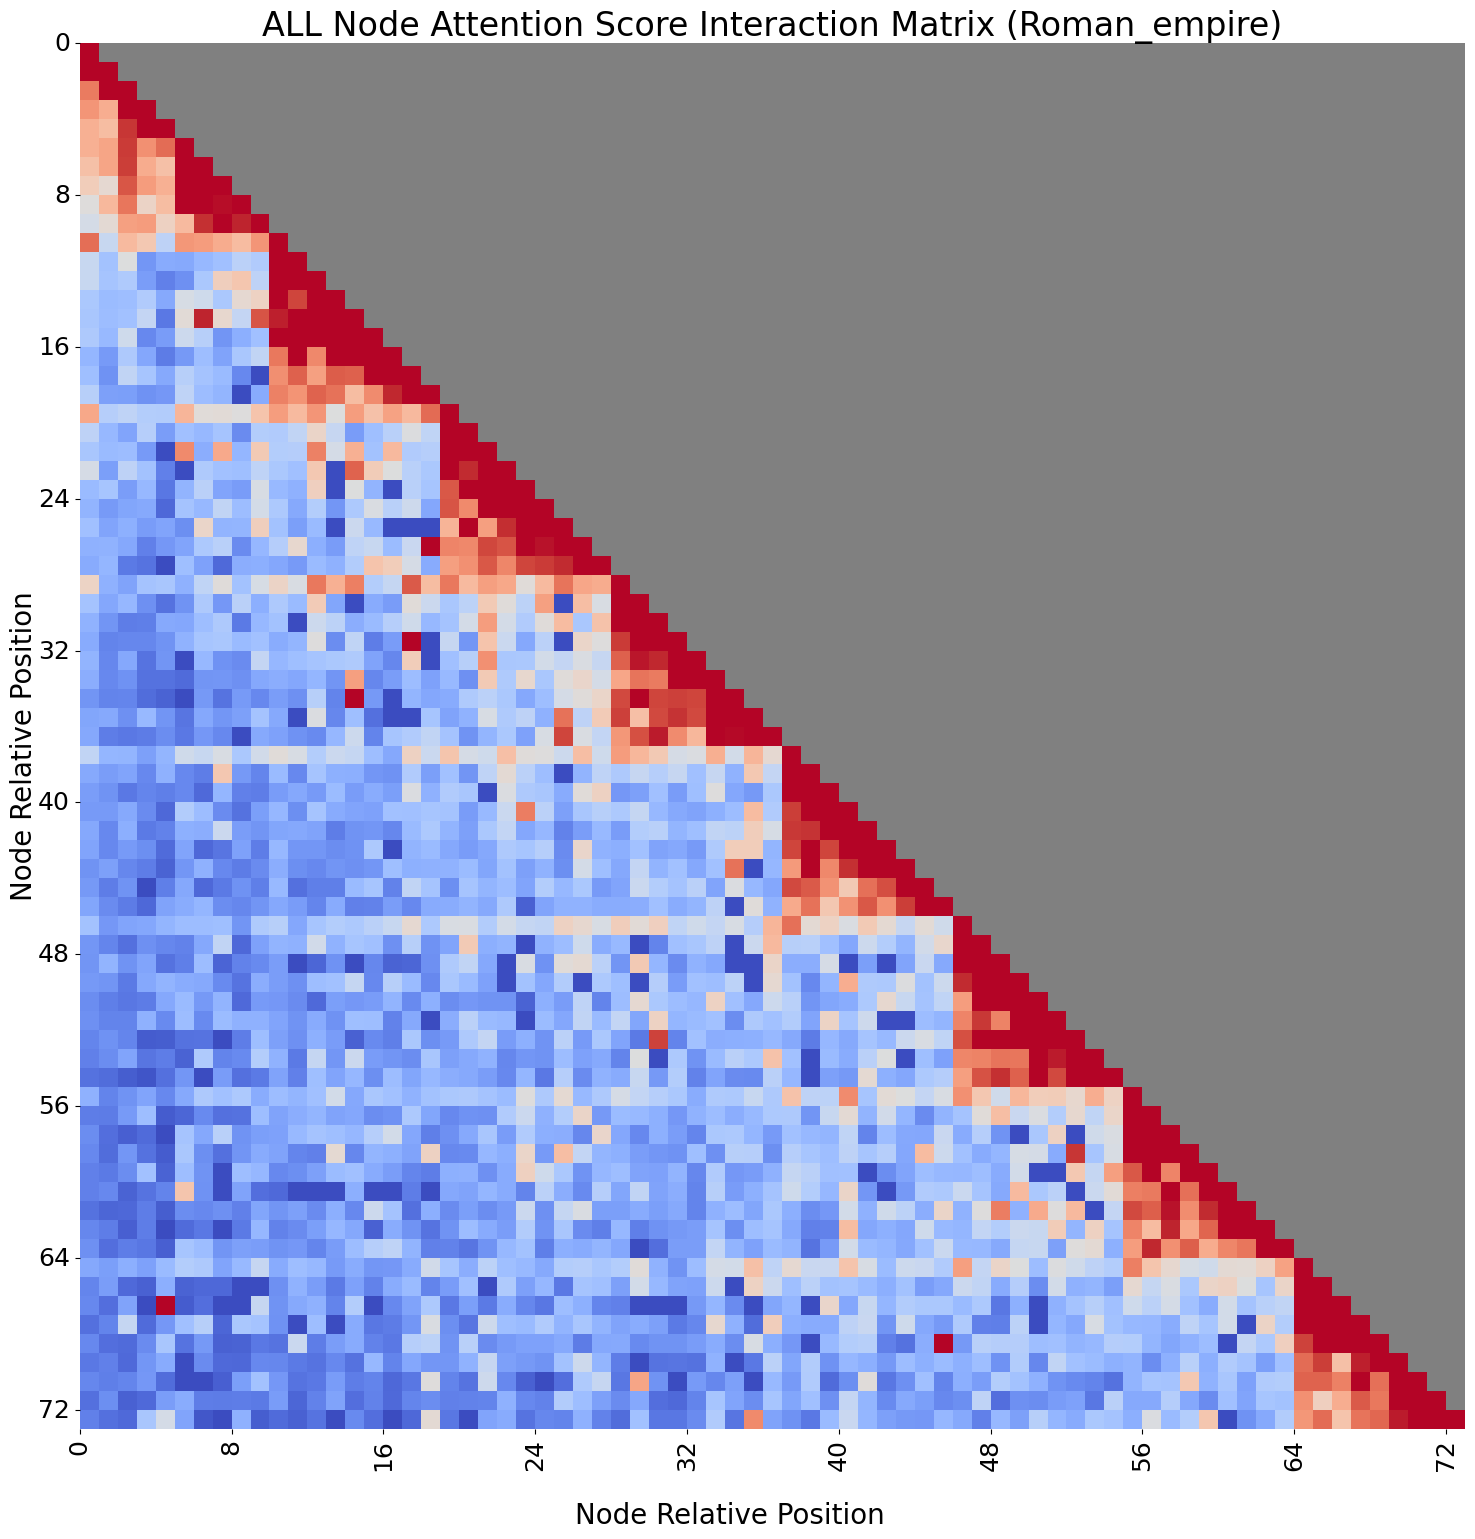

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载并处理wikics数据集的注意力权重
dataset = 'roman_empire'

all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')
all_attn_wikics=torch.stack(all_attn_wikics)
all_attn_wikics=all_attn_wikics.squeeze().view(-1, all_attn_wikics.shape[-3], all_attn_wikics.shape[-2], all_attn_wikics.shape[-1]).cpu()

node_attn_wikics = all_attn_wikics[:, :, :, node_index_dict[dataset]]
node_attn_wikics = node_attn_wikics[:, :, node_index_dict[dataset], :]
node_attn_wikics = masked_mean(masked_mean(node_attn_wikics, dim=0), dim=0)

# 创建一个主图形，包含一列
fig = plt.figure(figsize=(15, 16))  # 调整了宽度以适应单个热力图

# 左边：wikics数据集的单个热力图
ax1 = fig.add_subplot(1, 1, 1)  # 修改为单个subplot
sns.heatmap(node_attn_wikics, annot=False, fmt=".3f", linewidths=0, linecolor='white',
            cmap='coolwarm', vmin=0, vmax=0.024, ax=ax1, cbar=False, square=True)

# 在绘制完主要热力图后，直接用灰色覆盖上三角区域
for i in range(node_attn_wikics.shape[0]):
    for j in range(i + 1, node_attn_wikics.shape[1]):
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))

# # 添加红色边框来突出显示特定列
# rect_positions = [(45, 44, 2, 29), (54, 54, 2, 19), (63, 62, 2, 11)]
# for x, y, width, height in rect_positions:
#     rect = plt.Rectangle((x - 0.5, y), width, height,
#                          fill=False, edgecolor="orange", linewidth=2, clip_on=False)
#     ax1.add_patch(rect)

ax1.set_title('ALL Node Attention Score Interaction Matrix (Roman_empire)', fontsize=24)
ax1.tick_params(axis='both', labelsize=18)

# 设置x轴和y轴的刻度，每8个值显示一次，并且显示对应的数值
ticks_positions = np.arange(0, node_attn_wikics.shape[0], 8)
ax1.set_xticks(ticks_positions)
ax1.set_yticks(ticks_positions)

# 显示具体的数值作为标签
ax1.set_xticklabels(ticks_positions)
ax1.set_yticklabels(ticks_positions)

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node Relative Position', fontsize=20)
fig.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"attention_score_matrix_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


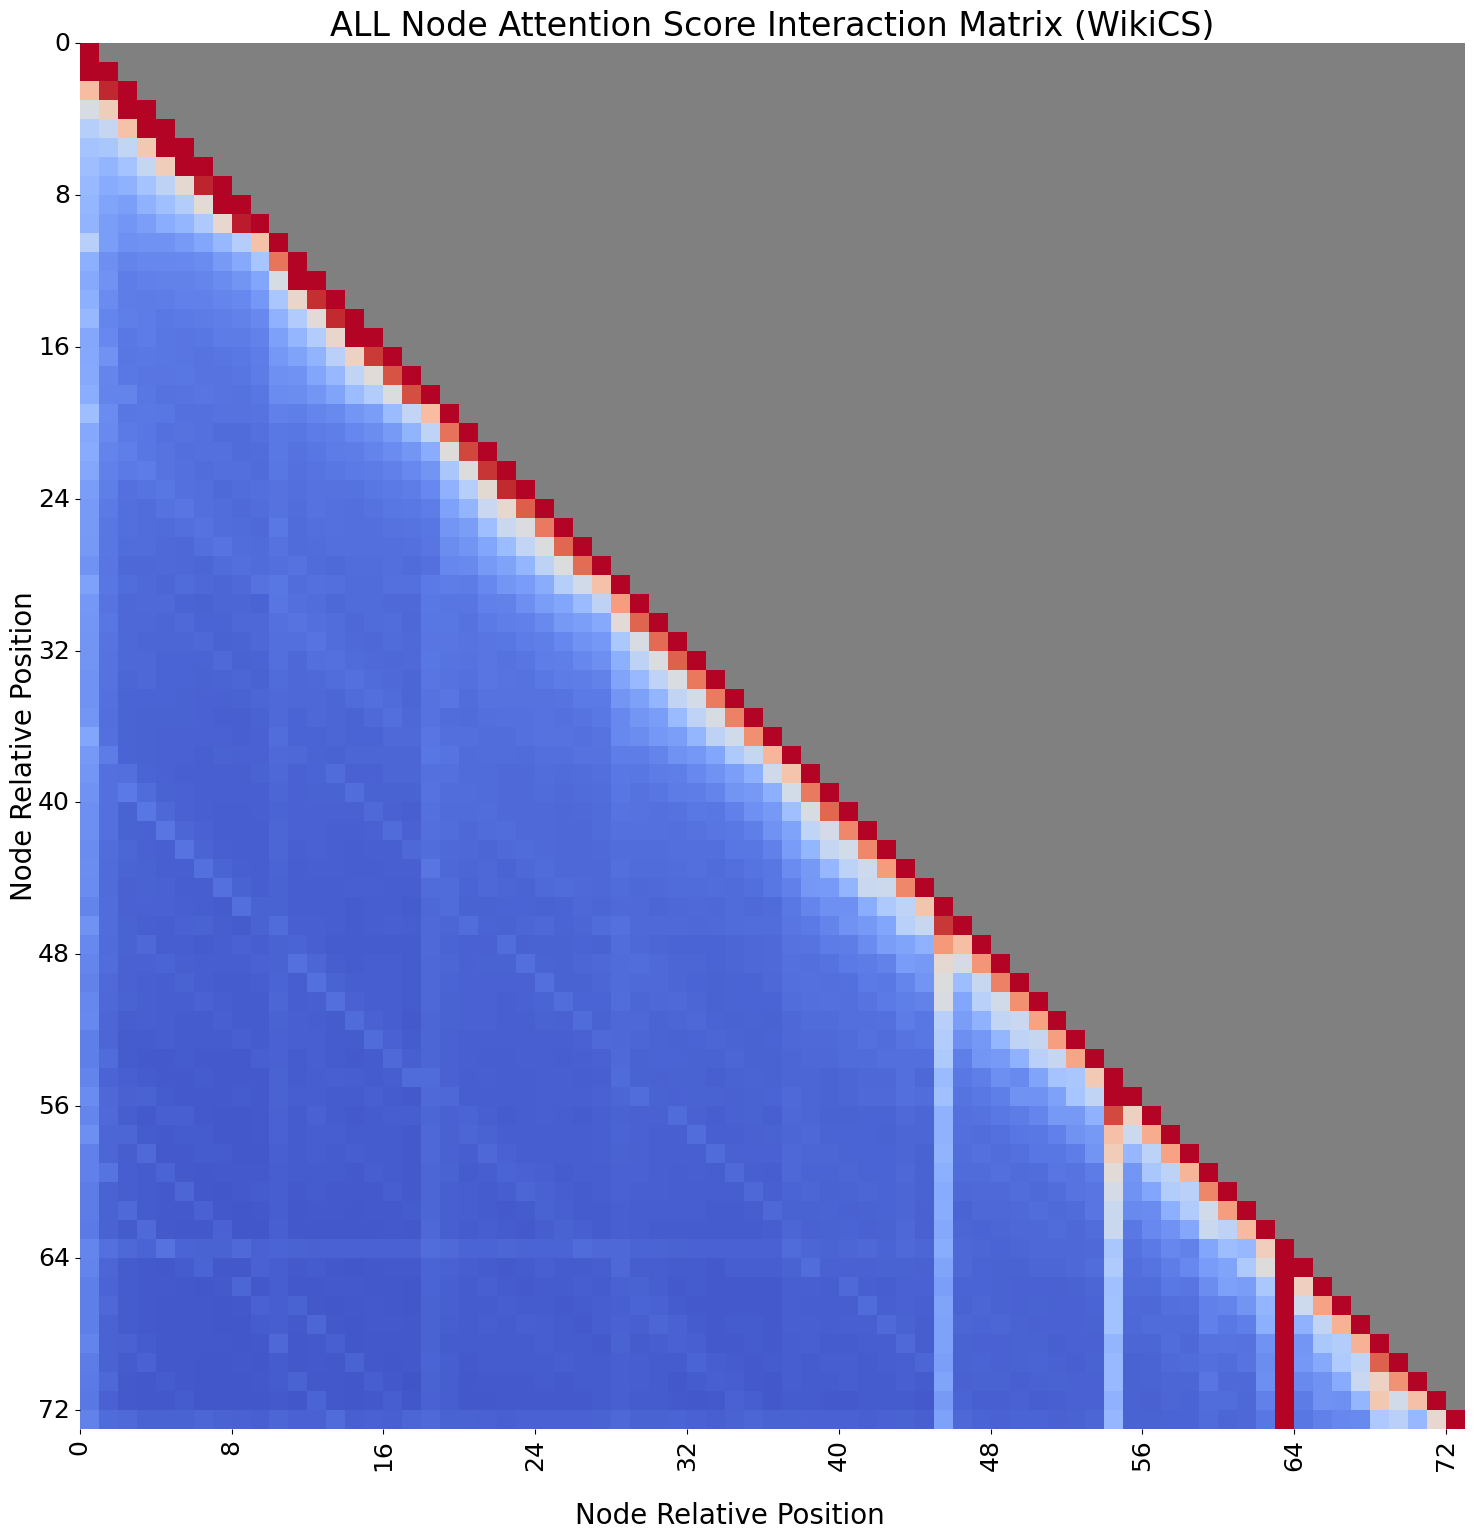

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载并处理wikics数据集的注意力权重
dataset = 'wikics'

all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')
all_attn_wikics=torch.stack(all_attn_wikics)
all_attn_wikics=all_attn_wikics.squeeze().view(-1, all_attn_wikics.shape[-3], all_attn_wikics.shape[-2], all_attn_wikics.shape[-1]).cpu()

node_attn_wikics = all_attn_wikics[:, :, :, node_index_dict[dataset]]
node_attn_wikics = node_attn_wikics[:, :, node_index_dict[dataset], :]
node_attn_wikics = masked_mean(masked_mean(node_attn_wikics, dim=0), dim=0)

# 创建一个主图形，包含一列
fig = plt.figure(figsize=(15, 16))  # 调整了宽度以适应单个热力图

# 左边：wikics数据集的单个热力图
ax1 = fig.add_subplot(1, 1, 1)  # 修改为单个subplot
sns.heatmap(node_attn_wikics, annot=False, fmt=".3f", linewidths=0, linecolor='white',
            cmap='coolwarm', vmin=0, vmax=0.024, ax=ax1, cbar=False, square=True)

# 在绘制完主要热力图后，直接用灰色覆盖上三角区域
for i in range(node_attn_wikics.shape[0]):
    for j in range(i + 1, node_attn_wikics.shape[1]):
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))

# # 添加红色边框来突出显示特定列
# rect_positions = [(45, 44, 2, 29), (54, 54, 2, 19), (63, 62, 2, 11)]
# for x, y, width, height in rect_positions:
#     rect = plt.Rectangle((x - 0.5, y), width, height,
#                          fill=False, edgecolor="orange", linewidth=2, clip_on=False)
#     ax1.add_patch(rect)

ax1.set_title('ALL Node Attention Score Interaction Matrix (WikiCS)', fontsize=24)
ax1.tick_params(axis='both', labelsize=18)

# 设置x轴和y轴的刻度，每8个值显示一次，并且显示对应的数值
ticks_positions = np.arange(0, node_attn_wikics.shape[0], 8)
ax1.set_xticks(ticks_positions)
ax1.set_yticks(ticks_positions)

# 显示具体的数值作为标签
ax1.set_xticklabels(ticks_positions)
ax1.set_yticklabels(ticks_positions)

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node Relative Position', fontsize=20)
fig.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"attention_score_matrix_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


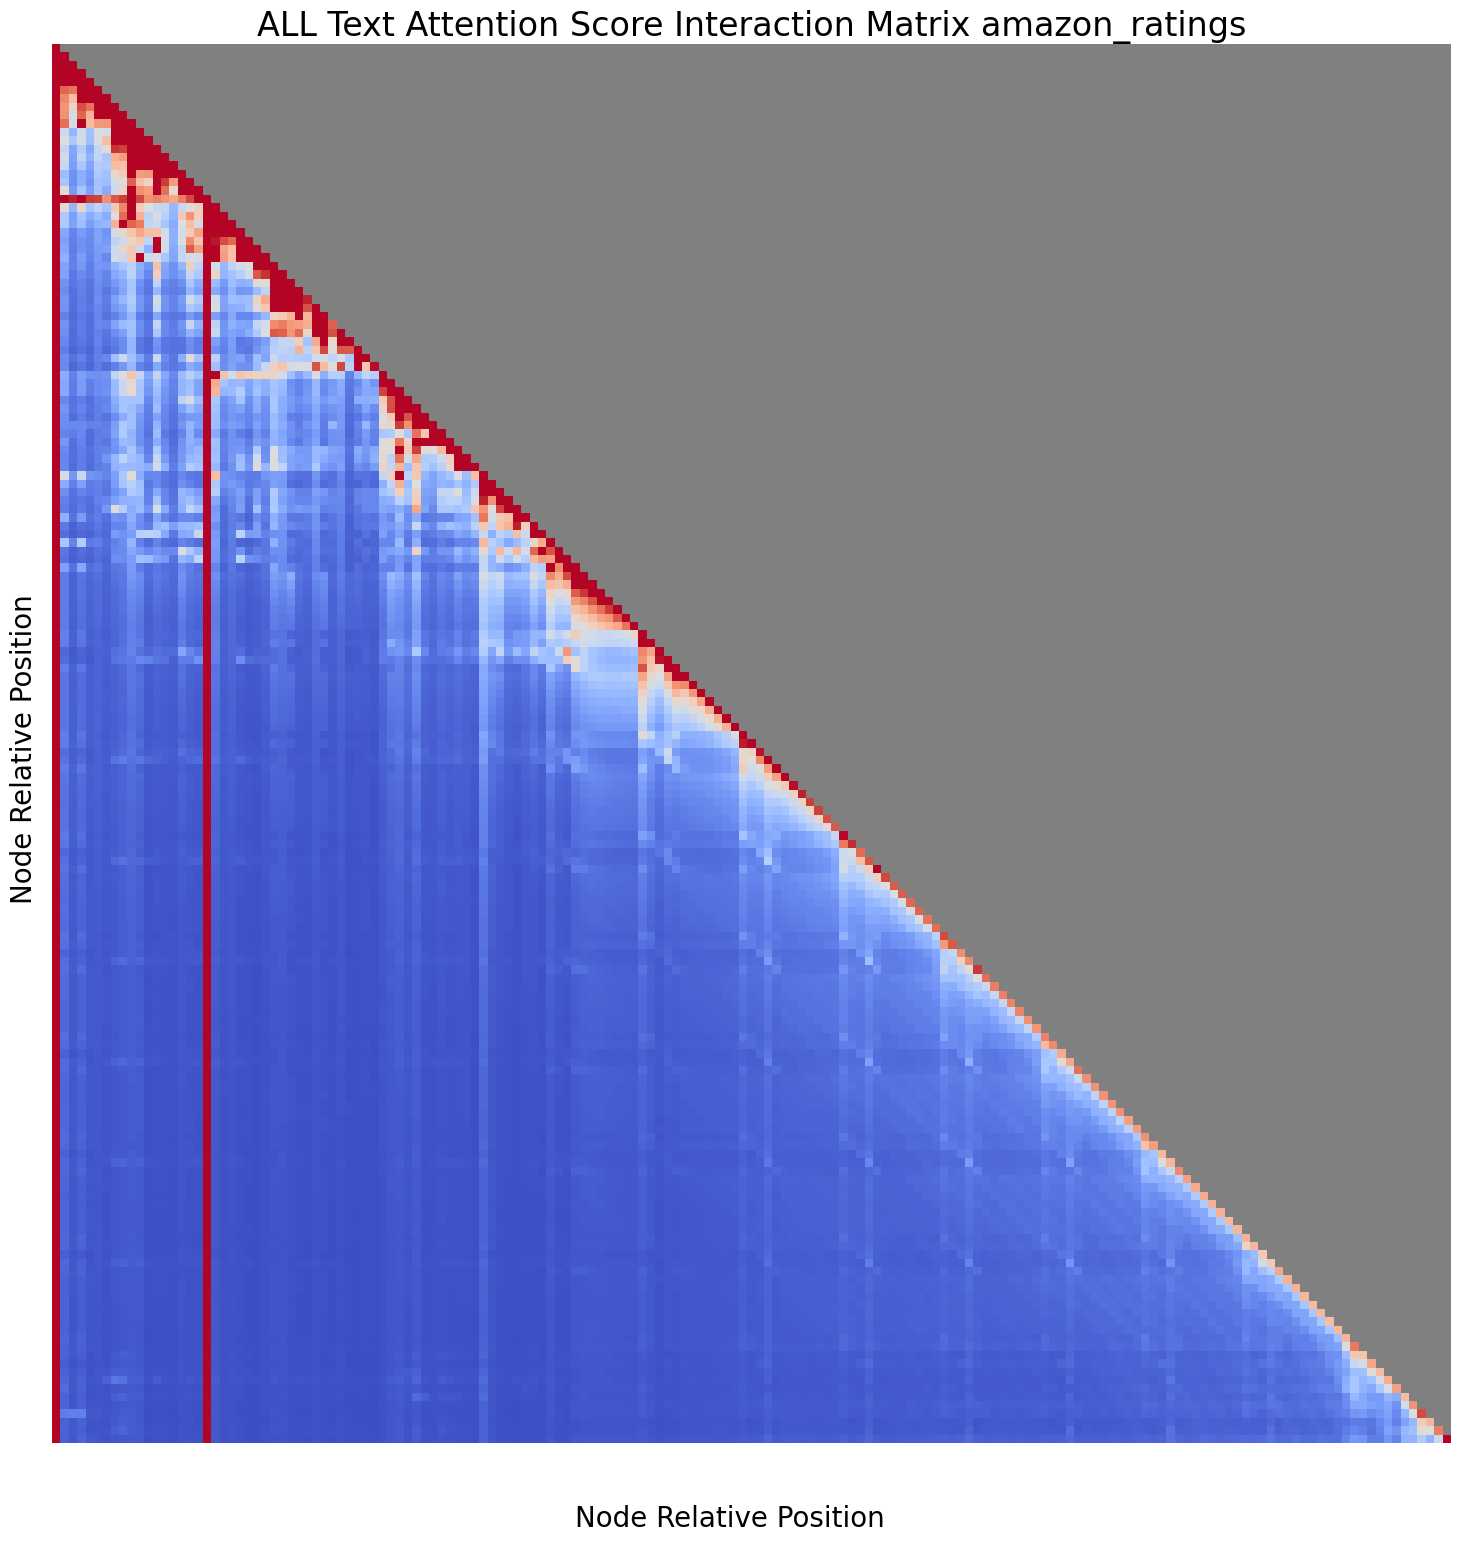

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载并处理wikics数据集的注意力权重
dataset = 'amazon_ratings'

all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')
all_attn_wikics=torch.stack(all_attn_wikics)
all_attn_wikics=all_attn_wikics.squeeze().view(-1, all_attn_wikics.shape[-3], all_attn_wikics.shape[-2], all_attn_wikics.shape[-1]).cpu()

text_attn_wikics = all_attn_wikics[:, :, :, text_index_dict[dataset]]
text_attn_wikics = text_attn_wikics[:, :, text_index_dict[dataset], :]
text_attn_wikics = masked_mean(masked_mean(text_attn_wikics, dim=0), dim=0)

# 创建一个主图形，包含一列
fig = plt.figure(figsize=(15, 16))  # 调整了宽度以适应单个热力图

# 左边：wikics数据集的单个热力图
ax1 = fig.add_subplot(1, 1, 1)  # 修改为单个subplot
sns.heatmap(text_attn_wikics, annot=False, fmt=".3f", linewidths=0, linecolor='white',
            cmap='coolwarm', vmin=0, vmax=0.02, ax=ax1, cbar=False, square=True)

# 在绘制完主要热力图后，直接用灰色覆盖上三角区域
for i in range(text_attn_wikics.shape[0]):
    for j in range(i + 1, text_attn_wikics.shape[1]):
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))

# # 添加红色边框来突出显示特定列
# rect_positions = [(45, 44, 2, 29), (54, 54, 2, 19), (63, 62, 2, 11)]
# for x, y, width, height in rect_positions:
#     rect = plt.Rectangle((x - 0.5, y), width, height,
#                          fill=False, edgecolor="orange", linewidth=2, clip_on=False)
#     ax1.add_patch(rect)

ax1.set_title(f'ALL Text Attention Score Interaction Matrix {dataset}', fontsize=24)
ax1.tick_params(axis='both', labelsize=18)

# 设置x轴和y轴的刻度，每8个值显示一次，并且显示对应的数值
# ticks_positions = np.arange(0, node_attn_wikics.shape[0], 8)
ax1.set_xticks([])
ax1.set_yticks([])

# # 显示具体的数值作为标签
# ax1.set_xticklabels(ticks_positions)
# ax1.set_yticklabels(ticks_positions)

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node Relative Position', fontsize=20)
fig.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"attention_score_matrix_text_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

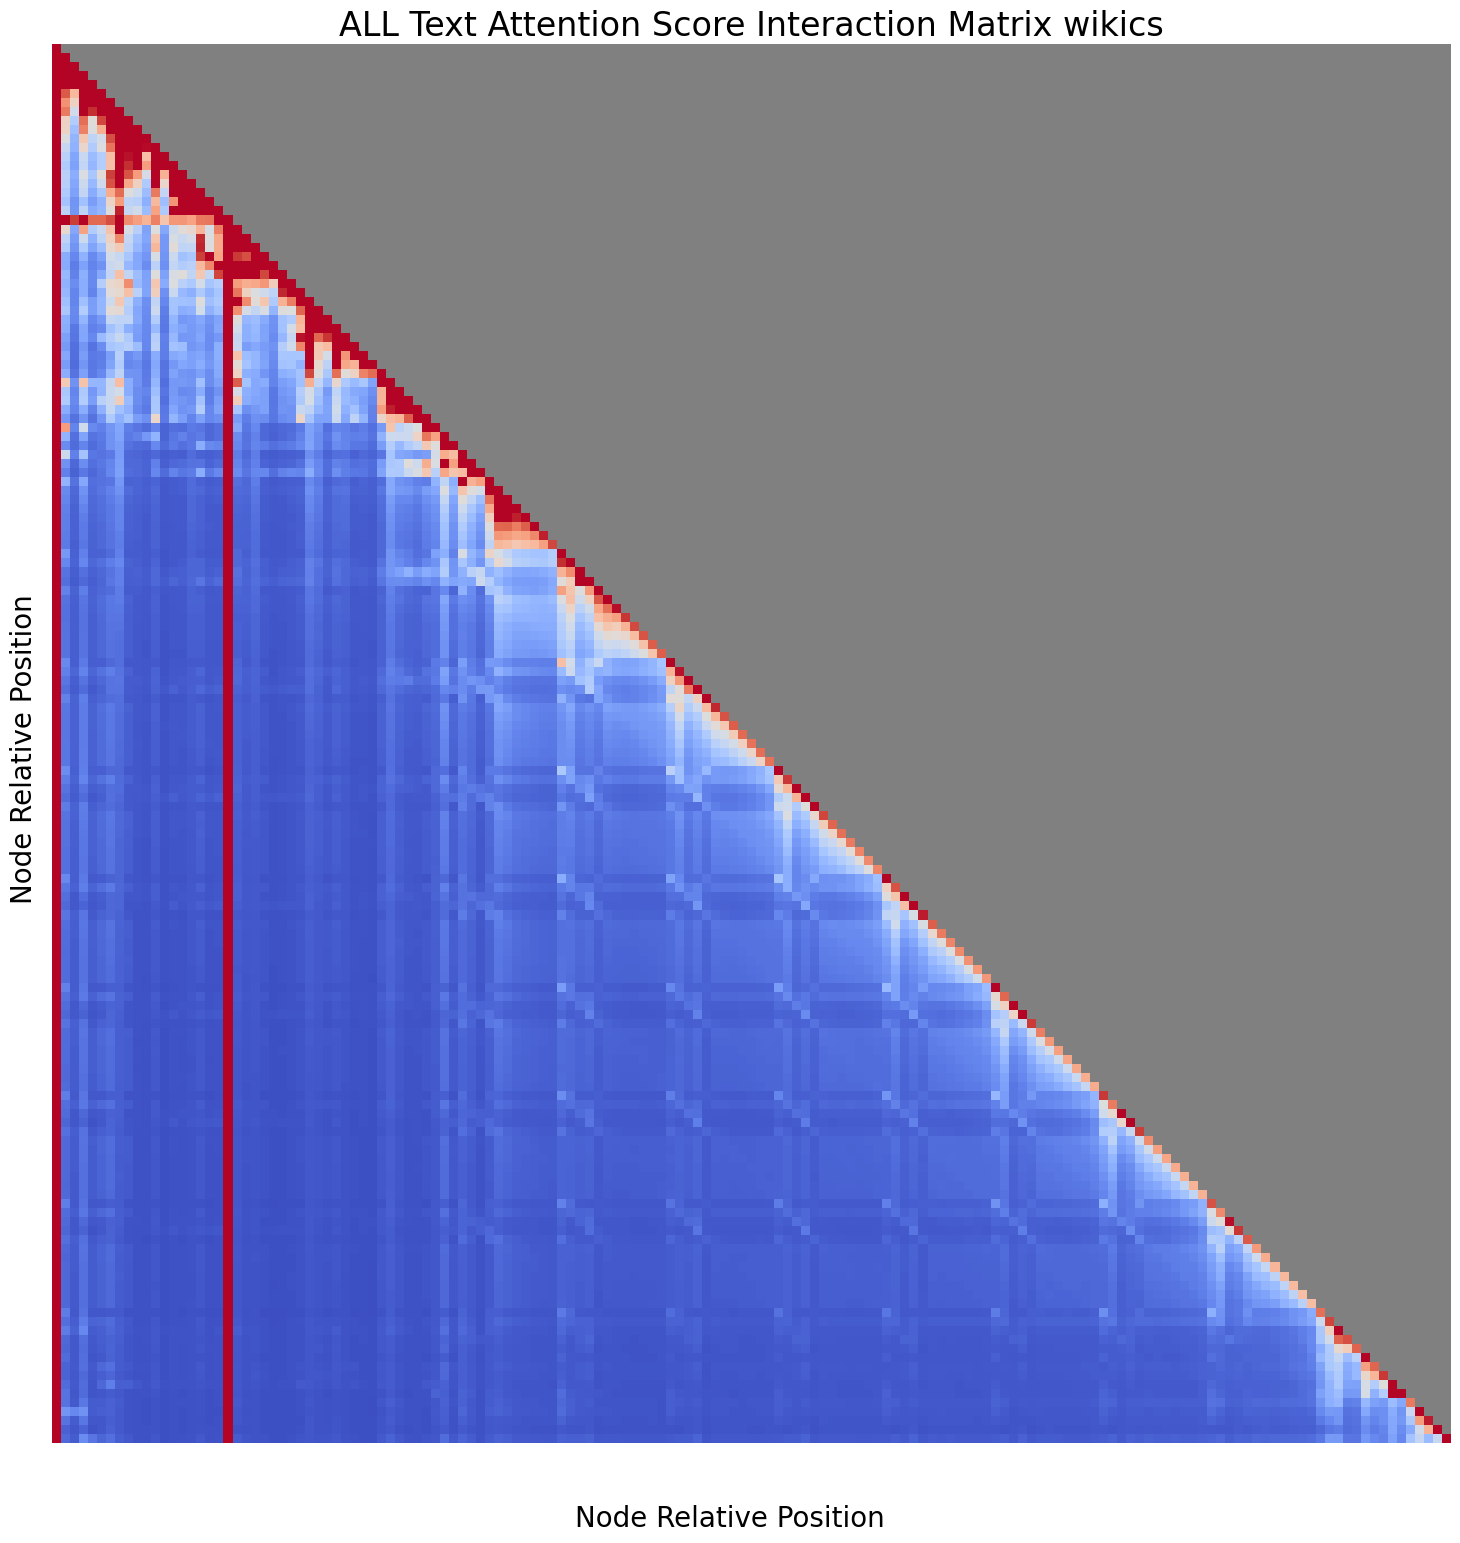

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载并处理wikics数据集的注意力权重
dataset = 'wikics'

all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')
all_attn_wikics=torch.stack(all_attn_wikics)
all_attn_wikics=all_attn_wikics.squeeze().view(-1, all_attn_wikics.shape[-3], all_attn_wikics.shape[-2], all_attn_wikics.shape[-1]).cpu()

text_attn_wikics = all_attn_wikics[:, :, :, text_index_dict[dataset]]
text_attn_wikics = text_attn_wikics[:, :, text_index_dict[dataset], :]
text_attn_wikics = masked_mean(masked_mean(text_attn_wikics, dim=0), dim=0)

# 创建一个主图形，包含一列
fig = plt.figure(figsize=(15, 16))  # 调整了宽度以适应单个热力图

# 左边：wikics数据集的单个热力图
ax1 = fig.add_subplot(1, 1, 1)  # 修改为单个subplot
sns.heatmap(text_attn_wikics, annot=False, fmt=".3f", linewidths=0, linecolor='white',
            cmap='coolwarm', vmin=0, vmax=0.02, ax=ax1, cbar=False, square=True)

# 在绘制完主要热力图后，直接用灰色覆盖上三角区域
for i in range(text_attn_wikics.shape[0]):
    for j in range(i + 1, text_attn_wikics.shape[1]):
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))

# # 添加红色边框来突出显示特定列
# rect_positions = [(45, 44, 2, 29), (54, 54, 2, 19), (63, 62, 2, 11)]
# for x, y, width, height in rect_positions:
#     rect = plt.Rectangle((x - 0.5, y), width, height,
#                          fill=False, edgecolor="orange", linewidth=2, clip_on=False)
#     ax1.add_patch(rect)

ax1.set_title(f'ALL Text Attention Score Interaction Matrix {dataset}', fontsize=24)
ax1.tick_params(axis='both', labelsize=18)

# 设置x轴和y轴的刻度，每8个值显示一次，并且显示对应的数值
# ticks_positions = np.arange(0, node_attn_wikics.shape[0], 8)
ax1.set_xticks([])
ax1.set_yticks([])

# # 显示具体的数值作为标签
# ax1.set_xticklabels(ticks_positions)
# ax1.set_yticklabels(ticks_positions)

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node Relative Position', fontsize=20)
fig.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"attention_score_matrix_text_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

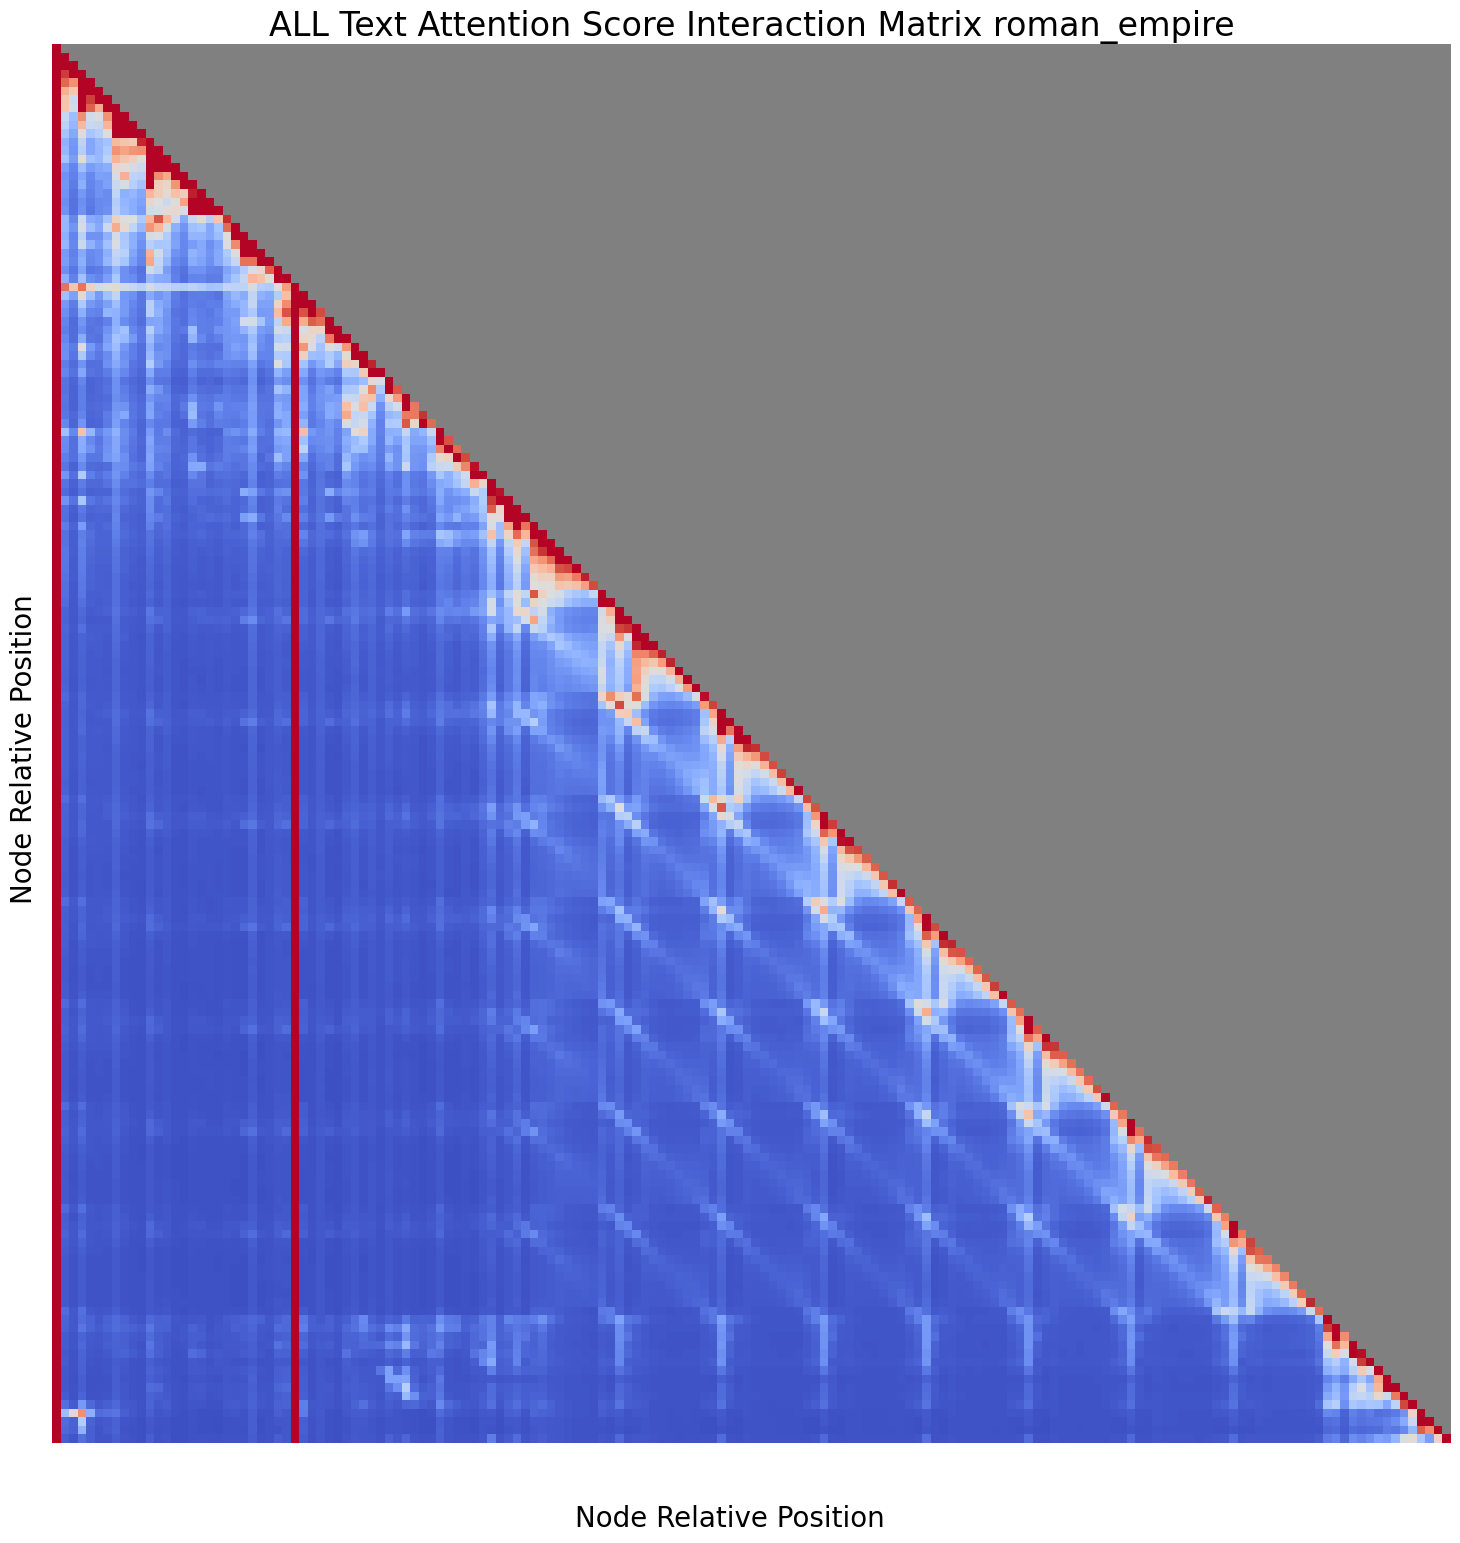

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载并处理wikics数据集的注意力权重
dataset = 'roman_empire'

all_attn_wikics = load_attention_weights(f'atten_pad_{dataset}')
all_attn_wikics=torch.stack(all_attn_wikics)
all_attn_wikics=all_attn_wikics.squeeze().view(-1, all_attn_wikics.shape[-3], all_attn_wikics.shape[-2], all_attn_wikics.shape[-1]).cpu()

text_attn_wikics = all_attn_wikics[:, :, :, text_index_dict[dataset]]
text_attn_wikics = text_attn_wikics[:, :, text_index_dict[dataset], :]
text_attn_wikics = masked_mean(masked_mean(text_attn_wikics, dim=0), dim=0)

# 创建一个主图形，包含一列
fig = plt.figure(figsize=(15, 16))  # 调整了宽度以适应单个热力图

# 左边：wikics数据集的单个热力图
ax1 = fig.add_subplot(1, 1, 1)  # 修改为单个subplot
sns.heatmap(text_attn_wikics, annot=False, fmt=".3f", linewidths=0, linecolor='white',
            cmap='coolwarm', vmin=0, vmax=0.03, ax=ax1, cbar=False, square=True)

# 在绘制完主要热力图后，直接用灰色覆盖上三角区域
for i in range(text_attn_wikics.shape[0]):
    for j in range(i + 1, text_attn_wikics.shape[1]):
        ax1.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, edgecolor="none", facecolor="gray", alpha=1))

# # 添加红色边框来突出显示特定列
# rect_positions = [(45, 44, 2, 29), (54, 54, 2, 19), (63, 62, 2, 11)]
# for x, y, width, height in rect_positions:
#     rect = plt.Rectangle((x - 0.5, y), width, height,
#                          fill=False, edgecolor="orange", linewidth=2, clip_on=False)
#     ax1.add_patch(rect)

ax1.set_title(f'ALL Text Attention Score Interaction Matrix {dataset}', fontsize=24)
ax1.tick_params(axis='both', labelsize=18)

# 设置x轴和y轴的刻度，每8个值显示一次，并且显示对应的数值
# ticks_positions = np.arange(0, node_attn_wikics.shape[0], 8)
ax1.set_xticks([])
ax1.set_yticks([])

# # 显示具体的数值作为标签
# ax1.set_xticklabels(ticks_positions)
# ax1.set_yticklabels(ticks_positions)

# 添加共享的X轴和Y轴标签
fig.supxlabel('Node Relative Position', fontsize=20)
fig.supylabel('Node Relative Position', fontsize=20)

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = f"attention_score_matrix_text_{dataset}.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图形
plt.show()